In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df
def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"

        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")

        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)

        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")

        return behavior_state_df

    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

# Block Instantiation

In [2]:
# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict

#animal = 'PV_62' || block_numbers = [23,24,25,26,27]
#animal = 'PV_126' || block_numbers = [7,8,9,10,11,12,13,14]

# prev data:
# ==animals = ['PV_57','PV_62','PV_126','PV_143','PV_106']
# ==block_lists = [[5,6,7,8,9],[23,24,25,26,27],[7,8,9,10,11,12,13,14],[1,2,3,4],[8,9,10,11,12]]
animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [3]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    #block.import_manual_sync_df()
    #block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

    # calibrate pupil diameter:


running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
got the calibration values from the analysis

In [4]:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')

    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [5]:

def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [13]:
 for block in block_collection:
    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [26]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.8,  # angular speed threshold in degrees/video frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.8,  # angular speed threshold in degrees/video frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, b

In [18]:
"""
blocks_to_fix = [block_dict['PV_62_block_024'],block_dict['PV_62_block_026']]
for block in blocks_to_fix:
    block.left_eye_data = block.left_eye_data.drop(columns=["k_phi_y", "k_theta_y"], errors="ignore")
    block.left_eye_data = block.left_eye_data.rename(columns={"k_phi_x":"k_phi",
                                                              "k_theta_x":"k_theta"})
    block.right_eye_data = block.right_eye_data.drop(columns=["k_phi_y", "k_theta_y"], errors="ignore")
    block.right_eye_data = block.right_eye_data.rename(columns={"k_phi_x":"k_phi",
                                                              "k_theta_x":"k_theta"})


name_tag = 'degrees_raw_verified'
for block in blocks_to_fix:
    #print(block.analysis_path / f'right_eye_data_{name_tag}.csv')
    block.right_eye_data.to_csv(block.analysis_path / f'right_eye_data_{name_tag}.csv')
    block.left_eye_data.to_csv(block.analysis_path / f'left_eye_data_{name_tag}.csv')
"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-18-8ced8b8833d4>, line 16)

In [74]:
print(block.behavior_state.head())

   start_time  end_time annotation  start_time_ms  end_time_ms
0         4.0   41004.0      quiet            4.0      41004.0
1     41004.0   88004.0     active        41004.0      88004.0
2     88004.0  100004.0      quiet        88004.0     100004.0
3    100004.0  129004.0     active       100004.0     129004.0
4    129004.0  162004.0      quiet       129004.0     162004.0


In [6]:
for block in block_collection:
#    block.block_get_lizard_movement()
    read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\analysis\block_008_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\analysis\block_009_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\analysis\block_010_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\analysis\block_011_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_012\analysis\block_012_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\analysis\block_001_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_143\2025_08_25\block_002\analysis\block_002_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_143\2025_08_25\block_003\analysis\block

In [7]:
for i, block in enumerate(block_collection):
    try:
        hi = block.behavior_state.iloc[0]
        #print(hi)
    except Exception:
        print('hi',i)

In [13]:
#block_collection.pop(11)

BlockSync object for animal PV_62 with 
block_num 038 at date 2023-05-01_13-57-45

In [45]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional, Iterable, Callable
from dataclasses import dataclass
from scipy.stats import ks_2samp

# ---------- helpers ----------
def _cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    """
    Cliff's delta: P(X>Y) - P(X<Y). Range [-1, 1].
    Efficient O(n log n) approach via ranking.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan
    # sort y once
    y_sorted = np.sort(y)
    # for each xi, count how many y < xi and y > xi
    from bisect import bisect_left, bisect_right
    less = 0
    greater = 0
    for xi in x:
        less += bisect_left(y_sorted, xi)
        greater += (len(y_sorted) - bisect_right(y_sorted, xi))
    n = len(x) * len(y)
    return (greater - less) / n if n > 0 else np.nan

@dataclass
class MCResult:
    observed_stat: float
    p_value: float
    null_distribution: np.ndarray
    n_permutations: int
    effect_cliffs_delta: Optional[float] = None
    ks_statistic: Optional[float] = None
    n_state1: int = 0
    n_state2: int = 0
    stat_name: str = "mean_diff"
    state1: str = "quiet"
    state2: str = "active"

# ---------- 1) Extract per-state values from your blocks ----------
def collect_pupil_by_state(
    blocks: Iterable,
    state_col: str = "annotation",
    pupil_col: str = "pupil_diameter",
    time_col: str = "ms_axis",
    behavior_df_attr: str = "behavior_state",
    left_df_attr: str = "left_eye_data",
    right_df_attr: str = "right_eye_data",
    states: Tuple[str, str] = ("quiet", "active"),
    sample_strategy: str = "epoch_median",
    # options: "epoch_median" (default, safest), "raw", "per_sec_median"
    min_epoch_ms: float = 0.0,      # ignore very short epochs (after time-unit alignment)
    per_sec_bin: float = 1000.0,    # for "per_sec_median"
    include_eye: bool = True,
) -> pd.DataFrame:
    """
    Returns a tidy DataFrame with columns:
      ['value','state','animal','block','eye','epoch_id']
    One row per *sample* depending on strategy:
      - 'epoch_median': one row per annotated epoch (median pupil)
      - 'raw': every raw sample inside epochs
      - 'per_sec_median': median per 1s bins inside each epoch
    """
    rows = []

    def _epoch_id(animal, block_num, eye, idx):
        return f"{animal}_B{str(block_num).zfill(3)}_{eye}_epoch{idx}"

    for block in blocks:
        # Behavior table with 'annotation','start_time','end_time'
        bdf = getattr(block, behavior_df_attr, None)
        if bdf is None or bdf.empty:
            continue

        # left/right eye tables
        ldf = getattr(block, left_df_attr, None)
        rdf = getattr(block, right_df_attr, None)
        if ldf is None or rdf is None or ldf.empty or rdf.empty:
            continue

        # unify schema
        sources = []
        if include_eye:
            sources.append(("L", ldf))
            sources.append(("R", rdf))
        else:
            # pooled within block (L+R): concatenate with eye mark to keep epoch_ids unique internally
            tmp = ldf[[time_col, pupil_col]].copy()
            tmp["eye"] = "L"
            tmp2 = rdf[[time_col, pupil_col]].copy()
            tmp2["eye"] = "R"
            pooled = pd.concat([tmp, tmp2], ignore_index=True)
            sources.append(("LR", pooled))

        # iterate epochs
        # assume behavior_df uses the same time unit as ms_axis (your code does)
        bdf = bdf.copy()
        bdf = bdf.rename(columns={"start_time": "start", "end_time": "end"})
        if min_epoch_ms > 0:
            bdf = bdf[(bdf["end"] - bdf["start"]) >= min_epoch_ms]

        for eye_label, df in sources:
            # guards
            if (time_col not in df.columns) or (pupil_col not in df.columns):
                continue
            # faster lookups
            df_local = df[[time_col, pupil_col]].dropna().sort_values(time_col)

            epoch_counter = 0
            for _, row in bdf.iterrows():
                st = row["start"]; et = row["end"]; stt = row[state_col]
                if stt not in states:
                    continue

                seg = df_local[(df_local[time_col] > st) & (df_local[time_col] <= et)]
                if seg.empty:
                    continue

                # sampling strategy
                if sample_strategy == "epoch_median":
                    val = float(np.nanmedian(seg[pupil_col].values))
                    rows.append({
                        "value": val,
                        "state": stt,
                        "animal": block.animal_call,
                        "block": str(block.block_num).zfill(3),
                        "eye": eye_label,
                        "epoch_id": _epoch_id(block.animal_call, block.block_num, eye_label, epoch_counter)
                    })
                elif sample_strategy == "raw":
                    for v in seg[pupil_col].values:
                        rows.append({
                            "value": float(v),
                            "state": stt,
                            "animal": block.animal_call,
                            "block": str(block.block_num).zfill(3),
                            "eye": eye_label,
                            "epoch_id": _epoch_id(block.animal_call, block.block_num, eye_label, epoch_counter)
                        })
                elif sample_strategy == "per_sec_median":
                    t0 = seg[time_col].min()
                    t1 = seg[time_col].max()
                    # bin by seconds (in ms)
                    edges = np.arange(t0, t1 + per_sec_bin, per_sec_bin)
                    inds = np.digitize(seg[time_col].values, edges)
                    for k in np.unique(inds):
                        chunk = seg[inds == k]
                        if chunk.empty:
                            continue
                        val = float(np.nanmedian(chunk[pupil_col].values))
                        rows.append({
                            "value": val,
                            "state": stt,
                            "animal": block.animal_call,
                            "block": str(block.block_num).zfill(3),
                            "eye": eye_label,
                            "epoch_id": _epoch_id(block.animal_call, block.block_num, eye_label, f"{epoch_counter}_bin{k}")
                        })
                else:
                    raise ValueError(f"Unknown sample_strategy: {sample_strategy}")

                epoch_counter += 1

    return pd.DataFrame(rows)

# ---------- 2) Monte-Carlo label-shuffle permutation test ----------
def monte_carlo_label_shuffle(
    df: pd.DataFrame,
    state1: str = "quiet",
    state2: str = "active",
    stat: str = "mean_diff",  # "mean_diff" | "median_diff" | "cliffs_delta" | "ks"
    n_permutations: int = 10000,
    strata_cols: Tuple[str, ...] = ("animal", "block", "eye"),
    random_state: Optional[int] = 42,
    dropna: bool = True,
) -> MCResult:
    """
    Two-condition permutation test with label-shuffling *within strata*.
    df must contain columns: ['value','state'] and the strata columns.

    stat options:
      - "mean_diff": mean(state1) - mean(state2)
      - "median_diff": median(state1) - median(state2)
      - "cliffs_delta": Cliff's delta (state1 vs state2)
      - "ks": Kolmogorov–Smirnov statistic (state1 vs state2)
    """
    rng = np.random.default_rng(random_state)
    needed_cols = {"value", "state"} | set(strata_cols)
    missing = needed_cols - set(df.columns)
    if missing:
        raise ValueError(f"df is missing required columns: {missing}")

    dat = df.copy()
    if dropna:
        dat = dat[np.isfinite(dat["value"].values)]

    # keep only the two states
    dat = dat[dat["state"].isin([state1, state2])].copy()
    if dat.empty:
        raise ValueError("No data for the requested two states.")

    # observed statistic
    v1 = dat.loc[dat["state"] == state1, "value"].values
    v2 = dat.loc[dat["state"] == state2, "value"].values

    def _compute_stat(x: np.ndarray, y: np.ndarray, name: str) -> float:
        if name == "mean_diff":
            return float(np.nanmean(x) - np.nanmean(y))
        elif name == "median_diff":
            return float(np.nanmedian(x) - np.nanmedian(y))
        elif name == "cliffs_delta":
            return float(_cliffs_delta(x, y))
        elif name == "ks":
            return float(ks_2samp(x, y, alternative="two-sided", mode="auto").statistic)
        else:
            raise ValueError(f"Unknown stat: {name}")

    observed = _compute_stat(v1, v2, stat)
    cd_obs = _cliffs_delta(v1, v2)
    ks_obs = ks_2samp(v1, v2, alternative="two-sided", mode="auto").statistic

    # pre-allocate null
    null = np.empty(n_permutations, dtype=float)

    # vectorized-ish permutation within strata: shuffle the 'state' within each stratum
    # keep values fixed.
    grouped = list(dat.groupby(list(strata_cols), sort=False))

    for it in range(n_permutations):
        # create permuted copy of states
        perm_states = []
        for _, g in grouped:
            st = g["state"].values.copy()
            rng.shuffle(st)  # in-place shuffle within stratum
            perm_states.append(st)
        perm_states = np.concatenate(perm_states, axis=0)

        # compute stat on permuted labels
        # Keep order of dat fixed; replace states
        mask1 = (perm_states == state1)
        mask2 = (perm_states == state2)
        x = dat["value"].values[mask1]
        y = dat["value"].values[mask2]
        null[it] = _compute_stat(x, y, stat)

    # two-sided p
    p = (np.sum(np.abs(null) >= np.abs(observed)) + 1) / (len(null) + 1)

    return MCResult(
        observed_stat=float(observed),
        p_value=float(p),
        null_distribution=null,
        n_permutations=n_permutations,
        effect_cliffs_delta=float(cd_obs),
        ks_statistic=float(ks_obs),
        n_state1=int(len(v1)),
        n_state2=int(len(v2)),
        stat_name=stat,
        state1=state1,
        state2=state2,
    )

# ---------- 3) Convenience: run directly on your exported pooled pickle ----------
# This matches your earlier "combined_aggregated" export (pooled L+R per state).
import pickle

def permutation_from_exported_pickle(
    data_file: str,
    state1: str = "quiet",
    state2: str = "active",
    stat: str = "mean_diff",
    n_permutations: int = 10000,
    random_state: Optional[int] = 42,
) -> MCResult:
    """
    Runs a simple pooled permutation test using your combined_aggregated_data.pkl
    produced by plot_combined_eye_probability_histograms(...).
    NOTE: This ignores block/eye/animal stratification — use for quick checks only.
    """
    with open(data_file, "rb") as f:
        data = pickle.load(f)
    if state1 not in data or state2 not in data:
        raise ValueError(f"States not found in export: {list(data.keys())}")

    x = np.asarray(data[state1], dtype=float)
    y = np.asarray(data[state2], dtype=float)
    mask = np.isfinite(x); x = x[mask]
    mask = np.isfinite(y); y = y[mask]

    # observed
    def _compute_stat(a, b, name):
        if name == "mean_diff": return float(np.nanmean(a) - np.nanmean(b))
        if name == "median_diff": return float(np.nanmedian(a) - np.nanmedian(b))
        if name == "cliffs_delta": return float(_cliffs_delta(a, b))
        if name == "ks": return float(ks_2samp(a, b).statistic)
        raise ValueError(name)

    obs = _compute_stat(x, y, stat)
    cd_obs = _cliffs_delta(x, y)
    ks_obs = ks_2samp(x, y, alternative="two-sided", mode="auto").statistic

    rng = np.random.default_rng(random_state)
    z = np.concatenate([x, y])
    labels = np.array([0]*len(x) + [1]*len(y))
    null = np.empty(n_permutations, dtype=float)
    for i in range(n_permutations):
        rng.shuffle(labels)
        xa = z[labels == 0]
        ya = z[labels == 1]
        null[i] = _compute_stat(xa, ya, stat)

    p = (np.sum(np.abs(null) >= np.abs(obs)) + 1) / (n_permutations + 1)
    return MCResult(
        observed_stat=float(obs),
        p_value=float(p),
        null_distribution=null,
        n_permutations=n_permutations,
        effect_cliffs_delta=float(cd_obs),
        ks_statistic=float(ks_obs),
        n_state1=int(len(x)),
        n_state2=int(len(y)),
        stat_name=stat,
        state1=state1,
        state2=state2,
    )


In [46]:
# Choose the relevant blocks (e.g., all PV_62 except block 038)
animal = 'PV_62'
keys = [k for k in block_dict.keys() if (animal in k and '038' not in k)]
blocks = [block_dict[k] for k in keys]

# 1) Extract one value per annotated epoch per eye (robust to autocorrelation)
tidy = collect_pupil_by_state(
    block_collection,
    states=("quiet","active"),
    sample_strategy="epoch_median",   # safest default
    min_epoch_ms=1000.0               # ignore <1 s epochs (tweak if needed)
)

# 2) Run permutation with within-strata shuffles
res = monte_carlo_label_shuffle(
    tidy,
    state1="quiet",
    state2="active",
    stat="median_diff",               # "mean_diff","median_diff","cliffs_delta","ks"
    n_permutations=20000,             # increase if you want tighter p-value granularity
    strata_cols=("animal","block","eye"),
    random_state=123
)

print(f"=== Monte-Carlo (epoch medians, stratified) ===")
print(f"Statistic ({res.stat_name}): {res.observed_stat:.4g}")
print(f"P-value (two-sided):        {res.p_value:.4g}")
print(f"Cliff's δ (effect size):    {res.effect_cliffs_delta:.4g}")
print(f"KS statistic (diagnostic):  {res.ks_statistic:.4g}")
print(f"Samples: {res.n_state1} (quiet) vs {res.n_state2} (active)")


=== Monte-Carlo (epoch medians, stratified) ===
Statistic (median_diff): 0.05477
P-value (two-sided):        5e-05
Cliff's δ (effect size):    -0.1139
KS statistic (diagnostic):  0.1315
Samples: 1030 (quiet) vs 977 (active)


=== Monte-Carlo (epoch medians, stratified within animal×block×eye) ===
Statistic (median_diff) [quiet−active]: 0.054773 mm
P-value (two-sided):                         4.99975e-05  (N_perm=20000)
Cliff's δ (effect size, quiet vs active): -0.1139
KS statistic (diagnostic):                   0.1315
Samples: 1030 (quiet) vs 977 (active)
Median(quiet) = 1.8748 mm  -> observed diff ≈ 2.92% of quiet median


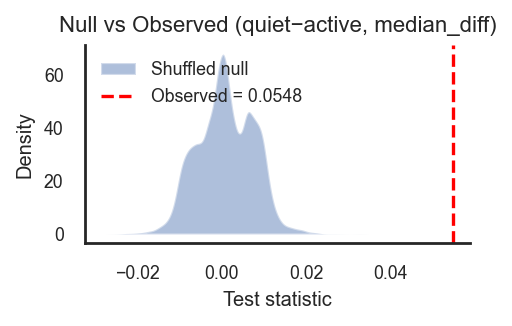

In [47]:
# THIS ONE PULLS ALL ANIMALS TOGETHER
# === Stratified Monte-Carlo test for pupil diameter (quiet vs active), with KDE plot ===
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Iterable, Tuple, Optional
from scipy.stats import ks_2samp, gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- effect size helper -----------------
def _cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    """Cliff's delta: P(X>Y) - P(X<Y). Range [-1, 1]."""
    x = np.asarray(x, dtype=float); x = x[np.isfinite(x)]
    y = np.asarray(y, dtype=float); y = y[np.isfinite(y)]
    if x.size == 0 or y.size == 0:
        return np.nan
    y_sorted = np.sort(y)
    from bisect import bisect_left, bisect_right
    less = greater = 0
    for xi in x:
        less    += bisect_left(y_sorted, xi)
        greater += (y_sorted.size - bisect_right(y_sorted, xi))
    n = x.size * y_sorted.size
    return (greater - less) / n if n else np.nan

@dataclass
class MCResult:
    observed_stat: float
    p_value: float
    null_distribution: np.ndarray
    n_permutations: int
    effect_cliffs_delta: float
    ks_statistic: float
    n_state1: int
    n_state2: int
    stat_name: str
    state1: str
    state2: str

# ----------------- 1) Collect one value per epoch per eye -----------------
def collect_pupil_by_state(
    blocks: Iterable,
    *,
    states: Tuple[str, str] = ("quiet", "active"),
    pupil_col: str = "pupil_diameter",
    time_col: str  = "ms_axis",
    behavior_attr: str = "behavior_state",
    left_attr: str = "left_eye_data",
    right_attr: str = "right_eye_data",
    sample_strategy: str = "epoch_median",   # 'epoch_median' | 'raw' | 'per_sec_median'
    min_epoch_ms: float = 1000.0,
    per_sec_bin_ms: float = 1000.0,
) -> pd.DataFrame:
    rows = []
    def _epoch_id(animal, block_num, eye, idx): return f"{animal}_B{str(block_num).zfill(3)}_{eye}_e{idx}"
    for block in blocks:
        bdf = getattr(block, behavior_attr, None)
        ldf = getattr(block, left_attr, None)
        rdf = getattr(block, right_attr, None)
        if bdf is None or ldf is None or rdf is None:
            continue
        if any(df is None or df.empty for df in (bdf, ldf, rdf)):
            continue
        # normalize behavior columns
        b = bdf.rename(columns={"start_time":"start", "end_time":"end", "annotation":"state"}).copy()
        if {"start","end","state"}.difference(b.columns):
            continue
        if min_epoch_ms > 0:
            b = b[(b["end"] - b["start"]) >= min_epoch_ms]
        if b.empty:
            continue
        for eye_label, edf in (("L", ldf), ("R", rdf)):
            if time_col not in edf.columns or pupil_col not in edf.columns:
                continue
            e = edf[[time_col, pupil_col]].dropna().sort_values(time_col)
            idx_ctr = 0
            for _, row in b.iterrows():
                if row["state"] not in states:
                    continue
                seg = e[(e[time_col] > row["start"]) & (e[time_col] <= row["end"])]
                if seg.empty:
                    continue
                if sample_strategy == "epoch_median":
                    val = float(np.nanmedian(seg[pupil_col].values))
                    rows.append({"value": val, "state": row["state"], "animal": block.animal_call,
                                 "block": str(block.block_num).zfill(3), "eye": eye_label,
                                 "epoch_id": _epoch_id(block.animal_call, block.block_num, eye_label, idx_ctr)})
                elif sample_strategy == "raw":
                    for v in seg[pupil_col].values:
                        rows.append({"value": float(v), "state": row["state"], "animal": block.animal_call,
                                     "block": str(block.block_num).zfill(3), "eye": eye_label,
                                     "epoch_id": _epoch_id(block.animal_call, block.block_num, eye_label, idx_ctr)})
                elif sample_strategy == "per_sec_median":
                    t0, t1 = seg[time_col].min(), seg[time_col].max()
                    edges = np.arange(t0, t1 + per_sec_bin_ms, per_sec_bin_ms)
                    inds = np.digitize(seg[time_col].values, edges)
                    for k in np.unique(inds):
                        chunk = seg[inds == k]
                        if chunk.empty:
                            continue
                        val = float(np.nanmedian(chunk[pupil_col].values))
                        rows.append({"value": val, "state": row["state"], "animal": block.animal_call,
                                     "block": str(block.block_num).zfill(3), "eye": eye_label,
                                     "epoch_id": _epoch_id(block.animal_call, block.block_num, eye_label, f"{idx_ctr}_k{k}")})
                else:
                    raise ValueError("Unknown sample_strategy")
                idx_ctr += 1
    return pd.DataFrame(rows)

# ----------------- 2) Stratified permutation test -----------------
def monte_carlo_label_shuffle(
    df: pd.DataFrame,
    state1: str = "quiet",
    state2: str = "active",
    stat: str = "median_diff",               # 'mean_diff' | 'median_diff' | 'cliffs_delta' | 'ks'
    n_permutations: int = 20000,
    strata_cols: Tuple[str, ...] = ("animal", "block", "eye"),
    random_state: Optional[int] = 123,
    dropna: bool = True,
) -> MCResult:
    needed = {"value","state"} | set(strata_cols)
    if missing := (needed - set(df.columns)):
        raise ValueError(f"Missing columns: {missing}")
    dat = df.copy()
    if dropna:
        dat = dat[np.isfinite(dat["value"].values)]
    dat = dat[dat["state"].isin([state1, state2])]
    if dat.empty:
        raise ValueError("No data for requested states.")
    v1 = dat.loc[dat.state==state1, "value"].to_numpy()
    v2 = dat.loc[dat.state==state2, "value"].to_numpy()

    def _compute(x, y, which):
        if which == "mean_diff":   return float(np.nanmean(x) - np.nanmean(y))
        if which == "median_diff": return float(np.nanmedian(x) - np.nanmedian(y))
        if which == "cliffs_delta":return float(_cliffs_delta(x, y))
        if which == "ks":          return float(ks_2samp(x, y, mode="auto").statistic)
        raise ValueError(which)

    observed = _compute(v1, v2, stat)
    cd_obs   = _cliffs_delta(v1, v2)
    ks_obs   = ks_2samp(v1, v2, mode="auto").statistic

    rng = np.random.default_rng(random_state)
    null = np.empty(n_permutations, dtype=float)
    groups = list(dat.groupby(list(strata_cols), sort=False))

    for i in range(n_permutations):
        perm_states = []
        for _, g in groups:
            st = g["state"].to_numpy().copy()
            rng.shuffle(st)
            perm_states.append(st)
        perm_states = np.concatenate(perm_states, axis=0)
        x = dat["value"].to_numpy()[perm_states == state1]
        y = dat["value"].to_numpy()[perm_states == state2]
        null[i] = _compute(x, y, stat)

    p_val = (np.sum(np.abs(null) >= np.abs(observed)) + 1) / (n_permutations + 1)

    return MCResult(
        observed_stat=float(observed),
        p_value=float(p_val),
        null_distribution=null,
        n_permutations=n_permutations,
        effect_cliffs_delta=float(cd_obs),
        ks_statistic=float(ks_obs),
        n_state1=int(v1.size),
        n_state2=int(v2.size),
        stat_name=stat,
        state1=state1,
        state2=state2,
    )

# ----------------- 3) Run on ENTIRE block_collection & plot -----------------
# Parameters you can tweak
STATES        = ("quiet","active")
STATISTIC     = "median_diff"   # 'mean_diff' | 'median_diff' | 'cliffs_delta' | 'ks'
N_PERM        = 20000
STRATA        = ("animal","block","eye")
MIN_EPOCH_MS  = 1000.0
SAMPLE_MODE   = "epoch_median"  # safest against autocorrelation

# 3a) Build tidy table
tidy = collect_pupil_by_state(
    block_collection,
    states=STATES,
    sample_strategy=SAMPLE_MODE,
    min_epoch_ms=MIN_EPOCH_MS
)

if tidy.empty or tidy["state"].nunique() < 2:
    raise RuntimeError("No data collected or only one state present. Check annotations and inputs.")

# 3b) Permutation test
res = monte_carlo_label_shuffle(
    tidy,
    state1=STATES[0],
    state2=STATES[1],
    stat=STATISTIC,
    n_permutations=N_PERM,
    strata_cols=STRATA,
    random_state=123
)

# 3c) Print summary
quiet_vals  = tidy.loc[tidy.state==STATES[0],"value"].to_numpy()
active_vals = tidy.loc[tidy.state==STATES[1],"value"].to_numpy()
quiet_med   = float(np.nanmedian(quiet_vals))
pct = 100.0 * res.observed_stat / max(quiet_med, 1e-12)

print("=== Monte-Carlo (epoch medians, stratified within animal×block×eye) ===")
print(f"Statistic ({res.stat_name}) [{res.state1}−{res.state2}]: {res.observed_stat:.6f} mm")
print(f"P-value (two-sided):                         {res.p_value:.6g}  (N_perm={res.n_permutations})")
print(f"Cliff's δ (effect size, {res.state1} vs {res.state2}): {res.effect_cliffs_delta:.4f}")
print(f"KS statistic (diagnostic):                   {res.ks_statistic:.4f}")
print(f"Samples: {res.n_state1} ({res.state1}) vs {res.n_state2} ({res.state2})")
print(f"Median({res.state1}) = {quiet_med:.4f} mm  -> observed diff ≈ {pct:.2f}% of {res.state1} median")

# 3d) KDE plot of null with observed marker
sns.set(style="white")
fig, ax = plt.subplots(figsize=(3.2, 2.2), dpi=160)

null = res.null_distribution
kde = gaussian_kde(null)
x_min, x_max = float(null.min()), float(null.max())
pad = 0.05 * (x_max - x_min if x_max > x_min else 1.0)
xs = np.linspace(x_min - pad, x_max + pad, 600)
ys = kde(xs)

ax.fill_between(xs, ys, alpha=0.45, label="Shuffled null")
ax.axvline(res.observed_stat, color="red", linestyle="--", linewidth=1.5,
           label=f"Observed = {res.observed_stat:.4f}")
ax.set_title(f"Null vs Observed ({res.state1}−{res.state2}, {res.stat_name})", fontsize=10)
ax.set_xlabel("Test statistic", fontsize=9)
ax.set_ylabel("Density", fontsize=9)
ax.tick_params(axis="both", labelsize=8)
ax.legend(fontsize=8, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()


In [49]:
# THIS ONE TREATS EACH ANIMAL SEPARATELY
import numpy as np
import pandas as pd
from typing import Tuple, Optional
from scipy.stats import ks_2samp

# ----- small helper: Cliff's delta -----
def _cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float); x = x[np.isfinite(x)]
    y = np.asarray(y, dtype=float); y = y[np.isfinite(y)]
    if x.size == 0 or y.size == 0:
        return np.nan
    y_sorted = np.sort(y)
    from bisect import bisect_left, bisect_right
    less = greater = 0
    for xi in x:
        less    += bisect_left(y_sorted, xi)                 # count y < xi
        greater += (y_sorted.size - bisect_right(y_sorted, xi))  # count y > xi
    n = x.size * y_sorted.size
    return (greater - less) / n if n else np.nan

# ===== per-animal permutation (label shuffle within block×eye) =====
def per_animal_permutation_tests(
    tidy: pd.DataFrame,
    state1: str = "quiet",
    state2: str = "active",
    stat: str = "median_diff",                # 'median_diff' | 'mean_diff' | 'cliffs_delta' | 'ks'
    n_permutations: int = 20000,
    strata_within_animal: Tuple[str, ...] = ("block","eye"),
    random_state: Optional[int] = 123,
    dropna: bool = True,
    return_null: bool = False                # if True, include each animal's null array in the output
) -> pd.DataFrame:
    """
    Compute a permutation p-value per animal by shuffling labels within that animal's strata (block×eye).
    tidy must include columns: ['animal','state','value'] and the 'strata_within_animal' columns.

    Returns a DataFrame with one row per animal:
      ['animal','observed_stat','p_value','n_quiet','n_active','cliffs_delta','ks_stat','n_perm', ('null' if requested)]
    """
    required = {"animal","state","value"} | set(strata_within_animal)
    missing = required - set(tidy.columns)
    if missing:
        raise ValueError(f"tidy is missing columns: {missing}")

    # Restrict to the two states and drop NaNs if requested
    df = tidy[tidy["state"].isin([state1, state2])].copy()
    if dropna:
        df = df[np.isfinite(df["value"].values)]
    if df.empty:
        raise ValueError("No data for requested states.")

    rng = np.random.default_rng(random_state)

    def _compute(x: np.ndarray, y: np.ndarray, which: str) -> float:
        if which == "median_diff": return float(np.nanmedian(x) - np.nanmedian(y))
        if which == "mean_diff":   return float(np.nanmean(x)   - np.nanmean(y))
        if which == "cliffs_delta":return float(_cliffs_delta(x, y))
        if which == "ks":          return float(ks_2samp(x, y, mode="auto").statistic)
        raise ValueError(f"Unknown stat: {which}")

    results = []
    animals = sorted(df["animal"].unique())

    for a in animals:
        g = df[df["animal"] == a].copy()
        if g.empty:
            continue

        vq = g.loc[g["state"] == state1, "value"].to_numpy()
        va = g.loc[g["state"] == state2, "value"].to_numpy()
        n_q, n_a = int(vq.size), int(va.size)

        # If one state is missing, we can't test
        if n_q == 0 or n_a == 0:
            row = {
                "animal": a,
                "observed_stat": np.nan,
                "p_value": np.nan,
                "n_quiet": n_q,
                "n_active": n_a,
                "cliffs_delta": np.nan,
                "ks_stat": np.nan,
                "n_perm": 0
            }
            if return_null: row["null"] = np.array([], dtype=float)
            results.append(row)
            continue

        # observed stat (on this animal only)
        obs = _compute(vq, va, stat)
        cd_obs = _cliffs_delta(vq, va)
        ks_obs = ks_2samp(vq, va, mode="auto").statistic

        # Build permutation null by shuffling labels within (block×eye) for this animal
        groups = list(g.groupby(list(strata_within_animal), sort=False))
        null = np.empty(n_permutations, dtype=float)

        # We'll compute on the fly using the same 'g' order each time
        values = g["value"].to_numpy()
        states_original = g["state"].to_numpy()

        # index ranges for each group to splice permuted states back in place
        idx_slices = []
        start = 0
        concat_states = []
        for _, sub in groups:
            m = len(sub)
            idx_slices.append(slice(start, start + m))
            concat_states.append(sub["state"].to_numpy())
            start += m
        # Concatenate once to get an ordering template
        order_states = np.concatenate(concat_states, axis=0)
        assert order_states.shape[0] == values.shape[0]

        for i in range(n_permutations):
            perm_states = order_states.copy()
            # shuffle within each stratum "block×eye"
            pos = 0
            for _, sub in groups:
                m = len(sub)
                sub_states = perm_states[pos:pos+m]
                rng.shuffle(sub_states)
                perm_states[pos:pos+m] = sub_states
                pos += m

            # split values by permuted labels
            x = values[perm_states == state1]
            y = values[perm_states == state2]
            # Guard against pathological all-one-state after shuffling (shouldn't happen given original mix)
            if x.size == 0 or y.size == 0:
                null[i] = np.nan
            else:
                null[i] = _compute(x, y, stat)

        null = null[np.isfinite(null)]
        if null.size == 0:
            p = np.nan
        else:
            p = (np.sum(np.abs(null) >= np.abs(obs)) + 1) / (null.size + 1)

        row = {
            "animal": a,
            "observed_stat": float(obs),
            "p_value": float(p),
            "n_quiet": n_q,
            "n_active": n_a,
            "cliffs_delta": float(cd_obs),
            "ks_stat": float(ks_obs),
            "n_perm": int(null.size),
        }
        if return_null:
            row["null"] = null
        results.append(row)

    # Nicely ordered columns
    cols = ["animal","observed_stat","p_value","n_quiet","n_active","cliffs_delta","ks_stat","n_perm"]
    if return_null: cols.append("null")
    return pd.DataFrame(results, columns=cols)

# ===== Example usage =====
# If you already have `tidy` from collect_pupil_by_state(...), just run:
per_animal = per_animal_permutation_tests(tidy,
                                          state1="quiet", state2="active",
                                          stat="median_diff", n_permutations=20000,
                                          strata_within_animal=("block","eye"),
                                          random_state=123,
                                          return_null=False)
display(per_animal.sort_values("p_value"))


,animal,observed_stat,p_value,n_quiet,n_active,cliffs_delta,ks_stat,n_perm
1,PV_126,0.038028,0.000100,460,439,-0.188898,0.180024,20000
4,PV_62,0.041609,0.001100,82,78,-0.244215,0.278924,20000
2,PV_143,0.029735,0.047048,58,49,-0.268825,0.262491,20000
0,PV_106,0.006172,0.496725,152,142,-0.134637,0.260471,20000
3,PV_57,0.002022,0.826259,278,269,0.015645,0.059747,20000


,animal,n_blocks,n_valid_points,frac_corr,frac_weak,frac_anti,median_r,iqr_r,window_s,corr_thr_pos,corr_thr_neg,normalize_per_block,min_valid_in_window
0,PV_106,5,315918,0.700226,0.231709,0.068065,0.441840,0.526055,10.0,0.2,-0.2,True,0.33
3,PV_126,6,550622,0.566596,0.270616,0.162789,0.285857,0.649722,10.0,0.2,-0.2,True,0.33
1,PV_143,4,167337,0.674137,0.214412,0.111452,0.496867,0.685170,10.0,0.2,-0.2,True,0.33
4,PV_57,5,240032,0.750196,0.210659,0.039145,0.451790,0.469229,10.0,0.2,-0.2,True,0.33
2,PV_62,2,187141,0.764905,0.175734,0.059362,0.534427,0.523687,10.0,0.2,-0.2,True,0.33


,state,mean_pct,std_pct,sem_pct,pooled_pct,n_animals,total_valid_points
0,corr,69.121171,7.875873,3.522197,66.337086,5,1461050
1,weak,22.062590,3.455093,1.545165,23.376270,5,1461050
2,anti,8.816239,4.936491,2.207666,10.286643,5,1461050


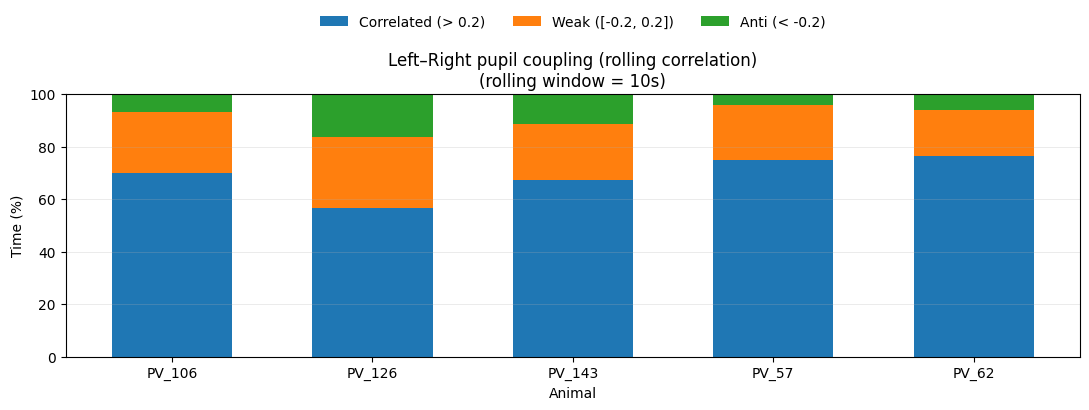

In [11]:
# === Per-animal time fractions of rolling L–R pupil correlation, with stacked bars + overall stats ===
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import pickle
from typing import Dict, Tuple, Optional, Union

# Vector-friendly export settings (PDF/PS fonts compatible with Illustrator)
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
rcParams["font.family"] = "DejaVu Sans"  # safe default; change if you have a house font

# notebook-friendly display fallback
try:
    from IPython.display import display  # type: ignore
except Exception:
    def display(x):  # type: ignore
        print(x)


def pupil_correlation_stackedbars_per_animal(
    block_collection=None,
    *,
    # Data columns
    pupil_col: str = "pupil_diameter",
    time_col: str = "ms_axis",
    # Analysis params
    roll_window_s: float = 10.0,
    # Thresholds: correlated r>0.2; weak −0.2≤r≤0.2; anti r<−0.2
    corr_thr_pos: float = 0.2,
    corr_thr_neg: float = -0.2,
    normalize_per_block: bool = True,     # robust z-score per block
    min_valid_in_window: float = 0.33,    # fraction of samples required in a window
    # Plotting
    figsize: Tuple[int, int] = (11, 4.5),
    title: str = "Left–Right pupil coupling (rolling correlation)",
    # Export / Import
    export_path: Optional[Union[str, Path]] = None,   # folder or full file path stem
    export_basename: str = "pupil_coupling_stackedbars",
    save_pdf: bool = True,
    load_pickle: Optional[Union[str, Path]] = None,   # if provided, re-draw from pickle and ignore raw
    # NEW
    return_overall_df: bool = True,       # if True: return (per_animal_df, overall_df, meta)
    show_tables: bool = True,             # display per_animal_df + overall_df
):
    """
    Mode A (compute): provide block_collection (iterable of BlockSync blocks).
      - Computes rolling correlation between left and right pupil time series (per block).
      - Aggregates time-weighted fractions per animal in 3 bins:
            correlated (r > corr_thr_pos),
            weak       (corr_thr_neg <= r <= corr_thr_pos),
            anti       (r < corr_thr_neg).
      - Draws a stacked bar chart (x=animals, y=0..100%).
      - If export_path is given, saves a .pickle with per-animal df + overall df + metadata and a .pdf figure.

    Mode B (re-draw): provide load_pickle=".../file.pickle"; block_collection not required.
      - Recreates the stacked bar figure from saved data/metadata.

    Returns
    -------
    If return_overall_df is True:
        per_animal_df, overall_df, meta
    else:
        per_animal_df, meta

    overall_df columns:
        ['state','mean_pct','std_pct','sem_pct','pooled_pct','n_animals','total_valid_points']
    """
    # ---------- helpers ----------
    def _animal_id(block) -> str:
        return getattr(block, "animal_call", None) or getattr(block, "animal", None) or "UNK"

    def _estimate_fs(ms: np.ndarray) -> float:
        d = np.diff(ms.astype(float))
        d = d[np.isfinite(d)]
        if d.size == 0:
            return np.nan
        med = np.median(d)
        return 1000.0 / med if med > 0 else np.nan

    def _prep(block) -> Optional[pd.DataFrame]:
        ldf = getattr(block, "left_eye_data_clean", None) or getattr(block, "left_eye_data", None)
        rdf = getattr(block, "right_eye_data_clean", None) or getattr(block, "right_eye_data", None)
        if ldf is None or rdf is None:
            return None
        if time_col not in ldf.columns or time_col not in rdf.columns:
            return None
        if pupil_col not in ldf.columns or pupil_col not in rdf.columns:
            return None
        m = pd.merge(
            ldf[[time_col, pupil_col]].rename(columns={pupil_col: "pupil_L"}),
            rdf[[time_col, pupil_col]].rename(columns={pupil_col: "pupil_R"}),
            on=time_col,
            how="inner",
        ).sort_values(time_col)
        m = m.replace([np.inf, -np.inf], np.nan).dropna(subset=[time_col, "pupil_L", "pupil_R"])
        return m

    def _robust_z(df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        for c in ["pupil_L", "pupil_R"]:
            x = out[c].to_numpy(dtype=float)
            mu = np.nanmedian(x)
            mad = np.nanmedian(np.abs(x - mu))
            s = 1.4826 * mad if mad > 0 else np.nanstd(x)
            if (not np.isfinite(s)) or (s == 0):
                s2 = np.nanstd(x)
                s = s2 if (np.isfinite(s2) and s2 > 0) else 1.0
            out[c] = (x - mu) / s
        return out

    def _rolling_r(df: pd.DataFrame, fs: float, win_s: float) -> pd.Series:
        if not np.isfinite(fs) or win_s <= 0:
            return pd.Series(np.nan, index=df.index)
        win = max(int(round(fs * win_s)), 5)
        minp = max(3, int(win * min_valid_in_window))

        x = df["pupil_L"]
        y = df["pupil_R"]

        mu_x = x.rolling(win, center=True, min_periods=minp).mean()
        mu_y = y.rolling(win, center=True, min_periods=minp).mean()
        dx, dy = x - mu_x, y - mu_y

        cov = (dx * dy).rolling(win, center=True, min_periods=minp).mean()
        vx = (dx * dx).rolling(win, center=True, min_periods=minp).mean()
        vy = (dy * dy).rolling(win, center=True, min_periods=minp).mean()

        r = cov / np.sqrt(vx * vy)
        return r

    def _build_per_animal_df_from_bins(
        animal_bins: Dict[str, Dict[str, float]],
        animal_stats: Dict[str, Dict[str, list]],
        animal_blocks: Dict[str, int],
    ) -> pd.DataFrame:
        rows = []
        for animal, counts in animal_bins.items():
            total = counts["corr"] + counts["weak"] + counts["anti"]
            if total <= 0:
                continue

            rvals = (
                np.concatenate(animal_stats[animal]["rvals"])
                if animal_stats[animal]["rvals"]
                else np.array([])
            )
            if rvals.size:
                q25, q50, q75 = np.percentile(rvals, [25, 50, 75])
                iqr = q75 - q25
            else:
                q50, iqr = (np.nan, np.nan)

            rows.append(
                dict(
                    animal=animal,
                    n_blocks=int(animal_blocks.get(animal, 0)),
                    n_valid_points=int(total),
                    frac_corr=counts["corr"] / total,
                    frac_weak=counts["weak"] / total,
                    frac_anti=counts["anti"] / total,
                    median_r=q50,
                    iqr_r=iqr,
                    window_s=float(roll_window_s),
                    corr_thr_pos=float(corr_thr_pos),
                    corr_thr_neg=float(corr_thr_neg),
                    normalize_per_block=bool(normalize_per_block),
                    min_valid_in_window=float(min_valid_in_window),
                )
            )
        return pd.DataFrame(rows).sort_values("animal")

    def _plot_stacked_bars(per_animal_df: pd.DataFrame):
        if per_animal_df is None or per_animal_df.empty:
            print("[info] No animals with valid data.")
            return None

        animals = per_animal_df["animal"].tolist()
        corr_pct = per_animal_df["frac_corr"].to_numpy(dtype=float) * 100.0
        weak_pct = per_animal_df["frac_weak"].to_numpy(dtype=float) * 100.0
        anti_pct = per_animal_df["frac_anti"].to_numpy(dtype=float) * 100.0

        x = np.arange(len(animals))
        width = 0.6

        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.bar(x, corr_pct, width, label=f"Correlated (> {corr_thr_pos:.1f})")
        ax.bar(x, weak_pct, width, bottom=corr_pct, label=f"Weak ([{corr_thr_neg:.1f}, {corr_thr_pos:.1f}])")
        ax.bar(x, anti_pct, width, bottom=corr_pct + weak_pct, label=f"Anti (< {corr_thr_neg:.1f})")

        ax.set_xticks(x)
        ax.set_xticklabels(animals, rotation=0)
        ax.set_ylim(0, 100)
        ax.set_ylabel("Time (%)")
        ax.set_xlabel("Animal")
        ax.set_title(f"{title}\n(rolling window = {roll_window_s:.0f}s)")
        ax.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.35), fontsize=10)
        ax.grid(axis="y", alpha=0.25, linewidth=0.7)
        plt.tight_layout()
        return fig

    # NEW: across-animal summary
    def _overall_summary(per_animal_df: pd.DataFrame) -> pd.DataFrame:
        if per_animal_df is None or per_animal_df.empty:
            return pd.DataFrame(
                columns=[
                    "state",
                    "mean_pct",
                    "std_pct",
                    "sem_pct",
                    "pooled_pct",
                    "n_animals",
                    "total_valid_points",
                ]
            )

        frac_cols = ["frac_corr", "frac_weak", "frac_anti"]
        n_anim = int(per_animal_df["animal"].nunique())

        # unweighted (each animal equal weight)
        mu = per_animal_df[frac_cols].mean(skipna=True)
        sd = per_animal_df[frac_cols].std(ddof=1, skipna=True)
        sem = (sd / np.sqrt(n_anim)) if n_anim > 1 else (sd * np.nan)

        # pooled (weighted by n_valid_points)
        w = per_animal_df["n_valid_points"].to_numpy(dtype=float)
        w = np.where(np.isfinite(w) & (w > 0), w, 0.0)
        wsum = float(w.sum())
        if wsum > 0:
            pooled = per_animal_df[frac_cols].multiply(w, axis=0).sum(skipna=True) / wsum
        else:
            pooled = pd.Series({c: np.nan for c in frac_cols})

        return pd.DataFrame(
            dict(
                state=["corr", "weak", "anti"],
                mean_pct=(mu.to_numpy() * 100.0),
                std_pct=(sd.to_numpy() * 100.0),
                sem_pct=(sem.to_numpy() * 100.0),
                pooled_pct=(pooled.to_numpy() * 100.0),
                n_animals=[n_anim, n_anim, n_anim],
                total_valid_points=[int(wsum), int(wsum), int(wsum)],
            )
        )

    def _export_fig_and_pickle(fig, per_animal_df, overall_df, meta):
        if export_path is None:
            return

        outp = Path(export_path)
        if outp.is_dir() or (not outp.suffix):
            outp.mkdir(parents=True, exist_ok=True)
            pkl_path = outp / f"{export_basename}.pickle"
            pdf_path = outp / f"{export_basename}.pdf"
        else:
            outp.parent.mkdir(parents=True, exist_ok=True)
            pkl_path = outp.with_suffix(".pickle")
            pdf_path = outp.with_suffix(".pdf")

        payload = {"per_animal_df": per_animal_df, "overall_df": overall_df, "meta": meta}
        with open(pkl_path, "wb") as f:
            pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"[saved] {pkl_path}")

        if save_pdf and fig is not None:
            fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
            print(f"[saved] {pdf_path}")

    # ---------- Mode B: re-draw from pickle ----------
    if load_pickle is not None:
        load_pickle = Path(load_pickle)
        with open(load_pickle, "rb") as f:
            payload = pickle.load(f)

        per_animal_df = payload["per_animal_df"]
        overall_df = payload.get("overall_df", None)
        meta = payload.get("meta", {})

        # restore key settings for correct labels/plot title
        roll_window_s = float(meta.get("roll_window_s", roll_window_s))
        corr_thr_pos = float(meta.get("corr_thr_pos", corr_thr_pos))
        corr_thr_neg = float(meta.get("corr_thr_neg", corr_thr_neg))
        normalize_per_block = bool(meta.get("normalize_per_block", normalize_per_block))
        min_valid_in_window = float(meta.get("min_valid_in_window", min_valid_in_window))

        if overall_df is None:
            overall_df = _overall_summary(per_animal_df)

        if show_tables:
            display(per_animal_df)
            display(overall_df)

        fig = _plot_stacked_bars(per_animal_df)
        _export_fig_and_pickle(fig, per_animal_df, overall_df, meta)

        if return_overall_df:
            return per_animal_df, overall_df, meta
        return per_animal_df, meta

    # ---------- Mode A: compute from raw ----------
    if block_collection is None:
        raise ValueError("Provide block_collection (compute) or load_pickle (re-draw).")

    animal_bins: Dict[str, Dict[str, float]] = {}
    animal_stats: Dict[str, Dict[str, list]] = {}
    animal_blocks: Dict[str, int] = {}

    for block in block_collection:
        animal = _animal_id(block)
        m = _prep(block)
        if m is None or len(m) < 20:
            continue

        fs = _estimate_fs(m[time_col].to_numpy())
        if normalize_per_block:
            m = _robust_z(m)

        r = _rolling_r(m, fs, roll_window_s).replace([np.inf, -np.inf], np.nan)
        valid = r.dropna()
        if valid.empty:
            continue

        if animal not in animal_bins:
            animal_bins[animal] = dict(corr=0.0, weak=0.0, anti=0.0)
            animal_stats[animal] = dict(rvals=[])
            animal_blocks[animal] = 0
        animal_blocks[animal] += 1

        v = valid.to_numpy(dtype=float)
        animal_bins[animal]["corr"] += float(np.sum(v > corr_thr_pos))
        animal_bins[animal]["weak"] += float(np.sum((v >= corr_thr_neg) & (v <= corr_thr_pos)))
        animal_bins[animal]["anti"] += float(np.sum(v < corr_thr_neg))
        animal_stats[animal]["rvals"].append(v)

    per_animal_df = _build_per_animal_df_from_bins(animal_bins, animal_stats, animal_blocks)
    overall_df = _overall_summary(per_animal_df)

    if show_tables:
        display(per_animal_df)
        display(overall_df)

    fig = _plot_stacked_bars(per_animal_df)

    meta = dict(
        version="1.2-stackedbars+overall",
        roll_window_s=float(roll_window_s),
        corr_thr_pos=float(corr_thr_pos),
        corr_thr_neg=float(corr_thr_neg),
        normalize_per_block=bool(normalize_per_block),
        min_valid_in_window=float(min_valid_in_window),
        pupil_col=str(pupil_col),
        time_col=str(time_col),
        title=str(title),
        note="No detrending applied.",
        overall_summary=overall_df.to_dict(orient="list"),
    )

    _export_fig_and_pickle(fig, per_animal_df, overall_df, meta)

    if return_overall_df:
        return per_animal_df, overall_df, meta
    return per_animal_df, meta
per_animal_df, overall_df, meta = pupil_correlation_stackedbars_per_animal(
    block_collection,
    roll_window_s=10.0,
    return_overall_df=True
)

In [10]:
print(overall_df)

  state   mean_pct   std_pct   sem_pct  pooled_pct  n_animals  \
0  corr  69.121171  7.875873  3.522197   66.337086          5   
1  weak  22.062590  3.455093  1.545165   23.376270          5   
2  anti   8.816239  4.936491  2.207666   10.286643          5   

   total_valid_points  
0             1461050  
1             1461050  
2             1461050  


,animal,n_blocks,n_valid_points,frac_corr,frac_weak,frac_anti,median_r,iqr_r,window_s,corr_thr_pos,corr_thr_neg,normalize_per_block,min_valid_in_window
0,PV_106,5,315918,0.700226,0.231709,0.068065,0.441840,0.526055,10.0,0.2,-0.2,True,0.33
3,PV_126,6,550622,0.566596,0.270616,0.162789,0.285857,0.649722,10.0,0.2,-0.2,True,0.33
1,PV_143,4,167337,0.674137,0.214412,0.111452,0.496867,0.685170,10.0,0.2,-0.2,True,0.33
4,PV_57,5,240032,0.750196,0.210659,0.039145,0.451790,0.469229,10.0,0.2,-0.2,True,0.33
2,PV_62,2,187141,0.764905,0.175734,0.059362,0.534427,0.523687,10.0,0.2,-0.2,True,0.33


[saved] Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\supplementary\pupil_correlation_fig\barplot\lr_pupil_coupling_bars.pickle
[saved] Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\supplementary\pupil_correlation_fig\barplot\lr_pupil_coupling_bars.pdf


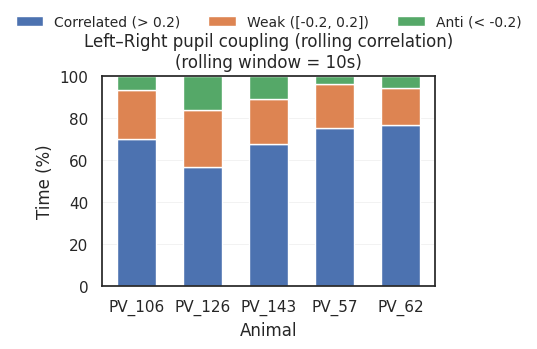

In [64]:
# === Per-animal time fractions of rolling L–R pupil correlation, with stacked bars and PDF export ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import pickle
from typing import Dict, Tuple, Optional, Union

# Vector-friendly export settings (PDF/PS fonts compatible with Illustrator)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype']  = 42
rcParams['font.family']  = 'DejaVu Sans'  # safe default; adjust if you have a house font

def pupil_correlation_stackedbars_per_animal(
    block_collection=None,
    *,
    # Data columns
    pupil_col: str = "pupil_diameter",
    time_col: str = "ms_axis",
    # Analysis params
    roll_window_s: float = 10.0,
    # Thresholds (fixed by request): correlated r>0.2; weak −0.2≤r≤0.2; anti r<−0.2
    corr_thr_pos: float = 0.2,
    corr_thr_neg: float = -0.2,
    normalize_per_block: bool = True,     # robust z-score per block
    min_valid_in_window: float = 0.33,    # fraction of samples required in a window
    # Plotting
    figsize: Tuple[int, int] = (11, 4.5),
    title: str = "Left–Right pupil coupling (rolling correlation)",
    # Export / Import
    export_path: Optional[Union[str, Path]] = None,   # folder or full file path stem
    export_basename: str = "pupil_coupling_stackedbars",
    save_pdf: bool = True,
    load_pickle: Optional[Union[str, Path]] = None,   # if provided, re-draw from pickle and ignore raw
):
    """
    Mode A (compute from raw): provide block_collection and leave load_pickle=None.
      - Computes rolling Pearson correlation between left/right pupil per block (no detrending).
      - Aggregates time-weighted fractions per animal in 3 bins:
            correlated (r > corr_thr_pos),
            weak       (corr_thr_neg <= r <= corr_thr_pos),
            anti       (r < corr_thr_neg).
      - Draws a stacked bar chart (x=animals, y=0..100%).
      - If export_path is given, saves a .pickle with per-animal data+metadata and a .pdf figure.

    Mode B (re-draw): provide load_pickle=".../file.pickle"; block_collection not required.
      - Recreates the stacked bar figure from saved data/metadata.

    Returns
    -------
    per_animal_df : pd.DataFrame with columns:
        ['animal','n_blocks','n_valid_points','frac_corr','frac_weak','frac_anti',
         'median_r','iqr_r','window_s','corr_thr_pos','corr_thr_neg','normalize_per_block',
         'min_valid_in_window']
    meta : dict with analysis parameters and version.
    """

    # ---------- helpers ----------
    def _animal_id(block) -> str:
        return getattr(block, "animal_call", None) or getattr(block, "animal", None) or "UNK"

    def _estimate_fs(ms: np.ndarray) -> float:
        d = np.diff(ms.astype(float))
        d = d[np.isfinite(d)]
        if d.size == 0: return np.nan
        med = np.median(d)
        return 1000.0/med if med > 0 else np.nan

    def _prep(block) -> Optional[pd.DataFrame]:
        ldf = getattr(block, "left_eye_data_clean", None) or getattr(block, "left_eye_data", None)
        rdf = getattr(block, "right_eye_data_clean", None) or getattr(block, "right_eye_data", None)
        if ldf is None or rdf is None: return None
        if time_col not in ldf.columns or time_col not in rdf.columns: return None
        if pupil_col not in ldf.columns or pupil_col not in rdf.columns: return None
        m = pd.merge(
            ldf[[time_col, pupil_col]].rename(columns={pupil_col: "pupil_L"}),
            rdf[[time_col, pupil_col]].rename(columns={pupil_col: "pupil_R"}),
            on=time_col, how="inner"
        ).sort_values(time_col)
        m = m.replace([np.inf, -np.inf], np.nan).dropna(subset=[time_col, "pupil_L", "pupil_R"])
        return m

    def _robust_z(df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        for c in ["pupil_L", "pupil_R"]:
            x = out[c].to_numpy()
            mu  = np.nanmedian(x)
            mad = np.nanmedian(np.abs(x - mu))
            s   = 1.4826 * mad if mad > 0 else np.nanstd(x)
            if not np.isfinite(s) or s == 0:
                s = np.nanstd(x) if np.nanstd(x) > 0 else 1.0
            out[c] = (x - mu) / s
        return out

    def _rolling_r(df: pd.DataFrame, fs: float, win_s: float) -> pd.Series:
        if not np.isfinite(fs) or win_s <= 0:
            return pd.Series(np.nan, index=df.index)
        win  = max(int(round(fs * win_s)), 5)
        minp = max(3, int(win * min_valid_in_window))
        x = df["pupil_L"]; y = df["pupil_R"]
        mu_x = x.rolling(win, center=True, min_periods=minp).mean()
        mu_y = y.rolling(win, center=True, min_periods=minp).mean()
        dx, dy = x - mu_x, y - mu_y
        cov = (dx*dy).rolling(win, center=True, min_periods=minp).mean()
        vx  = (dx*dx).rolling(win, center=True, min_periods=minp).mean()
        vy  = (dy*dy).rolling(win, center=True, min_periods=minp).mean()
        r   = cov / np.sqrt(vx*vy)
        return r

    def _build_per_animal_df_from_bins(animal_bins: Dict[str, Dict[str, float]],
                                       animal_stats: Dict[str, Dict[str, list]],
                                       animal_blocks: Dict[str, int]) -> pd.DataFrame:
        rows = []
        for animal, counts in animal_bins.items():
            total = counts["corr"] + counts["weak"] + counts["anti"]
            if total <= 0:
                continue
            rvals = np.concatenate(animal_stats[animal]["rvals"]) if animal_stats[animal]["rvals"] else np.array([])
            if rvals.size:
                q25, q50, q75 = np.percentile(rvals, [25, 50, 75])
                iqr = q75 - q25
            else:
                q50, iqr = (np.nan, np.nan)
            rows.append({
                "animal": animal,
                "n_blocks": int(animal_blocks.get(animal, 0)),
                "n_valid_points": int(total),
                "frac_corr": counts["corr"]/total,
                "frac_weak": counts["weak"]/total,
                "frac_anti": counts["anti"]/total,
                "median_r": q50,
                "iqr_r": iqr,
                "window_s": float(roll_window_s),
                "corr_thr_pos": float(corr_thr_pos),
                "corr_thr_neg": float(corr_thr_neg),
                "normalize_per_block": bool(normalize_per_block),
                "min_valid_in_window": float(min_valid_in_window),
            })
        return pd.DataFrame(rows).sort_values("animal")

    def _plot_stacked_bars(per_animal_df: pd.DataFrame):
        if per_animal_df.empty:
            print("[info] No animals with valid data.")
            return None
        animals = per_animal_df["animal"].tolist()
        # Convert to percentages
        corr_pct = (per_animal_df["frac_corr"].to_numpy() * 100.0)
        weak_pct = (per_animal_df["frac_weak"].to_numpy() * 100.0)
        anti_pct = (per_animal_df["frac_anti"].to_numpy() * 100.0)

        x = np.arange(len(animals))
        width = 0.6

        fig, ax = plt.subplots(1, 1, figsize=figsize)
        b1 = ax.bar(x, corr_pct, width, label=f"Correlated (> {corr_thr_pos:.1f})")
        b2 = ax.bar(x, weak_pct, width, bottom=corr_pct, label=f"Weak ([{corr_thr_neg:.1f}, {corr_thr_pos:.1f}])")
        b3 = ax.bar(x, anti_pct, width, bottom=corr_pct+weak_pct, label=f"Anti (< {corr_thr_neg:.1f})")

        ax.set_xticks(x)
        ax.set_xticklabels(animals, rotation=0)
        ax.set_ylim(0, 100)
        ax.set_ylabel("Time (%)")
        ax.set_xlabel("Animal")
        ax.set_title(f"{title}\n(rolling window = {roll_window_s:.0f}s)")
        ax.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.35), fontsize=10)
        ax.grid(axis="y", alpha=0.25, linewidth=0.7)
        plt.tight_layout()
        return fig

    # ---------- Mode B: re-draw from pickle ----------
    if load_pickle is not None:
        with open(load_pickle, "rb") as f:
            payload = pickle.load(f)
        per_animal_df = payload["per_animal_df"]
        meta = payload.get("meta", {})

        # use saved thresholds/window for correct labels
        roll_window_s   = float(meta.get("roll_window_s", roll_window_s))
        corr_thr_pos    = float(meta.get("corr_thr_pos", corr_thr_pos))
        corr_thr_neg    = float(meta.get("corr_thr_neg", corr_thr_neg))
        normalize_per_block = bool(meta.get("normalize_per_block", normalize_per_block))
        min_valid_in_window = float(meta.get("min_valid_in_window", min_valid_in_window))

        fig = _plot_stacked_bars(per_animal_df)

        # Optional export of the re-drawn figure (PDF)
        if export_path is not None and save_pdf and fig is not None:
            export_path = Path(export_path)
            if export_path.is_dir() or (not export_path.suffix):
                export_path.mkdir(parents=True, exist_ok=True)
                pdf_path = export_path / f"{export_basename}.pdf"
            else:
                pdf_path = export_path.with_suffix(".pdf")
                pdf_path.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
            print(f"[saved] {pdf_path}")
        return per_animal_df, meta

    # ---------- Mode A: compute from raw ----------
    if block_collection is None:
        raise ValueError("Provide block_collection (compute) or load_pickle (re-draw).")

    animal_bins: Dict[str, Dict[str, float]] = {}
    animal_stats: Dict[str, Dict[str, list]] = {}
    animal_blocks: Dict[str, int] = {}

    for block in block_collection:
        animal = _animal_id(block)
        m = _prep(block)
        if m is None or len(m) < 20:
            continue
        fs = _estimate_fs(m[time_col].to_numpy())
        if normalize_per_block:
            m = _robust_z(m)

        r = _rolling_r(m, fs, roll_window_s).replace([np.inf, -np.inf], np.nan)
        valid = r.dropna()
        if valid.empty:
            continue

        if animal not in animal_bins:
            animal_bins[animal]  = dict(corr=0.0, weak=0.0, anti=0.0)
            animal_stats[animal] = dict(rvals=[])
            animal_blocks[animal] = 0
        animal_blocks[animal] += 1

        v = valid.to_numpy()
        animal_bins[animal]["corr"] += float(np.sum(v >  corr_thr_pos))
        animal_bins[animal]["weak"] += float(np.sum((v >= corr_thr_neg) & (v <= corr_thr_pos)))
        animal_bins[animal]["anti"] += float(np.sum(v <  corr_thr_neg))
        animal_stats[animal]["rvals"].append(v)

    per_animal_df = _build_per_animal_df_from_bins(animal_bins, animal_stats, animal_blocks)
    display(per_animal_df)

    fig = _plot_stacked_bars(per_animal_df)

    # Save payload and PDF (optional)
    meta = dict(
        version="1.1-stackedbars",
        roll_window_s=float(roll_window_s),
        corr_thr_pos=float(corr_thr_pos),
        corr_thr_neg=float(corr_thr_neg),
        normalize_per_block=bool(normalize_per_block),
        min_valid_in_window=float(min_valid_in_window),
        pupil_col=str(pupil_col),
        time_col=str(time_col),
        title=str(title),
        note="No detrending applied."
    )

    if export_path is not None:
        export_path = Path(export_path)
        if export_path.is_dir() or (not export_path.suffix):
            export_path.mkdir(parents=True, exist_ok=True)
            pkl_path = export_path / f"{export_basename}.pickle"
            pdf_path = export_path / f"{export_basename}.pdf"
        else:
            export_path.parent.mkdir(parents=True, exist_ok=True)
            pkl_path = export_path.with_suffix(".pickle")
            pdf_path = export_path.with_suffix(".pdf")

        payload = {"per_animal_df": per_animal_df, "meta": meta}
        with open(pkl_path, "wb") as f:
            pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"[saved] {pkl_path}")

        if save_pdf and fig is not None:
            fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
            print(f"[saved] {pdf_path}")

    return per_animal_df, meta

# -------- Example usage --------
# A) Compute from raw and export to a folder as PDF+pickle:
per_animal_df, meta = pupil_correlation_stackedbars_per_animal(
    block_collection,
    roll_window_s=10.0,
    export_path=r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\supplementary\pupil_correlation_fig\barplot",   # folder or full file path stem
    export_basename="lr_pupil_coupling_bars",
    figsize=(5,4)
)

# B) Re-draw later (reviewer replication) using only the pickle (no raw data):
# per_animal_df2, meta2 = pupil_correlation_stackedbars_per_animal(
#     block_collection=None,
#     load_pickle=r"Z:\path\to\analysis\coupling_bars\lr_pupil_coupling_bars.pickle",
#     export_path=r"Z:\path\to\analysis\coupling_bars\lr_pupil_coupling_bars_redraw.pdf",  # optional
# )


=== All epochs (sorted) ===


,animal,n_blocks,n_valid_points,frac_corr,frac_weak,frac_anti,median_r,iqr_r
0,PV_62,2,187141,0.764905,0.175734,0.059362,0.534427,0.523687
1,PV_106,5,315918,0.700226,0.231709,0.068065,0.441840,0.526055
2,PV_143,4,167337,0.674137,0.214412,0.111452,0.496867,0.685170
3,PV_126,6,550622,0.566596,0.270616,0.162789,0.285857,0.649722


=== Active epochs (same order) ===


,animal,n_blocks,n_valid_points,frac_corr,frac_weak,frac_anti,median_r,iqr_r
0,PV_62,2,6882,0.938826,0.044028,0.017146,0.817971,0.166673
1,PV_106,4,19874,0.938362,0.048807,0.012831,0.636157,0.319285
2,PV_143,4,13697,0.986493,0.010513,0.002993,0.809456,0.197024
3,PV_126,5,27788,0.835541,0.140132,0.024327,0.536670,0.421582


=== Quiet epochs (same order) ===


,animal,n_blocks,n_valid_points,frac_corr,frac_weak,frac_anti,median_r,iqr_r
0,PV_62,2,180259,0.758264,0.180762,0.060973,0.523582,0.523474
1,PV_106,5,290828,0.684002,0.245207,0.070791,0.420721,0.527521
2,PV_143,4,153640,0.646290,0.232589,0.121121,0.438992,0.691603
3,PV_126,6,484854,0.560515,0.270747,0.168737,0.277157,0.652427


[saved] Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\supplementary\pupil_correlation_fig\barplot\lr_pupil_coupling_state_bars_sorted.pickle
[saved] Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\supplementary\pupil_correlation_fig\barplot\lr_pupil_coupling_state_bars_sorted.pdf


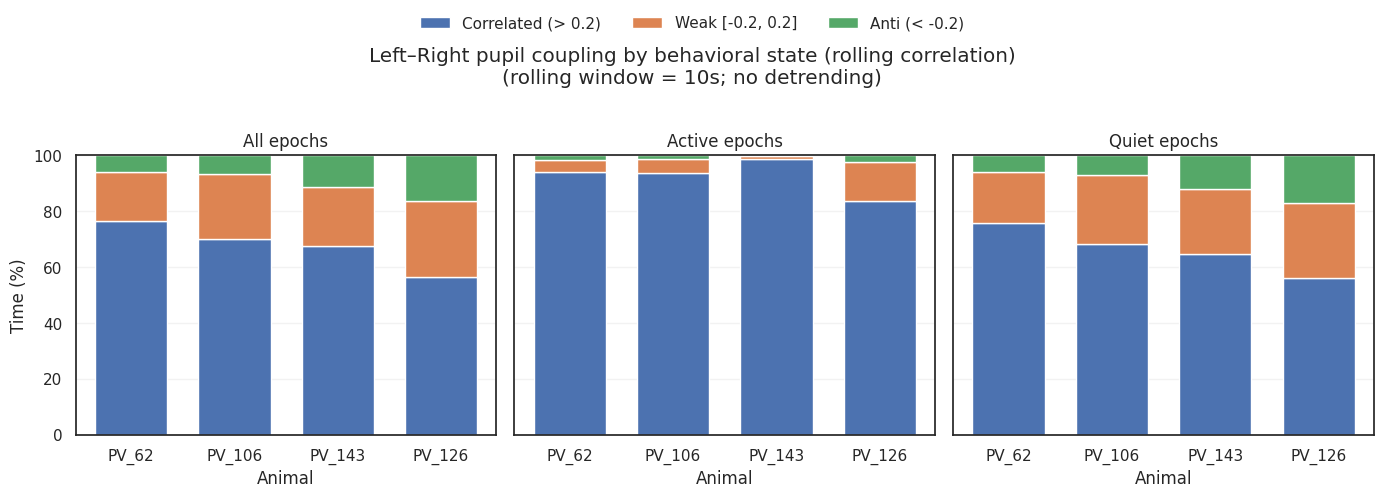

In [97]:
# === Per-animal time fractions of rolling L–R pupil correlation, split by behavior state ===
# === Per-animal time fractions of rolling L–R pupil correlation by state
#     Robust behavior_state column handling + sorted stacked bars + PDF/pickle export ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import pickle
from typing import Dict, Tuple, Optional, Union

# Illustrator-friendly vector export
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype']  = 42
rcParams['font.family']  = 'DejaVu Sans'

def pupil_correlation_state_stackedbars_per_animal(
    block_collection=None,
    *,
    # Data columns
    pupil_col: str = "pupil_diameter",
    time_col: str = "ms_axis",
    behavior_attr: str = "behavior_state",
    # Analysis params
    roll_window_s: float = 10.0,
    corr_thr_pos: float = 0.2,    # correlated if r > +0.2
    corr_thr_neg: float = -0.2,   # anti if r < -0.2; weak otherwise
    normalize_per_block: bool = True,   # robust z per block
    min_valid_in_window: float = 0.33,  # required fraction of samples per window
    # Plotting
    figsize: Tuple[int, int] = (14, 4.5),
    title: str = "Left–Right pupil coupling by behavioral state (rolling correlation)",
    sort_desc_by_corr_all: bool = True,  # sort animals by 'All' correlated fraction (descending)
    # Export / Import
    export_path: Optional[Union[str, Path]] = None,    # folder or file stem
    export_basename: str = "lr_pupil_coupling_state_bars",
    save_pdf: bool = True,
    load_pickle: Optional[Union[str, Path]] = None,    # if provided, redraw from pickle
):
    """
    Mode A (compute from raw):
      - Rolling Pearson r (no detrending), robust z per block.
      - Label windows as All / Active / Quiet using behavior_state intervals.
      - Bins r into correlated (r>0.2), weak (-0.2..0.2), anti (r<-0.2).
      - Stacked bars for All, Active, Quiet.
      - Animals sorted by 'All' correlated fraction (descending by default).

    Mode B (redraw): provide load_pickle and optional export_path for PDF.
    """

    # ---------- helpers ----------
    def _animal_id(block) -> str:
        return getattr(block, "animal_call", None) or getattr(block, "animal", None) or "UNK"

    def _block_id(block) -> str:
        a = _animal_id(block)
        b = getattr(block, "block_num", None)
        try:
            bstr = f"{int(b):03d}"
        except (TypeError, ValueError):
            bstr = str(b)
        return f"{a}_B{bstr}"

    def _estimate_fs(ms: np.ndarray) -> float:
        d = np.diff(ms.astype(float))
        d = d[np.isfinite(d)]
        if d.size == 0: return np.nan
        med = np.median(d)
        return 1000.0/med if med > 0 else np.nan

    def _prep_eye(block) -> Optional[pd.DataFrame]:
        ldf = getattr(block, "left_eye_data_clean", None) or getattr(block, "left_eye_data", None)
        rdf = getattr(block, "right_eye_data_clean", None) or getattr(block, "right_eye_data", None)
        if ldf is None or rdf is None: return None
        if time_col not in ldf.columns or time_col not in rdf.columns: return None
        if pupil_col not in ldf.columns or pupil_col not in rdf.columns: return None
        m = pd.merge(
            ldf[[time_col, pupil_col]].rename(columns={pupil_col: "pupil_L"}),
            rdf[[time_col, pupil_col]].rename(columns={pupil_col: "pupil_R"}),
            on=time_col, how="inner"
        ).sort_values(time_col)
        m = m.replace([np.inf, -np.inf], np.nan).dropna(subset=[time_col, "pupil_L", "pupil_R"])
        return m

    def _robust_z(df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        for c in ["pupil_L", "pupil_R"]:
            x = out[c].to_numpy()
            mu  = np.nanmedian(x)
            mad = np.nanmedian(np.abs(x - mu))
            s   = 1.4826 * mad if mad > 0 else np.nanstd(x)
            if not np.isfinite(s) or s == 0:
                s = np.nanstd(x) if np.nanstd(x) > 0 else 1.0
            out[c] = (x - mu) / s
        return out

    def _rolling_r(df: pd.DataFrame, fs: float, win_s: float) -> pd.Series:
        if not np.isfinite(fs) or win_s <= 0:
            return pd.Series(np.nan, index=df.index)
        win  = max(int(round(fs * win_s)), 5)
        minp = max(3, int(win * min_valid_in_window))
        x = df["pupil_L"]; y = df["pupil_R"]
        mu_x = x.rolling(win, center=True, min_periods=minp).mean()
        mu_y = y.rolling(win, center=True, min_periods=minp).mean()
        dx, dy = x - mu_x, y - mu_y
        cov = (dx*dy).rolling(win, center=True, min_periods=minp).mean()
        vx  = (dx*dx).rolling(win, center=True, min_periods=minp).mean()
        vy  = (dy*dy).rolling(win, center=True, min_periods=minp).mean()
        r   = cov / np.sqrt(vx*vy)
        return r

    # --- robust behavior_state reader: supports *_ms OR start/end (assumed ms; try ×1000 if needed) ---
    def _state_intervals_ms(block, t_ms: np.ndarray) -> Optional[pd.DataFrame]:
        bs = getattr(block, behavior_attr, None)
        if not isinstance(bs, pd.DataFrame) or bs is None or bs.empty:
            return None

        df = bs.copy()
        # Normalize 'annotation'
        if "annotation" not in df.columns:
            return None
        df["annotation"] = df["annotation"].astype(str).str.strip().str.lower()

        # Prefer *_ms if present
        if {"start_time_ms","end_time_ms"}.issubset(df.columns):
            st = pd.to_numeric(df["start_time_ms"], errors="coerce")
            en = pd.to_numeric(df["end_time_ms"], errors="coerce")
        elif {"start_time","end_time"}.issubset(df.columns):
            st = pd.to_numeric(df["start_time"], errors="coerce")
            en = pd.to_numeric(df["end_time"], errors="coerce")
            # Try as-is; if essentially no overlap with t_ms range, fallback to ×1000
            tmin, tmax = float(np.nanmin(t_ms)), float(np.nanmax(t_ms))
            def _overlap(a, b):
                a = a.to_numpy(); b = b.to_numpy()
                ok = np.isfinite(a) & np.isfinite(b)
                if not ok.any(): return 0.0
                segs = np.c_[np.maximum(tmin, np.minimum(a[ok], b[ok])),
                             np.minimum(tmax, np.maximum(a[ok], b[ok]))]
                segs = segs[segs[:,1] > segs[:,0]]
                if segs.size == 0: return 0.0
                segs = segs[np.argsort(segs[:,0])]
                merged = [segs[0]]
                for s,e in segs[1:]:
                    if s <= merged[-1][1]:
                        merged[-1][1] = max(merged[-1][1], e)
                    else:
                        merged.append([s,e])
                covered = np.sum(np.array(merged)[:,1] - np.array(merged)[:,0])
                return float(covered / (tmax - tmin)) if tmax > tmin else 0.0
            frac_as_is = _overlap(st, en)
            frac_x1000 = _overlap(st*1000.0, en*1000.0)
            if frac_x1000 > frac_as_is:
                st, en = st*1000.0, en*1000.0
        else:
            return None

        out = pd.DataFrame({"start_ms": st, "end_ms": en, "annotation": df["annotation"]})
        out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=["start_ms","end_ms","annotation"])
        # Keep only active/quiet
        out = out[out["annotation"].isin(["active","quiet"])]
        if out.empty:
            return None
        return out

    def _label_states(t_ms: np.ndarray, intervals: Optional[pd.DataFrame]) -> np.ndarray:
        labels = np.full(t_ms.shape, "unknown", dtype=object)
        if intervals is None or intervals.empty: return labels
        for _, row in intervals.iterrows():
            s = float(row["start_ms"]); e = float(row["end_ms"])
            if not np.isfinite(s) or not np.isfinite(e): continue
            if e <= s: continue
            annot = row["annotation"]
            mask = (t_ms >= s) & (t_ms < e)
            labels[mask] = annot
        return labels

    def _build_per_animal_df_from_bins(animal_bins: Dict[str, Dict[str, float]],
                                       animal_stats: Dict[str, Dict[str, list]],
                                       animal_blocks: Dict[str, int]) -> pd.DataFrame:
        rows = []
        for animal, counts in animal_bins.items():
            total = counts["corr"] + counts["weak"] + counts["anti"]
            if total <= 0:
                continue
            rvals = np.concatenate(animal_stats[animal]["rvals"]) if animal_stats[animal]["rvals"] else np.array([])
            if rvals.size:
                q25, q50, q75 = np.percentile(rvals, [25, 50, 75])
                iqr = q75 - q25
            else:
                q50, iqr = (np.nan, np.nan)
            rows.append({
                "animal": animal,
                "n_blocks": int(animal_blocks.get(animal, 0)),
                "n_valid_points": int(total),
                "frac_corr": counts["corr"]/total,
                "frac_weak": counts["weak"]/total,
                "frac_anti": counts["anti"]/total,
                "median_r": q50,
                "iqr_r": iqr,
            })
        return pd.DataFrame(rows).sort_values("animal")

    def _plot_three(df_all, df_act, df_q, animals_order):
        # Reindex to common order; missing animals → zeros
        def _reindex(df):
            if df.empty:
                return pd.DataFrame({"animal": animals_order,
                                     "frac_corr": 0.0, "frac_weak": 0.0, "frac_anti": 0.0}).set_index("animal")
            return (df.set_index("animal")
                      .reindex(animals_order)
                      .fillna({"frac_corr":0.0,"frac_weak":0.0,"frac_anti":0.0}))
        A = _reindex(df_all); B = _reindex(df_act); C = _reindex(df_q)

        def _panel(ax, D, subtitle):
            corr = (D["frac_corr"].to_numpy() * 100.0)
            weak = (D["frac_weak"].to_numpy() * 100.0)
            anti = (D["frac_anti"].to_numpy() * 100.0)
            x = np.arange(len(D))
            w = 0.7
            ax.bar(x, corr, w, label=f"Correlated (> {corr_thr_pos:.1f})")
            ax.bar(x, weak, w, bottom=corr, label=f"Weak [{corr_thr_neg:.1f}, {corr_thr_pos:.1f}]")
            ax.bar(x, anti, w, bottom=corr+weak, label=f"Anti (< {corr_thr_neg:.1f})")
            ax.set_xticks(x); ax.set_xticklabels(D.index.tolist(), rotation=0)
            ax.set_ylim(0, 100); ax.set_xlabel("Animal"); ax.set_title(subtitle); ax.grid(axis="y", alpha=0.25)

        fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
        _panel(axes[0], A, "All epochs")
        _panel(axes[1], B, "Active epochs")
        _panel(axes[2], C, "Quiet epochs")
        axes[0].set_ylabel("Time (%)")
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.12))
        fig.suptitle(f"{title}\n(rolling window = {roll_window_s:.0f}s; no detrending)", y=1.02)
        plt.tight_layout()
        return fig

    # ---------- redraw from pickle ----------
    if load_pickle is not None:
        with open(load_pickle, "rb") as f:
            payload = pickle.load(f)
        per_animal_all    = payload["per_animal_all"]
        per_animal_active = payload["per_animal_active"]
        per_animal_quiet  = payload["per_animal_quiet"]
        animals_order     = payload["animals_order"]
        meta              = payload.get("meta", {})
        fig = _plot_three(per_animal_all, per_animal_active, per_animal_quiet, animals_order)
        if export_path is not None and save_pdf and fig is not None:
            export_path = Path(export_path)
            pdf_path = (export_path / f"{export_basename}.pdf") if (export_path.is_dir() or not export_path.suffix) else export_path.with_suffix(".pdf")
            pdf_path.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
            print(f"[saved] {pdf_path}")
        return per_animal_all, per_animal_active, per_animal_quiet, {"animals_order": animals_order, **meta}

    # ---------- compute from raw ----------
    if block_collection is None:
        raise ValueError("Provide block_collection (compute) or load_pickle (re-draw).")

    # Three accumulators
    animal_bins_all: Dict[str, Dict[str, float]] = {}
    animal_bins_act: Dict[str, Dict[str, float]] = {}
    animal_bins_q:   Dict[str, Dict[str, float]] = {}

    animal_stats_all: Dict[str, Dict[str, list]] = {}
    animal_stats_act: Dict[str, Dict[str, list]] = {}
    animal_stats_q:   Dict[str, Dict[str, list]] = {}

    animal_blocks_all: Dict[str, int] = {}
    animal_blocks_act: Dict[str, int] = {}
    animal_blocks_q:   Dict[str, int] = {}

    for block in block_collection:
        bid = _block_id(block)
        animal = _animal_id(block)
        m = _prep_eye(block)
        if m is None or len(m) < 20:
            continue
        t_ms = m[time_col].to_numpy().astype(float)
        fs = _estimate_fs(t_ms)

        # Get state intervals in ms (robust to column naming)
        intervals = _state_intervals_ms(block, t_ms)
        # Label each sample with state
        labels = _label_states(t_ms, intervals)
        m = m.copy(); m["state"] = labels

        if normalize_per_block:
            m = _robust_z(m)

        r = _rolling_r(m, fs, roll_window_s).replace([np.inf, -np.inf], np.nan)
        valid = r.dropna()
        if valid.empty:
            continue

        v = valid.to_numpy()
        state_valid = m.loc[valid.index, "state"].to_numpy()

        # init helper
        def _init(name, bins_dict, stats_dict, blocks_dict):
            if name not in bins_dict:
                bins_dict[name]  = dict(corr=0.0, weak=0.0, anti=0.0)
                stats_dict[name] = dict(rvals=[])
                blocks_dict[name] = 0

        # ALL
        _init(animal, animal_bins_all, animal_stats_all, animal_blocks_all)
        animal_blocks_all[animal] += 1
        animal_bins_all[animal]["corr"] += float(np.sum(v >  corr_thr_pos))
        animal_bins_all[animal]["weak"] += float(np.sum((v >= corr_thr_neg) & (v <= corr_thr_pos)))
        animal_bins_all[animal]["anti"] += float(np.sum(v <  corr_thr_neg))
        animal_stats_all[animal]["rvals"].append(v)

        # ACTIVE
        mask_act = (state_valid == "active")
        if np.any(mask_act):
            _init(animal, animal_bins_act, animal_stats_act, animal_blocks_act)
            animal_blocks_act[animal] += 1
            va = v[mask_act]
            animal_bins_act[animal]["corr"] += float(np.sum(va >  corr_thr_pos))
            animal_bins_act[animal]["weak"] += float(np.sum((va >= corr_thr_neg) & (va <= corr_thr_pos)))
            animal_bins_act[animal]["anti"] += float(np.sum(va <  corr_thr_neg))
            animal_stats_act[animal]["rvals"].append(va)

        # QUIET
        mask_q = (state_valid == "quiet")
        if np.any(mask_q):
            _init(animal, animal_bins_q, animal_stats_q, animal_blocks_q)
            animal_blocks_q[animal] += 1
            vq = v[mask_q]
            animal_bins_q[animal]["corr"] += float(np.sum(vq >  corr_thr_pos))
            animal_bins_q[animal]["weak"] += float(np.sum((vq >= corr_thr_neg) & (vq <= corr_thr_pos)))
            animal_bins_q[animal]["anti"] += float(np.sum(vq <  corr_thr_neg))
            animal_stats_q[animal]["rvals"].append(vq)

    per_animal_all    = _build_per_animal_df_from_bins(animal_bins_all, animal_stats_all, animal_blocks_all)
    per_animal_active = _build_per_animal_df_from_bins(animal_bins_act, animal_stats_act, animal_blocks_act)
    per_animal_quiet  = _build_per_animal_df_from_bins(animal_bins_q,  animal_stats_q,  animal_blocks_q)

    # --- sort animals by 'All' correlated fraction (desc by default) ---
    if per_animal_all.empty:
        print("[info] No animals with valid data.")
        animals_order = []
    else:
        key = per_animal_all.set_index("animal")["frac_corr"]
        animals_order = key.sort_values(ascending=not sort_desc_by_corr_all).index.tolist()

    print("=== All epochs (sorted) ===")
    display(per_animal_all.set_index("animal").reindex(animals_order).reset_index())
    print("=== Active epochs (same order) ===")
    display(per_animal_active.set_index("animal").reindex(animals_order).reset_index())
    print("=== Quiet epochs (same order) ===")
    display(per_animal_quiet.set_index("animal").reindex(animals_order).reset_index())

    fig = _plot_three(per_animal_all, per_animal_active, per_animal_quiet, animals_order)

    meta = dict(
        version="1.1-state-split-robust",
        roll_window_s=float(roll_window_s),
        corr_thr_pos=float(corr_thr_pos),
        corr_thr_neg=float(corr_thr_neg),
        normalize_per_block=bool(normalize_per_block),
        min_valid_in_window=float(min_valid_in_window),
        pupil_col=str(pupil_col),
        time_col=str(time_col),
        behavior_attr=str(behavior_attr),
        title=str(title),
        sort_desc_by_corr_all=bool(sort_desc_by_corr_all),
        note="Behavior_state accepted from *_ms or start/end (ms, with ×1000 fallback if needed)."
    )

    if export_path is not None:
        export_path = Path(export_path)
        if export_path.is_dir() or (not export_path.suffix):
            export_path.mkdir(parents=True, exist_ok=True)
            pkl_path = export_path / f"{export_basename}.pickle"
            pdf_path = export_path / f"{export_basename}.pdf"
        else:
            export_path.parent.mkdir(parents=True, exist_ok=True)
            pkl_path = export_path.with_suffix(".pickle")
            pdf_path = export_path.with_suffix(".pdf")

        payload = {
            "per_animal_all": per_animal_all,
            "per_animal_active": per_animal_active,
            "per_animal_quiet": per_animal_quiet,
            "animals_order": animals_order,
            "meta": meta,
        }
        with open(pkl_path, "wb") as f:
            pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"[saved] {pkl_path}")

        if save_pdf and fig is not None:
            fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
            print(f"[saved] {pdf_path}")

    return per_animal_all, per_animal_active, per_animal_quiet, {"animals_order": animals_order, **meta}

# -------- Example usage --------
blocks = [i for i in block_collection if "PV_57" not in str(i)]
per_all, per_act, per_q, meta = pupil_correlation_state_stackedbars_per_animal(
    blocks,
    roll_window_s=10.0,
    export_path=r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\supplementary\pupil_correlation_fig\barplot",
    export_basename="lr_pupil_coupling_state_bars_sorted",
    sort_desc_by_corr_all=True,   # highest 'correlated' % at left
)
# # Redraw later:
# # per_all2, per_act2, per_q2, meta2 = pupil_correlation_state_stackedbars_per_animal(
# #     block_collection=None,
# #     load_pickle=r"Z:\path\to\analysis\coupling_state_bars_sorted\lr_pupil_coupling_state_bars_sorted.pickle",
# #     export_path=r"Z:\path\to\analysis\coupling_state_bars_sorted\lr_pupil_coupling_state_bars_sorted_redraw.pdf",
# # )




Per-second table: (32264, 7), animals=5


,animal,n_seconds,mean_hz,median_hz,std_hz,iqr_hz,p90_hz,p95_hz,p99_hz,max_hz,frac_zeros,frac_ge_1Hz,frac_ge_2Hz,frac_ge_4Hz,cv
0,PV_57,4202,2.336982,1.0,3.551801,4.0,6.0,9.0,17.0,30.0,0.483341,0.516659,0.445026,0.260828,1.519824
1,PV_106,6751,0.892016,0.0,2.153663,1.0,3.0,5.0,11.0,25.0,0.733965,0.266035,0.179825,0.084580,2.414377
2,PV_126,13013,0.548528,0.0,1.839607,0.0,2.0,4.0,10.0,26.0,0.850688,0.149312,0.109275,0.053331,3.353713
3,PV_143,5059,0.564538,0.0,1.787532,0.0,2.0,4.0,9.0,28.0,0.832971,0.167029,0.115438,0.052975,3.166360
4,PV_62,3239,0.776783,0.0,1.564114,1.0,3.0,4.0,7.0,13.0,0.707317,0.292683,0.214264,0.061747,2.013579


,animal,n_seconds,mean_hz,median_hz,std_hz,iqr_hz,p90_hz,p95_hz,p99_hz,max_hz,frac_zeros,frac_ge_1Hz,frac_ge_2Hz,frac_ge_4Hz,cv
0,PV_106,169,3.550296,2.0,3.675711,6.0,9.0,10.0,13.0,15.0,0.331361,0.668639,0.556213,0.431953,1.035325
1,PV_126,1000,0.706000,0.0,2.065873,0.0,3.0,5.0,11.0,16.0,0.831000,0.169000,0.138000,0.072000,2.926166


,animal,n_seconds,mean_hz,median_hz,std_hz,iqr_hz,p90_hz,p95_hz,p99_hz,max_hz,frac_zeros,frac_ge_1Hz,frac_ge_2Hz,frac_ge_4Hz,cv
0,PV_106,213813,0.014026,0.0,0.291282,0.0,0.0,0.0,0.0,18.0,0.995814,0.004186,0.002839,0.001338,20.766889
1,PV_126,519000,0.004553,0.0,0.160444,0.0,0.0,0.0,0.0,19.0,0.998674,0.001326,0.000996,0.000474,35.239321
2,PV_62,123000,0.019146,0.0,0.274202,0.0,0.0,0.0,0.0,13.0,0.992780,0.007220,0.005252,0.001512,14.321391


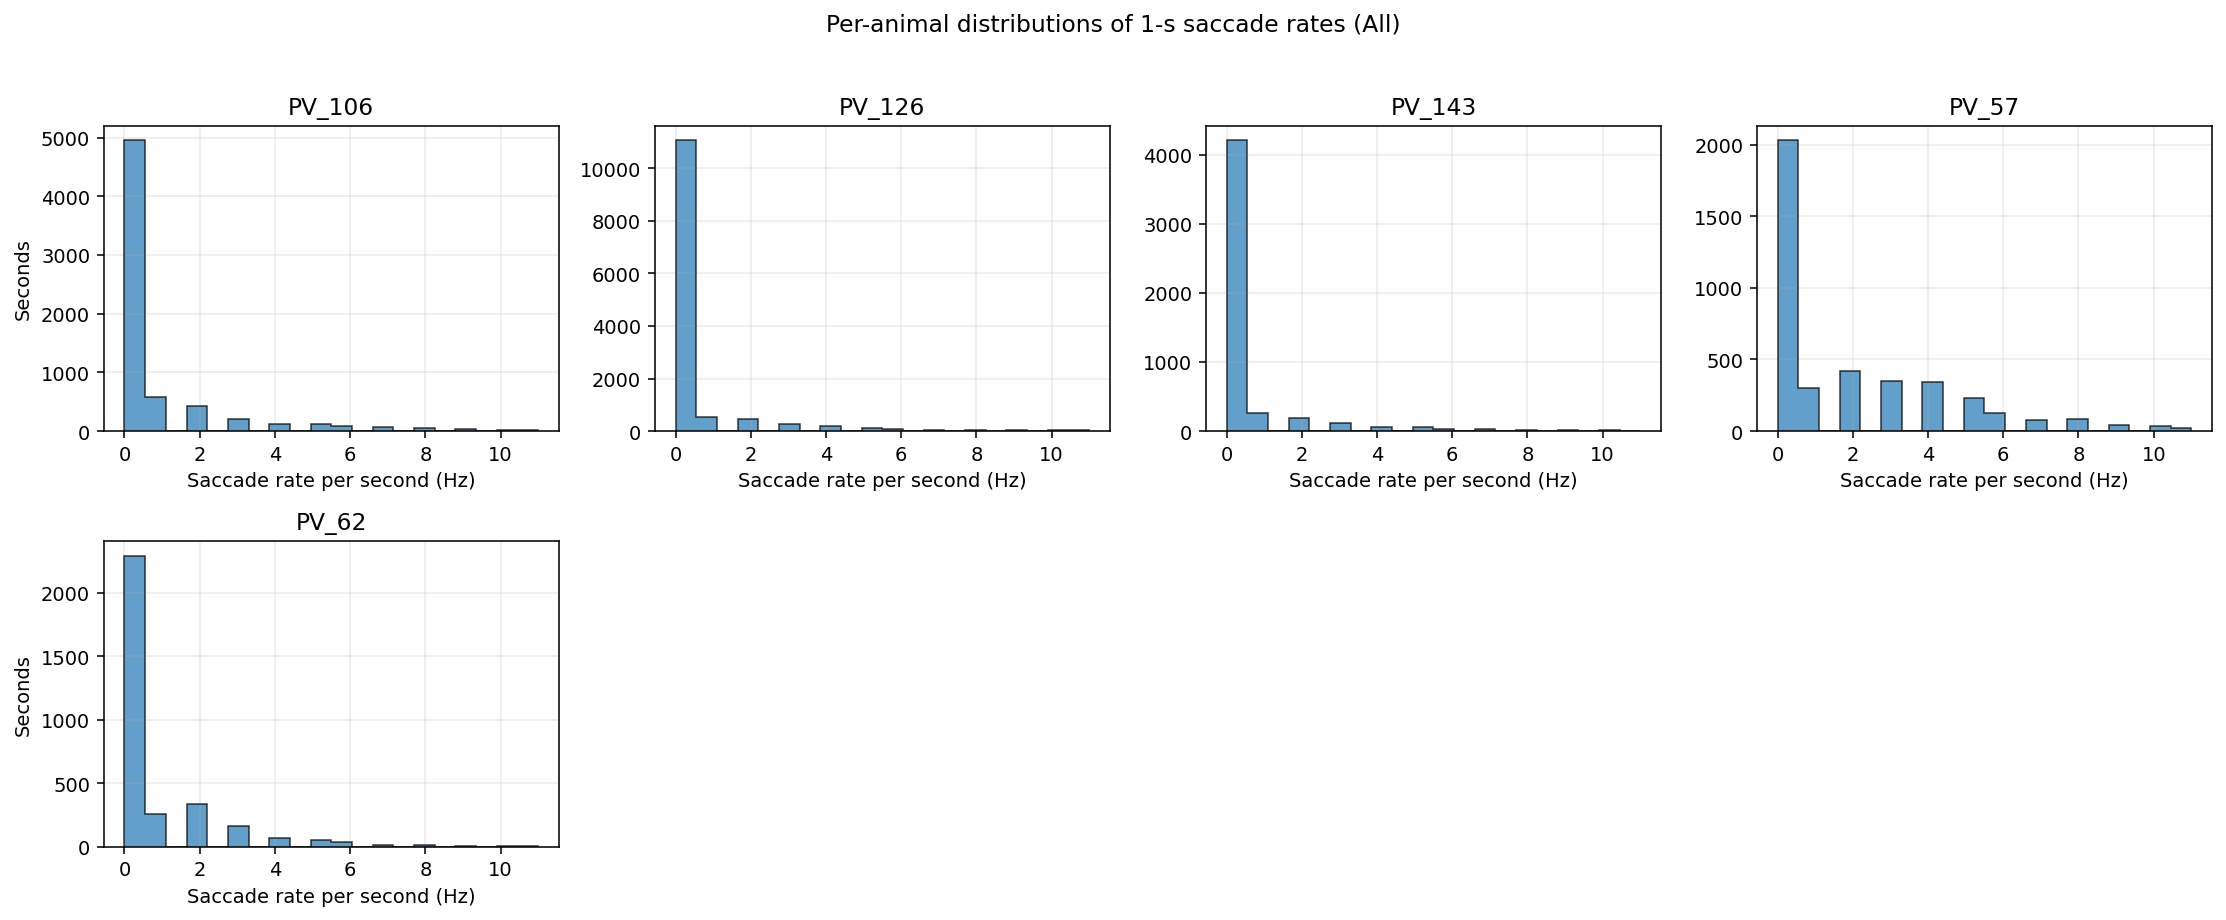

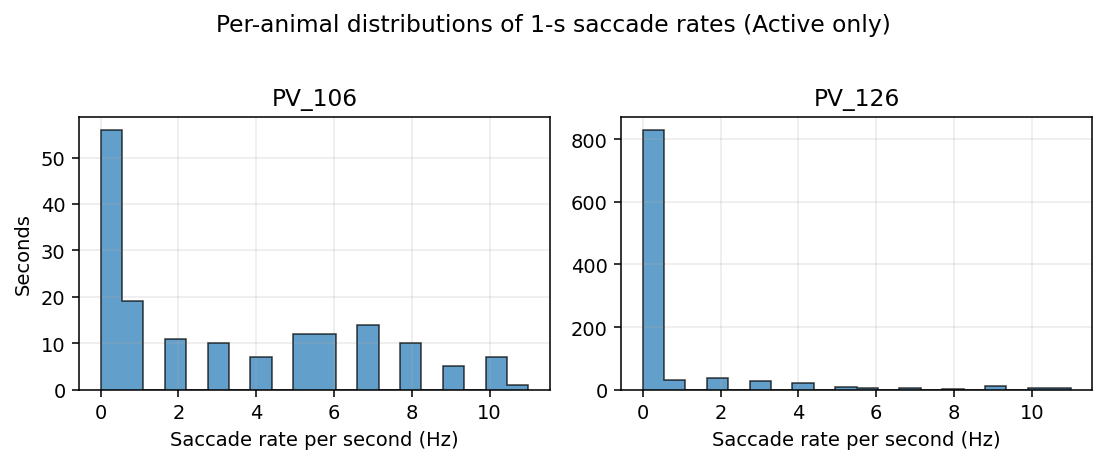

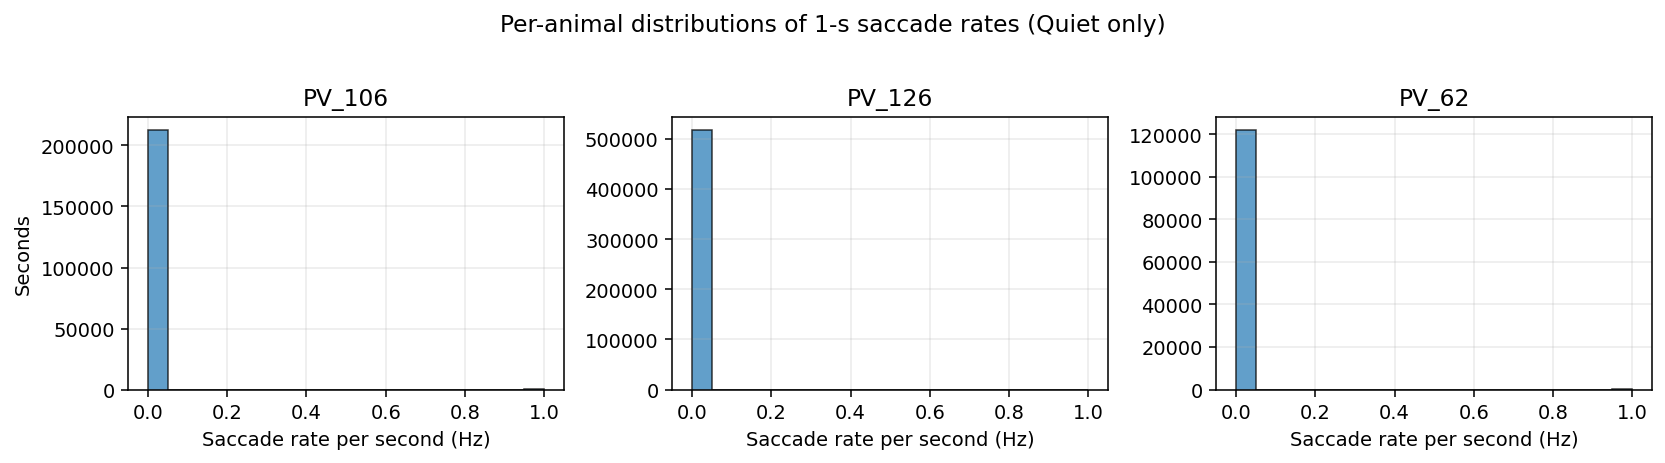

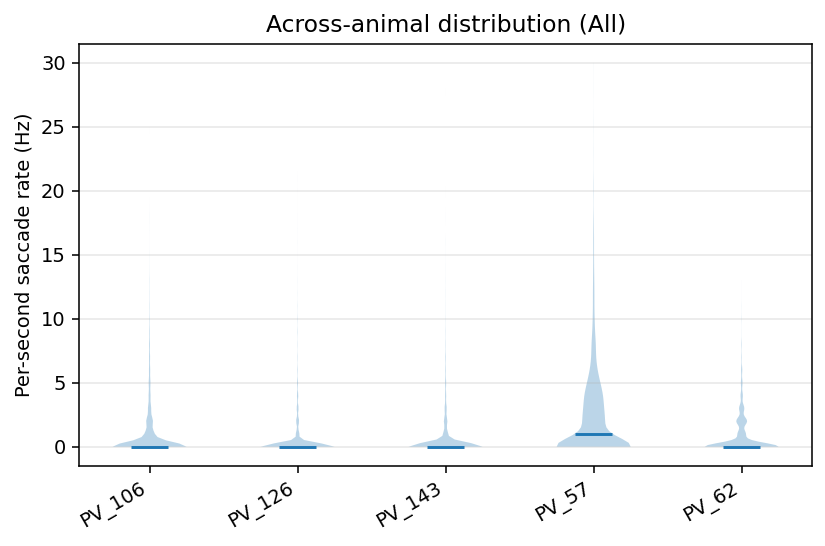

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import ceil

# =========================
# Per-animal aggregation of 1-s rates
# =========================

# ---------- helpers reused ----------
def _as_sorted_ms_1d(x):
    if x is None:
        return np.array([], dtype=float)
    arr = np.asarray(x, dtype=float).ravel()
    arr = arr[np.isfinite(arr)]
    return np.sort(arr)

def _get_animal_id(block):
    for attr in ('animal','Animal','subject','Subject'):
        if hasattr(block, attr) and getattr(block, attr) is not None:
            return str(getattr(block, attr))
    p = getattr(block, 'analysis_path', None)
    if p is not None:
        parts = [str(x) for x in Path(p).parts]
        for part in reversed(parts):
            if part.startswith('PV_'):
                return part
    return 'UnknownAnimal'

def _pick_ms_column_canonical(df):
    """Strict: use only 'saccade_on_ms' if present; else return empty."""
    if df is None or len(df) == 0:
        return np.array([], dtype=float)
    if 'saccade_on_ms' in df.columns:
        return _as_sorted_ms_1d(df['saccade_on_ms'].values)
    return np.array([], dtype=float)

def extract_block_onsets_ms_both_eyes(block):
    L = _pick_ms_column_canonical(getattr(block, 'l_saccade_df', None))
    R = _pick_ms_column_canonical(getattr(block, 'r_saccade_df', None))
    return np.sort(np.unique(np.concatenate([L, R])))

def compute_per_second_rates(events_ms, start_ms=None, end_ms=None):
    ev = _as_sorted_ms_1d(events_ms)
    if ev.size == 0:
        return pd.DataFrame(columns=['sec_start_s','sec_end_s','count','rate_hz'])
    if start_ms is None:
        start_ms = np.floor(ev.min() / 1000.0) * 1000.0
    if end_ms is None:
        end_ms = np.ceil(ev.max() / 1000.0) * 1000.0
    if end_ms <= start_ms:
        return pd.DataFrame(columns=['sec_start_s','sec_end_s','count','rate_hz'])
    edges = np.arange(start_ms, end_ms + 1000.0, 1000.0, dtype=float)
    counts, _ = np.histogram(ev, bins=edges)
    starts = edges[:-1]
    ends   = edges[1:]
    df = pd.DataFrame({
        'sec_start_s': starts / 1000.0,
        'sec_end_s':   ends   / 1000.0,
        'count':       counts.astype(int)
    })
    df['rate_hz'] = df['count'].astype(float)
    return df

def _canonical_state_name(s):
    if s is None:
        return None
    s = str(s).strip().lower()
    mapping = {
        'active':'Active', 'explores':'Active',
        'quiet':'Quiet', 'quiescent':'Quiet', 'quite':'Quiet', 'stationary':'Quiet', 'rest':'Quiet', 'still':'Quiet'
    }
    return mapping.get(s, s.capitalize())

def _coerce_behavior_to_ms(beh_df):
    """Return DataFrame with ['state','start_ms','end_ms'] if possible; else None."""
    if beh_df is None or len(beh_df)==0:
        return None
    cols = {c.lower(): c for c in beh_df.columns}
    lab = cols.get('annotation') or cols.get('state') or cols.get('label') or cols.get('behavior')
    if lab is None:
        return None
    if ('start_time_ms' in cols) and ('end_time_ms' in cols):
        tmp = beh_df[[lab, cols['start_time_ms'], cols['end_time_ms']]].copy()
        tmp.columns = ['state','start_ms','end_ms']
    elif ('start_time' in cols) and ('end_time' in cols):
        tmp = beh_df[[lab, cols['start_time'], cols['end_time']]].copy()
        tmp.columns = ['state','start_s','end_s']
        tmp['start_ms'] = tmp['start_s'].astype(float)*1000.0
        tmp['end_ms']   = tmp['end_s'].astype(float)*1000.0
        tmp = tmp[['state','start_ms','end_ms']]
    else:
        return None
    tmp['state'] = tmp['state'].map(_canonical_state_name)
    tmp = tmp[np.isfinite(tmp['start_ms']) & np.isfinite(tmp['end_ms']) & (tmp['end_ms']>tmp['start_ms'])]
    if tmp.empty:
        return None
    return tmp.sort_values('start_ms', kind='stable').reset_index(drop=True)

# ---------- core aggregation ----------
def build_per_second_table_across_blocks(
    block_collection,
    restrict_to_states=None,   # e.g. ('Active','Quiet') or None for full recording
    min_epoch_ms=1000          # require at least 1s epochs
):
    """
    Returns a tidy table with columns:
      ['animal','block','sec_start_s','sec_end_s','count','rate_hz','state']
    where 'state' is the behavior label if restricted, else 'All'.
    """
    rows = []
    for b in block_collection:
        animal = _get_animal_id(b)
        block_num = getattr(b, 'block_num', None)
        ev_ms = extract_block_onsets_ms_both_eyes(b)
        if ev_ms.size == 0:
            continue

        if restrict_to_states is None:
            # entire recording bounds from events
            df = compute_per_second_rates(ev_ms)
            if df.empty:
                continue
            df['animal'] = animal
            df['block'] = block_num
            df['state'] = 'All'
            rows.append(df)
        else:
            beh = _coerce_behavior_to_ms(getattr(b, 'behavior_state', None))
            if beh is None:
                # silently skip blocks lacking behavior when restriction is requested
                continue
            beh = beh[beh['state'].isin([_canonical_state_name(s) for s in restrict_to_states])]
            for _, r in beh.iterrows():
                a, z = float(r['start_ms']), float(r['end_ms'])
                if (z - a) < min_epoch_ms:
                    continue
                # per-second inside epoch
                ev_seg = ev_ms[(ev_ms >= a) & (ev_ms < z)]
                df = compute_per_second_rates(ev_seg, start_ms=a, end_ms=z)
                if df.empty:
                    continue
                df['animal'] = animal
                df['block'] = block_num
                df['state'] = r['state']
                rows.append(df)

    if not rows:
        return pd.DataFrame(columns=['animal','block','sec_start_s','sec_end_s','count','rate_hz','state'])
    out = pd.concat(rows, ignore_index=True)
    # ensure tidy dtypes
    out['animal'] = out['animal'].astype(str)
    out['block'] = out['block'].astype(object)
    out['state'] = out['state'].astype(str)
    return out[['animal','block','sec_start_s','sec_end_s','count','rate_hz','state']]

# ---------- plotting ----------
def plot_per_animal_histograms(
    rates_df,
    n_bins=20,
    density=False,            # counts by default; set True for density
    share_x=True,
    state='All',              # plot only this state (e.g., 'All', 'Active', 'Quiet')
    suptitle=None
):
    df = rates_df.copy()
    df = df[df['state'] == state]
    if df.empty:
        print(f"No data to plot for state={state}")
        return None

    animals = sorted(df['animal'].unique())
    # determine common x-range (optional share)
    if share_x:
        vmax = np.percentile(df['rate_hz'], 99) if len(df) > 50 else df['rate_hz'].max()
        vmax = max(vmax, 1.0)
        bins = np.linspace(0, vmax, n_bins+1)
    else:
        bins = None  # will compute per-panel

    nA = len(animals)
    ncols = min(4, nA)
    nrows = int(ceil(nA / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows), dpi=140, squeeze=False)
    axes = axes.ravel()

    for i, a in enumerate(animals):
        ax = axes[i]
        vals = df.loc[df['animal']==a, 'rate_hz'].to_numpy()
        if bins is None:
            vmax = np.percentile(vals, 99) if vals.size>50 else (vals.max() if vals.size else 1.0)
            vmax = max(vmax, 1.0)
            bins_local = np.linspace(0, vmax, n_bins+1)
        else:
            bins_local = bins
        ax.hist(vals, bins=bins_local, density=density, alpha=0.7, histtype='stepfilled')
        ax.hist(vals, bins=bins_local, density=density, histtype='step', color='k', linewidth=0.8, alpha=0.75)
        ax.set_title(a)
        ax.set_xlabel('Saccade rate per second (Hz)')
        ax.grid(True, alpha=0.25)
        if i % ncols == 0:
            ax.set_ylabel('Density' if density else 'Seconds')
    # hide any empty axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=12)
    fig.tight_layout()
    return fig

# ---------- statistics ----------
def summarize_across_animals(rates_df, by_state='All'):
    """
    Compute robust, informative descriptive stats per animal (within the given state).
    Returns a tidy stats table.
    """
    df = rates_df[rates_df['state'] == by_state].copy()
    if df.empty:
        return pd.DataFrame()

    def iqr(x):
        return np.percentile(x, 75) - np.percentile(x, 25)

    def frac_zero(x):
        x = np.asarray(x); return np.mean(x == 0.0)

    def frac_ge(x, thr):
        x = np.asarray(x);
        return np.mean(x >= thr)

    out = (df.groupby('animal', as_index=False)
           .agg(
               n_seconds=('rate_hz','size'),
               mean_hz=('rate_hz','mean'),
               median_hz=('rate_hz','median'),
               std_hz=('rate_hz','std'),
               iqr_hz=('rate_hz', iqr),
               p90_hz=('rate_hz', lambda s: np.percentile(s, 90)),
               p95_hz=('rate_hz', lambda s: np.percentile(s, 95)),
               p99_hz=('rate_hz', lambda s: np.percentile(s, 99)),`
               max_hz=('rate_hz','max'),
               frac_zeros=('rate_hz', frac_zero),
               frac_ge_1Hz=('rate_hz', lambda s: frac_ge(s, 1.0)),
               frac_ge_2Hz=('rate_hz', lambda s: frac_ge(s, 2.0)),
               frac_ge_4Hz=('rate_hz', lambda s: frac_ge(s, 4.0)),
           ))
    # add CV safely
    out['cv'] = out['std_hz'] / out['mean_hz'].replace(0, np.nan)
    return out.sort_values('median_hz', ascending=False, ignore_index=True)

# ---------- optional cross-animal visualization ----------
def plot_cross_animal_violin(rates_df, by_state='All'):
    df = rates_df[rates_df['state'] == by_state].copy()
    if df.empty:
        print("No data for violin.")
        return None
    animals = sorted(df['animal'].unique())
    fig, ax = plt.subplots(figsize=(max(6, 0.8*len(animals)), 4), dpi=140)
    data = [df.loc[df['animal']==a, 'rate_hz'].to_numpy() for a in animals]
    parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)
    ax.set_xticks(np.arange(1, len(animals)+1))
    ax.set_xticklabels(animals, rotation=30, ha='right')
    ax.set_ylabel('Per-second saccade rate (Hz)')
    ax.set_title(f'Across-animal distribution ({by_state})')
    ax.grid(True, axis='y', alpha=0.3)
    fig.tight_layout()
    return fig

# =========================
# Example usage
# =========================

# 1) Build per-second table for full recordings (no behavior restriction)
rates_all = build_per_second_table_across_blocks(block_collection, restrict_to_states=None)
print(f"Per-second table: {rates_all.shape}, animals={rates_all['animal'].nunique()}")

# 2) Plot per-animal histograms (All seconds)
fig_all = plot_per_animal_histograms(
    rates_all, n_bins=20, density=False, share_x=True, state='All',
    suptitle='Per-animal distributions of 1-s saccade rates (All)'
)

# 3) Stats across animals (All seconds)
stats_all = summarize_across_animals(rates_all, by_state='All')
display(stats_all)

# 4) (Optional) Restrict to behavior states, e.g., Active and Quiet
#    Only blocks with behavior_state will contribute.
rates_act = build_per_second_table_across_blocks(block_collection, restrict_to_states=('Active',))
rates_quiet = build_per_second_table_across_blocks(block_collection, restrict_to_states=('Quiet',))

if not rates_act.empty:
    fig_act = plot_per_animal_histograms(
        rates_act, n_bins=20, density=False, share_x=True, state='Active',
        suptitle='Per-animal distributions of 1-s saccade rates (Active only)'
    )
    stats_act = summarize_across_animals(rates_act, by_state='Active')
    display(stats_act)

if not rates_quiet.empty:
    fig_quiet = plot_per_animal_histograms(
        rates_quiet, n_bins=20, density=False, share_x=True, state='Quiet',
        suptitle='Per-animal distributions of 1-s saccade rates (Quiet only)'
    )
    stats_quiet = summarize_across_animals(rates_quiet, by_state='Quiet')
    display(stats_quiet)

# 5) (Optional) Cross-animal violin (All seconds)
fig_violin = plot_cross_animal_violin(rates_all, by_state='All')


<Figure size 800x600 with 0 Axes>

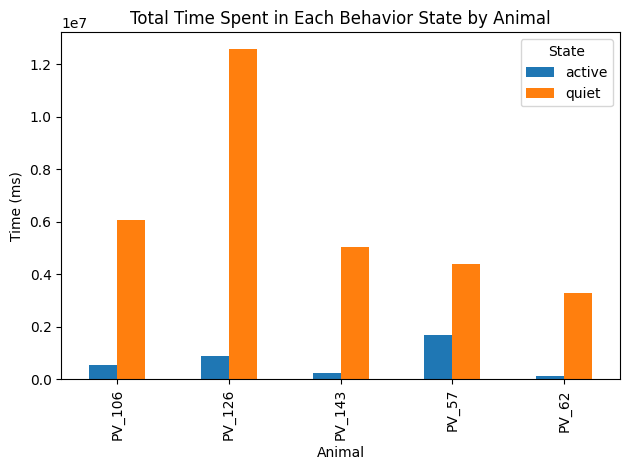

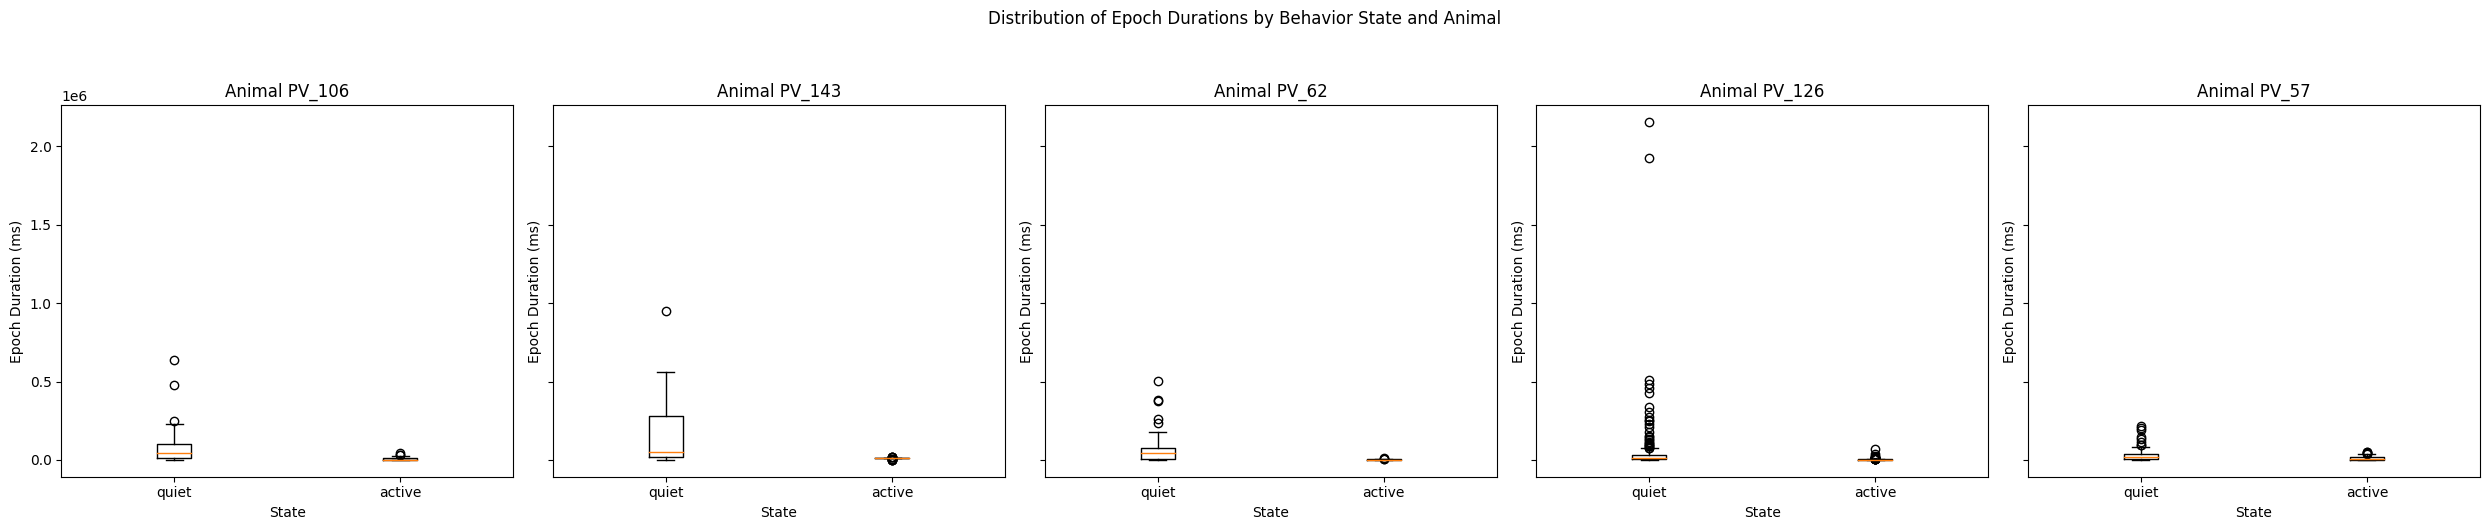

Total Time Spent (ms) per Animal and State:
state      active       quiet  ratio_quiet_active
animal                                           
PV_106   560000.0   6069000.0           10.837500
PV_126   892000.0  12583000.0           14.106502
PV_143   258000.0   5035000.0           19.515504
PV_57   1678000.0   4400987.0            2.622757
PV_62    125000.0   3305000.0           26.440000

Ratio of quiet to active time for each animal (quiet/active):
animal
PV_106    10.837500
PV_126    14.106502
PV_143    19.515504
PV_57      2.622757
PV_62     26.440000
Name: ratio_quiet_active, dtype: float64

Descriptive Statistics for Epoch Durations (ms):
               count           mean            std     min      25%      50%  \
animal state                                                                   
PV_106 active   76.0    7368.421053    8549.217672  1000.0   1000.0   3000.0   
       quiet    81.0   74925.925926  101512.410298  1000.0  10000.0  44000.0   
PV_126 active  237.0    3

<Figure size 1000x200 with 0 Axes>

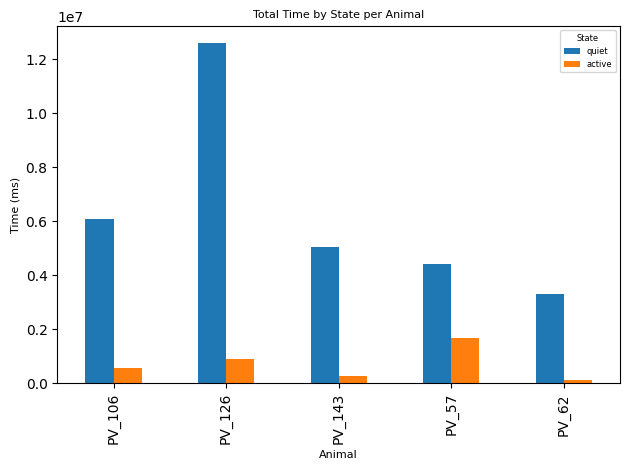

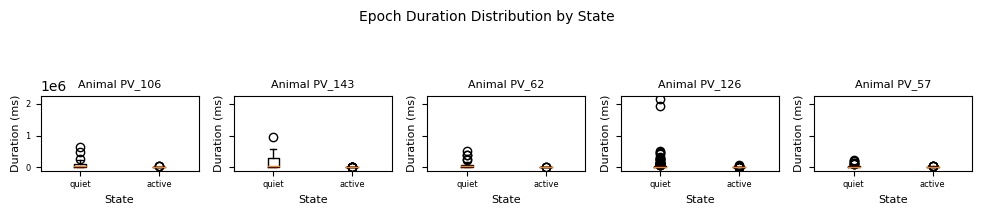

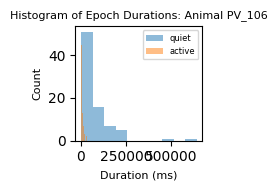

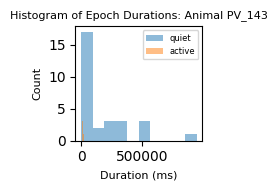

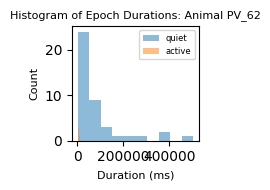

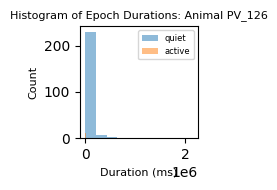

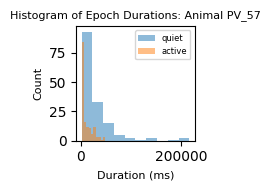

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming block_collection is a list of block objects.
# Each block has:
#   - block.animal: a variable that tells you which animal this block belongs to.
#   - block.state_df: a DataFrame with columns 'start_time', 'end_time', 'annotation'

# Create an empty list to hold the epoch data.
rows = []

# Loop through each block in the collection.
for block in block_collection:
    animal = block.animal_call
    state_df = block.behavior_state  # DataFrame with columns: start_time, end_time, annotation
    # Loop through each epoch/row in the state's DataFrame.
    for _, row in state_df.iterrows():
        state = row['annotation']
        duration = row['end_time'] - row['start_time']
        rows.append({
            'animal': animal,
            'state': state,
            'duration': duration,
            'start_time': row['start_time'],
            'end_time': row['end_time']
        })

# Create a DataFrame with all the epoch information.
df_all = pd.DataFrame(rows)

# Calculate total time per animal and state.
total_time = df_all.groupby(['animal', 'state'])['duration'].sum().unstack()

# -------------------------------
# Plot 1: Bar Plot of Total Time Spent in Each State per Animal
# -------------------------------
plt.figure(figsize=(8, 6))
total_time.plot(kind='bar', stacked=False)
plt.title("Total Time Spent in Each Behavior State by Animal")
plt.ylabel("Time (ms)")
plt.xlabel("Animal")
plt.legend(title="State")
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Box Plot of Epoch Duration Distribution per Animal and State
# -------------------------------
# Identify the unique animals in the dataset.
animals = df_all['animal'].unique()
n_animals = len(animals)

# Create a subplot for each animal.
fig, axs = plt.subplots(1, n_animals, figsize=(5 * n_animals, 5), sharey=True)
if n_animals == 1:
    axs = [axs]  # Ensure axs is iterable if there's only one subplot

for ax, animal in zip(axs, animals):
    # Extract durations for each state (quiet and active) for this animal.
    data_quiet = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'quiet')]['duration']
    data_active = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'active')]['duration']

    # Create a box plot for the two states.
    ax.boxplot([data_quiet, data_active], labels=['quiet', 'active'])
    ax.set_title(f"Animal {animal}")
    ax.set_xlabel("State")
    ax.set_ylabel("Epoch Duration (ms)")

plt.suptitle("Distribution of Epoch Durations by Behavior State and Animal", y=1.05)
plt.tight_layout()
plt.show()
import pandas as pd
import matplotlib.pyplot as plt

# Assuming block_collection is a list of block objects.
# Each block has:
#   - block.animal_call: identifier for the animal.
#   - block.behavior_state: DataFrame with columns 'start_time', 'end_time', 'annotation'

# Create an empty list to hold the epoch data.
rows = []

# Loop through each block in the collection.
for block in block_collection:
    animal = block.animal_call
    try:
        state_df = block.behavior_state  # DataFrame with columns: start_time, end_time, annotation
    except Exception:
        continue
    # Loop through each epoch in the state's DataFrame.
    for _, row in state_df.iterrows():
        state = row['annotation']
        duration = row['end_time'] - row['start_time']
        rows.append({
            'animal': animal,
            'state': state,
            'duration': duration,
            'start_time': row['start_time'],
            'end_time': row['end_time']
        })

# Create a DataFrame with all the epoch information.
df_all = pd.DataFrame(rows)

# Calculate total time per animal and state.
total_time = df_all.groupby(['animal', 'state'])['duration'].sum().unstack()

# Compute ratio (quiet/active) for each animal.
total_time['ratio_quiet_active'] = total_time.apply(
    lambda x: x['quiet']/x['active'] if x['active'] != 0 else float('nan'), axis=1
)

print("Total Time Spent (ms) per Animal and State:")
print(total_time)
print("\nRatio of quiet to active time for each animal (quiet/active):")
print(total_time['ratio_quiet_active'])

# Compute descriptive statistics for each animal and state.
summary_stats = df_all.groupby(['animal', 'state'])['duration'].describe()
print("\nDescriptive Statistics for Epoch Durations (ms):")
print(summary_stats)

# -------------------------------
# Plot 1: Bar Plot of Total Time per State for Each Animal
# Each subplot (or the overall plot) is made compact.
# -------------------------------
plt.figure(figsize=(2 * total_time.shape[0], 2))
total_time[['quiet', 'active']].plot(kind='bar', stacked=False)
plt.title("Total Time by State per Animal", fontsize=8)
plt.ylabel("Time (ms)", fontsize=8)
plt.xlabel("Animal", fontsize=8)
plt.legend(title="State", fontsize=6, title_fontsize=6)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Box Plot of Epoch Duration Distribution per Animal and State
# Each subplot is set to roughly 2x2 inches.
# -------------------------------
animals = df_all['animal'].unique()
n_animals = len(animals)

fig, axs = plt.subplots(1, n_animals, figsize=(2 * n_animals, 2), sharey=True)
if n_animals == 1:
    axs = [axs]  # ensure axs is iterable

for ax, animal in zip(axs, animals):
    data_quiet = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'quiet')]['duration']
    data_active = df_all[(df_all['animal'] == animal) & (df_all['state'] == 'active')]['duration']
    ax.boxplot([data_quiet, data_active], labels=['quiet', 'active'])
    ax.set_title(f"Animal {animal}", fontsize=8)
    ax.set_xlabel("State", fontsize=8)
    ax.set_ylabel("Duration (ms)", fontsize=8)
    ax.tick_params(axis='both', labelsize=6)

plt.suptitle("Epoch Duration Distribution by State", fontsize=10, y=1.05)
plt.tight_layout()
plt.show()

# -------------------------------
# Optional: Histograms for further analysis
# These provide another perspective on the distribution of epoch durations.
# -------------------------------
for animal in animals:
    plt.figure(figsize=(2, 2))
    subset = df_all[df_all['animal'] == animal]
    plt.hist(subset[subset['state']=='quiet']['duration'], alpha=0.5, label='quiet')
    plt.hist(subset[subset['state']=='active']['duration'], alpha=0.5, label='active')
    plt.title(f"Histogram of Epoch Durations: Animal {animal}", fontsize=8)
    plt.xlabel("Duration (ms)", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.show()


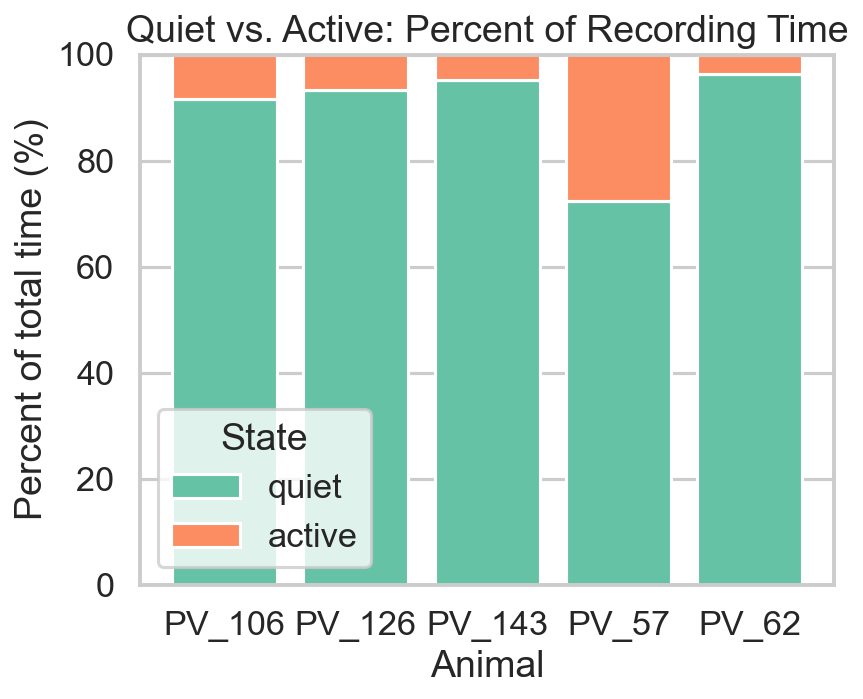

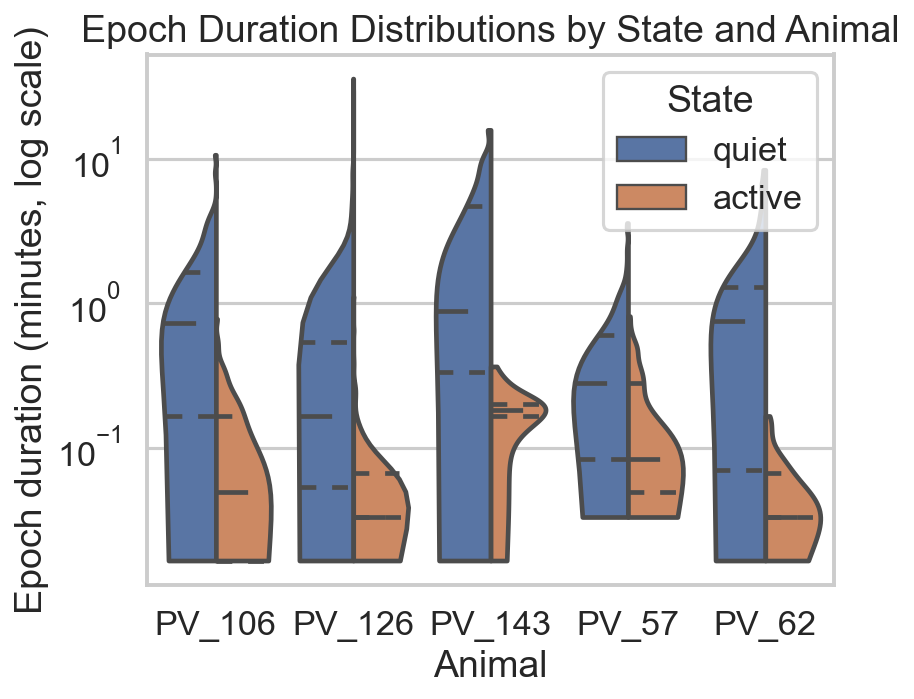


=== Totals & Quiet/Active Ratio (minutes) ===


state,animal,total_active_min,total_quiet_min,quiet_active_ratio
0,PV_106,9.333333,101.150000,10.837500
1,PV_126,14.866667,209.716667,14.106502
2,PV_143,4.300000,83.916667,19.515504
3,PV_57,27.966667,73.349783,2.622757
4,PV_62,2.083333,55.083333,26.440000



=== Epoch Duration Statistics (minutes) ===


,animal,state,n,total_min,median_min,mean_min,std_min,iqr_min
0,PV_106,active,76,9.333333,0.050000,0.122807,0.142487,0.150000
1,PV_106,quiet,81,101.150000,0.733333,1.248765,1.691874,1.483333
2,PV_126,active,237,14.866667,0.033333,0.062729,0.094248,0.033333
3,PV_126,quiet,242,209.716667,0.166667,0.866598,3.289948,0.487500
4,PV_143,active,25,4.300000,0.183333,0.172000,0.086832,0.033333
5,PV_143,quiet,29,83.916667,0.883333,2.893678,3.838737,4.350000
6,PV_57,active,151,27.966667,0.083333,0.185210,0.186692,0.233333
7,PV_57,quiet,154,73.349783,0.283333,0.476297,0.597863,0.516667
8,PV_62,active,40,2.083333,0.033333,0.052083,0.037589,0.033333
9,PV_62,quiet,42,55.083333,0.758333,1.311508,1.926050,1.220833


In [24]:
# %% [markdown]
# --- Behavior State Summary (per animal across all blocks) ---
# Produces:
# 1) Proportion of total time in quiet vs. active (stacked-percent bars)
# 2) Distribution of bout durations (violin; log y)
# 3) Summary table: totals, medians, IQR, and quiet/active ratio

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- configurable ---
SAVE_FIGS = False
FIG_DIR   = None  # e.g., pathlib.Path(r"Z:\Nimrod\figs"); set SAVE_FIGS=True to export
ORDER_ANIMALS = None  # e.g., ['PV_57','PV_62','PV_106','PV_126','PV_143']
STATE_ORDER = ['quiet','active']  # force order if desired

# ---------------------------------------------------------------------
# 1) Build tidy dataframe of epochs across all blocks
# ---------------------------------------------------------------------
rows = []
missing = []

for block in block_collection:
    animal = getattr(block, 'animal_call', None)
    state_df = getattr(block, 'behavior_state', None)

    if animal is None:
        missing.append(f"Block {getattr(block,'block_num', '??')}: missing animal_call")
        continue
    if state_df is None or not isinstance(state_df, pd.DataFrame) or state_df.empty:
        missing.append(f"{animal} block {getattr(block,'block_num', '??')}: missing/empty behavior_state")
        continue

    # Normalize column names just in case
    sdf = state_df.rename(columns={'annotation':'state'}).copy()

    # Keep only needed columns and coerce to numeric
    need = {'start_time','end_time','state'}
    keep = [c for c in sdf.columns if c in need]
    sdf = sdf[keep].copy()
    sdf['start_time'] = pd.to_numeric(sdf['start_time'], errors='coerce')
    sdf['end_time']   = pd.to_numeric(sdf['end_time'], errors='coerce')
    sdf['state']      = sdf['state'].astype(str).str.lower().str.strip()

    # Drop bad rows
    sdf = sdf.dropna(subset=['start_time','end_time','state'])
    sdf = sdf[sdf['end_time'] >= sdf['start_time']]

    if sdf.empty:
        missing.append(f"{animal}: behavior_state rows invalid after cleaning")
        continue

    # Duration in ms → also keep seconds/minutes for readability
    dur_ms = (sdf['end_time'] - sdf['start_time']).to_numpy()
    for st, d in zip(sdf['state'], dur_ms):
        rows.append({
            'animal': animal,
            'state': st,
            'duration_ms': float(d),
            'duration_s':  float(d)/1000.0,
            'duration_min': float(d)/1000.0/60.0
        })

df_all = pd.DataFrame(rows)
if df_all.empty:
    raise RuntimeError("No valid behavior_state data found across blocks. Check 'missing' list above.")

# Optional: restrict to the states of interest only
if STATE_ORDER is not None:
    df_all = df_all[df_all['state'].isin(STATE_ORDER)].copy()

# Determine animal order
if ORDER_ANIMALS is None:
    ORDER_ANIMALS = sorted(df_all['animal'].unique().tolist())

# ---------------------------------------------------------------------
# 2) Compute totals and percent-time per state
# ---------------------------------------------------------------------
totals = (
    df_all.groupby(['animal','state'])['duration_min']
    .sum()
    .reset_index()
)

# pivot for totals table & ratio
totals_wide = totals.pivot(index='animal', columns='state', values='duration_min').fillna(0.0)
for st in STATE_ORDER:
    if st not in totals_wide.columns:
        totals_wide[st] = 0.0
# quiet/active ratio (NaN if active=0)
if 'quiet' in totals_wide.columns and 'active' in totals_wide.columns:
    totals_wide['quiet_active_ratio'] = np.where(totals_wide['active']>0,
                                                 totals_wide['quiet']/totals_wide['active'],
                                                 np.nan)

# Percent-time per state (stacked, sums to 100% per animal)
perc = totals.copy()
perc['percent'] = (
    perc.groupby('animal')['duration_min']
        .transform(lambda x: 100.0 * x / x.sum() if x.sum()>0 else np.nan)
)

# ---------------------------------------------------------------------
# 3) Plot A: Percent of total time per state (clean, comparable)
# ---------------------------------------------------------------------
sns.set(style="whitegrid", context="talk")
figA, axA = plt.subplots(figsize=(1.5+0.9*len(ORDER_ANIMALS), 5), dpi=150)

# Stacked percent bars by manually layering states to control order
bottom = np.zeros(len(ORDER_ANIMALS))
palette = sns.color_palette("Set2", n_colors=len(STATE_ORDER))

for i, st in enumerate(STATE_ORDER):
    sub = perc[perc['state']==st]
    # align to ORDER_ANIMALS
    vals = []
    for a in ORDER_ANIMALS:
        row = sub[sub['animal']==a]['percent']
        vals.append(row.iloc[0] if not row.empty else 0.0)
    axA.bar(ORDER_ANIMALS, vals, bottom=bottom, label=st, color=palette[i])
    bottom += np.array(vals)

axA.set_ylabel("Percent of total time (%)")
axA.set_xlabel("Animal")
axA.set_title("Quiet vs. Active: Percent of Recording Time")
axA.set_ylim(0, 100)
axA.legend(title="State")
plt.tight_layout()

if SAVE_FIGS and FIG_DIR is not None:
    figA.savefig(FIG_DIR / "behavior_percent_time_by_animal.png", dpi=300, bbox_inches="tight")
    figA.savefig(FIG_DIR / "behavior_percent_time_by_animal.pdf", bbox_inches="tight")

plt.show()

# ---------------------------------------------------------------------
# 4) Plot B: Bout duration distributions (log scale, per animal)
# ---------------------------------------------------------------------
figB, axB = plt.subplots(figsize=(1.5+0.9*len(ORDER_ANIMALS), 5), dpi=150)
sns.violinplot(
    data=df_all,
    x='animal',
    y='duration_min',
    hue='state',
    order=ORDER_ANIMALS,
    hue_order=STATE_ORDER,
    split=True,
    scale='width',
    cut=0,
    inner='quartile',
    ax=axB
)
axB.set_yscale('log')  # durations often span orders of magnitude
axB.set_xlabel("Animal")
axB.set_ylabel("Epoch duration (minutes, log scale)")
axB.set_title("Epoch Duration Distributions by State and Animal")
axB.legend(title="State")
plt.tight_layout()

if SAVE_FIGS and FIG_DIR is not None:
    figB.savefig(FIG_DIR / "behavior_epoch_duration_violin.png", dpi=300, bbox_inches="tight")
    figB.savefig(FIG_DIR / "behavior_epoch_duration_violin.pdf", bbox_inches="tight")

plt.show()

# ---------------------------------------------------------------------
# 5) Summary statistics table (per animal x state)
# ---------------------------------------------------------------------
def iqr(x):
    return np.subtract(*np.percentile(x, [75, 25]))  # P75 - P25

stats = (
    df_all.groupby(['animal','state'])['duration_min']
    .agg(n='count', total_min='sum', median_min='median', mean_min='mean', std_min='std', iqr_min=iqr)
    .reset_index()
)

# Merge totals and ratios for convenience
totals_wide_disp = totals_wide.copy()
# Ensure both columns exist for readability
for st in STATE_ORDER:
    if st not in totals_wide_disp.columns:
        totals_wide_disp[st] = 0.0
totals_wide_disp = totals_wide_disp.reindex(ORDER_ANIMALS).rename(columns={
    'quiet':'total_quiet_min',
    'active':'total_active_min'
}).reset_index().rename(columns={'animal':'animal'})

print("\n=== Totals & Quiet/Active Ratio (minutes) ===")
display(totals_wide_disp)

print("\n=== Epoch Duration Statistics (minutes) ===")
display(stats)

# Report any missing data warnings at the end (non-fatal)
if missing:
    print("\n[Info] Skipped blocks with missing/invalid behavior_state:")
    for msg in missing:
        print(" -", msg)


In [25]:
import os
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
def plot_combined_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and right eye
    data for each annotation into a single curve. Outputs results into a timestamped folder.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    combined_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        print(block)
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data.query('speed_r < 4')
        right_eye_data = block.right_eye_data.query('speed_r < 4')

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Combine data from both eyes
            combined_aggregated[annotation].extend(left_eye_values)
            combined_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot combined data for all annotations
    fig, ax = plt.subplots(figsize=(2.2, 1.5), dpi=200)
    for annotation, data in combined_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax,
        )
    #ax.set_title('Combined Eye Probability Histograms', fontsize=12)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Likelihood', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_by_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "pupil_diameter_by_behavior.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "combined_aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(combined_aggregated, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

animal = 'PV_62'
keys = [i for i in block_dict.keys() if animal in i and '038' not in i]
blocks = [block_dict[k] for k in keys]
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv126'
plot_combined_eye_probability_histograms(blocks, export_path=None, num_bins=30, x_range=(1.0, 2.35))

PV_62, block 024, on 2023-04-27_11-22-56


UndefinedVariableError: name 'speed_r' is not defined

PV_62, block 024
PV_62, block 026
[diag] Final bin range: [1.3579, 2.2612] (40 bins).
[diag] Outlier percentiles used: (0.001, 99.999). Outlier min/max before intersection: 1.3579 / 2.2612
[diag] 'quiet': n=363897
[diag] 'active': n=14076
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62\pupil_diameter_by_behavior_2025_11_05_18_55_53


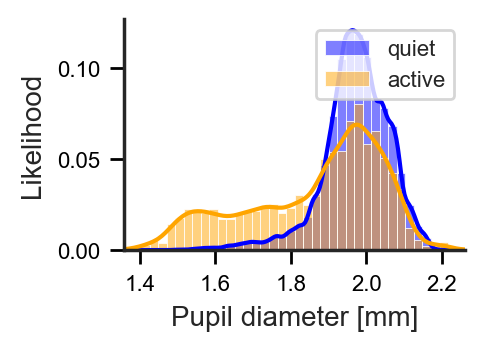

In [38]:
# debugging pupil diameter graph via gpt:
import os
import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Inline + vector-friendly fonts
# %matplotlib inline   # leave this in your notebook, not inside the function
plt.style.use('default')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype']  = 42

def plot_combined_eye_probability_histograms(
    block_list,
    export_path=None,
    num_bins=50,
    x_range=(8, 15),
    outlier_percentiles=(0.001, 99.999),
):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and
    right eye data for each annotation into a single curve. Outputs results into a timestamped folder.
    """
    # ---- collect & aggregate ----
    combined_aggregated = {}
    all_data = []

    def _safe_extend(dst, series_like):
        if series_like is None:
            return
        if isinstance(series_like, (pd.Series, pd.Index)):
            dst.extend(series_like.dropna().tolist())
        elif isinstance(series_like, (list, tuple, np.ndarray)):
            dst.extend([v for v in series_like if pd.notna(v)])
        else:
            # last resort: try to iterate
            for v in series_like:
                if pd.notna(v):
                    dst.append(v)

    for block in block_list:
        print(f"{block.animal_call}, block {str(block.block_num).zfill(3)}")


        # NOTE: You previously wrote "Convert sec->ms", but then copied values 1:1.
        # Leave units as-is — just be consistent with what ms_axis uses.
        behavior_df = block.behavior_state.copy()

        # Filter eye data (speed gate)
        #left_eye_data  = block.left_eye_data.query('speed_r < 4')
        #right_eye_data = block.right_eye_data.query('speed_r < 4')
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data
        # Ensure required columns exist (light guard)
        for col in ['ms_axis', 'pupil_diameter']:
            if col not in left_eye_data.columns or col not in right_eye_data.columns:
                print(f"[warn] Missing needed columns in block {block.block_num}: {col}")
                continue

        # Init labels
        for label in behavior_df['annotation'].unique():
            combined_aggregated.setdefault(label, [])

        # Aggregate per annotation interval
        for _, row in behavior_df.iterrows():
            start_time = row['start_time']  # assuming same unit as ms_axis in your data
            end_time   = row['end_time']
            annotation = row['annotation']

            # slice by time
            lvals = left_eye_data.query('ms_axis > @start_time and ms_axis < @end_time')['pupil_diameter']
            rvals = right_eye_data.query('ms_axis >= @start_time and ms_axis <= @end_time')['pupil_diameter']

            _safe_extend(combined_aggregated[annotation], lvals)
            _safe_extend(combined_aggregated[annotation], rvals)
            _safe_extend(all_data, lvals)
            _safe_extend(all_data, rvals)

    # ---- determine bin edges robustly ----
    if len(all_data) == 0:
        print("[error] No pupil data found after filtering; nothing to plot.")
        return

    # First, restrict to x_range; if nothing remains, we’ll handle gracefully
    all_data_in_range = [v for v in all_data if x_range[0] <= v <= x_range[1]]

    if len(all_data_in_range) == 0:
        # No overlap; fall back to using the raw percentiles to make a tiny valid range
        raw_min = np.nanmin(all_data)
        raw_max = np.nanmax(all_data)
        print(f"[warn] No data within x_range {x_range}. "
              f"Global data span = [{raw_min:.4g}, {raw_max:.4g}]. "
              f"Expanding to a minimal epsilon around global range for plotting.")
        outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
        start = min(outlier_min, outlier_max)
        stop  = max(outlier_min, outlier_max)
        if not np.isfinite(start) or not np.isfinite(stop) or start == stop:
            # last-ditch: fabricate a small window around the global min/max
            start, stop = raw_min, raw_max
            if start == stop:
                stop = start + 1e-6
    else:
        outlier_min, outlier_max = np.percentile(all_data_in_range, outlier_percentiles)
        # intersect with x_range
        start = max(min(outlier_min, outlier_max), x_range[0])
        stop  = min(max(outlier_min, outlier_max), x_range[1])
        if start >= stop:
            # ensure strictly increasing
            if start == stop:
                stop = start + 1e-6
            else:
                # swap if somehow reversed
                start, stop = sorted([start, stop])

    # Now build monotonic, strictly increasing bin edges
    bin_edges = np.linspace(start, stop, num_bins + 1)
    # Sentry: enforce strict monotonic increase (avoid floating equalities)
    if not np.all(bin_edges[1:] > bin_edges[:-1]):
        # Nudge with tiny epsilons
        eps = np.finfo(float).eps * max(1.0, abs(stop))
        bin_edges = np.linspace(start, stop + eps * (num_bins + 1), num_bins + 1)

    print(f"[diag] Final bin range: [{bin_edges[0]:.4f}, {bin_edges[-1]:.4f}] "
          f"({len(bin_edges)-1} bins).")
    print(f"[diag] Outlier percentiles used: {outlier_percentiles}. "
          f"Outlier min/max before intersection: "
          f"{outlier_min:.4f} / {outlier_max:.4f}")

    # ---- plot ----
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    fig, ax = plt.subplots(figsize=(2.2, 1.5), dpi=200)
    plotted_any = False

    for annotation, data in combined_aggregated.items():
        if not data:
            print(f"[info] '{annotation}': no samples after time-slicing; skipping.")
            continue

        # keep only values inside [start, stop] (so bins make sense)
        filtered_data = [v for v in data if bin_edges[0] <= v <= bin_edges[-1]]
        if len(filtered_data) == 0:
            print(f"[info] '{annotation}': no samples within bin range; skipping.")
            continue

        try:
            sns.histplot(
                filtered_data,
                bins=bin_edges,
                stat='probability',
                element='bars',
                label=f'{annotation}',
                alpha=0.5,
                color=color_map.get(annotation, 'gray'),kde=True,
                ax=ax,
            )
            plotted_any = True
            print(f"[diag] '{annotation}': n={len(filtered_data)}")
        except ValueError as e:
            print(f"[warn] Skipping '{annotation}' due to plotting error: {e}")

    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Likelihood', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', direction='out', which='major',
                   length=5, width=1, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor',
                   length=5, width=1, colors='black', bottom=True, left=True)
    ax.set_xlim(bin_edges[0], bin_edges[-1])

    if plotted_any:
        ax.legend(loc='upper right', fontsize=8)
    else:
        ax.text(0.5, 0.5, "No data to plot in selected range",
                transform=ax.transAxes, ha='center', va='center', fontsize=8)
        print("[info] No annotations produced plottable data in the final range.")

    # ---- export ----
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_by_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "pupil_diameter_by_behavior.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "combined_aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(combined_aggregated, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

animal = 'PV_62'
keys = [i for i in block_dict.keys() if animal in i and '038' not in i]
blocks = [block_dict[k] for k in keys]
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62'
plot_combined_eye_probability_histograms(blocks, export_path=export_path, num_bins=40, x_range=(1.0, 2.35))

PV_106: median=1.91 (IQR 1.85–1.96) mm; mean±SD=1.89±0.113 mm (CV 6.0%); range 1.43–2.14 mm; skew=-1.35, kurtosis=2.11.


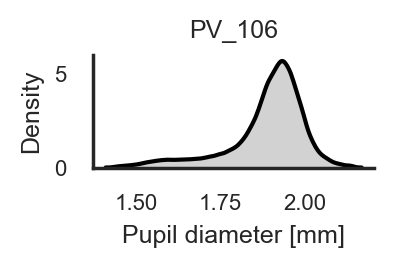

PV_143: median=1.85 (IQR 1.8–1.89) mm; mean±SD=1.84±0.0892 mm (CV 4.9%); range 1.35–2.01 mm; skew=-1.48, kurtosis=3.64.


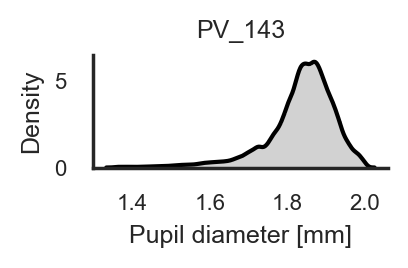

PV_62: median=1.97 (IQR 1.93–2.03) mm; mean±SD=1.97±0.0913 mm (CV 4.6%); range 1.56–2.15 mm; skew=-1.04, kurtosis=2.20.


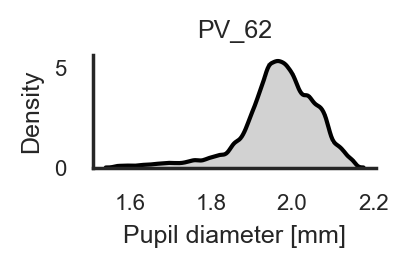

PV_126: median=1.92 (IQR 1.86–1.98) mm; mean±SD=1.91±0.0969 mm (CV 5.1%); range 1.49–2.15 mm; skew=-0.67, kurtosis=1.02.


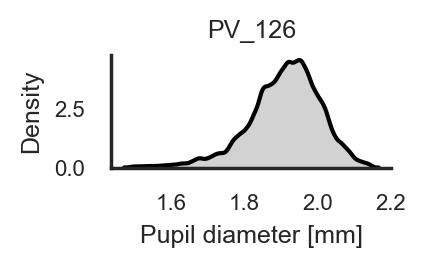

PV_57: median=1.6 (IQR 1.55–1.66) mm; mean±SD=1.6±0.0832 mm (CV 5.2%); range 1.28–1.82 mm; skew=-0.36, kurtosis=0.46.


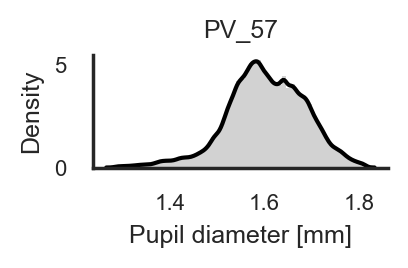

All animals: median=1.89 (IQR 1.79–1.96) mm; mean±SD=1.86±0.147 mm (CV 7.9%); range 1.38–2.14 mm; skew=-0.84, kurtosis=0.06.


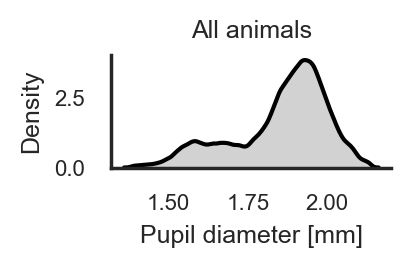

         group        n      mean       std        cv    median  mad_norm  \
0       PV_106   694680  1.888303  0.112903  0.059791  1.913039  0.075575   
1       PV_143   414150  1.835671  0.089181  0.048582  1.849819  0.066801   
2        PV_62   374201  1.968110  0.091253  0.046366  1.974369  0.077083   
3       PV_126  1232545  1.910610  0.096850  0.050691  1.919773  0.089177   
4        PV_57   483938  1.603665  0.083203  0.051883  1.602932  0.081800   
5  All animals  3199515  1.856309  0.147143  0.079266  1.892281  0.115766   

        iqr       p01       p05       p25       p75       p95       p99  \
0  0.106124  1.520430  1.629837  1.852044  1.958168  2.022528  2.080222   
1  0.090964  1.516993  1.665421  1.801047  1.892011  1.949618  1.984321   
2  0.104425  1.656336  1.799136  1.925089  2.029514  2.095707  2.133608   
3  0.120706  1.623805  1.735562  1.855073  1.975779  2.053466  2.103221   
4  0.110443  1.371551  1.463570  1.551988  1.662431  1.733609  1.779982   
5  0.17259

In [31]:
# --- Pupil-diameter summary per animal & combined (Python 3.8 compatible) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
from typing import Union, Tuple, Optional, List, Dict

def _summarize_series(
    x: Union[pd.Series, np.ndarray],
    name: str,
    clip_percentiles: Optional[Tuple[float, float]] = (0.5, 99.5),
    bins: int = 60,
    figsize: Tuple[float, float] = (2.2, 1.5),
    dpi: int = 200,
    kde_bw_adjust: float = 1.0,
    show_plot: bool = True,
) -> pd.DataFrame:
    """Return metrics DataFrame; optionally show a small histogram+KDE plot."""
    if isinstance(x, pd.Series):
        x = x.dropna().astype(float).to_numpy()
    else:
        x = np.asarray(x, float)
        x = x[np.isfinite(x)]

    if clip_percentiles is not None and x.size:
        lo, hi = np.percentile(x, clip_percentiles)
        x = x[(x >= lo) & (x <= hi)]

    n = x.size
    if n == 0:
        print(f"[warn] {name}: no data to summarize after filtering.")
        return pd.DataFrame({"group":[name], "n":[0]})

    mean = float(np.mean(x))
    std  = float(np.std(x, ddof=1)) if n > 1 else np.nan
    cv   = (std / mean) if (np.isfinite(mean) and mean != 0) else np.nan
    median = float(np.median(x))
    q05, q25, q75, q95 = np.percentile(x, [5, 25, 75, 95]).astype(float)
    iqr = float(q75 - q25)
    p1, p99 = np.percentile(x, [1, 99]).astype(float)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    mad = float(stats.median_abs_deviation(x, scale='normal')) if n > 1 else np.nan
    skew = float(stats.skew(x, bias=False)) if n > 2 else np.nan
    kurt = float(stats.kurtosis(x, fisher=True, bias=False)) if n > 3 else np.nan

    # One-liner summary
    desc = (f"{name}: median={median:.3g} (IQR {q25:.3g}–{q75:.3g}) mm; "
            f"mean±SD={mean:.3g}±{std:.3g} mm (CV {0 if np.isnan(cv) else 100*cv:.1f}%); "
            f"range {xmin:.3g}–{xmax:.3g} mm; skew={skew:.2f}, kurtosis={kurt:.2f}.")
    print(desc)

    if show_plot:
        sns.set(style="white")
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        ax.hist(x, bins=bins, density=True, alpha=0.35, color="gray", edgecolor="none")
        sns.kdeplot(x, bw_adjust=kde_bw_adjust, color="black", linewidth=1.5, ax=ax)
        ax.set_title(name, fontsize=9)
        ax.set_xlabel("Pupil diameter [mm]", fontsize=9)
        ax.set_ylabel("Density", fontsize=9)
        ax.tick_params(axis='both', labelsize=8)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.tight_layout()
        plt.show()

    metrics = pd.DataFrame({
        "group": [name],
        "n": [n],
        "mean": [mean],
        "std": [std],
        "cv": [cv],
        "median": [median],
        "mad_norm": [mad],
        "iqr": [iqr],
        "p01": [p1],
        "p05": [q05],
        "p25": [q25],
        "p75": [q75],
        "p95": [q95],
        "p99": [p99],
        "min": [xmin],
        "max": [xmax],
        "skew": [skew],
        "kurtosis_fisher": [kurt],
    })
    return metrics


def analyze_pupil_diameter_by_animal(
    block_collection,
    pupil_col: str = "pupil_diameter",
    left_df_attr: str = "left_eye_data",
    right_df_attr: str = "right_eye_data",
    animal_attr: str = "animal_call",
    clip_percentiles: Optional[Tuple[float, float]] = (0.5, 99.5),
    bins: int = 60,
    kde_bw_adjust: float = 1.0,
    figsize: Tuple[float, float] = (2.2, 1.5),
    dpi: int = 200,
    show_plots: bool = True,
) -> pd.DataFrame:
    """
    Aggregate pupil diameter across blocks, summarize per animal and combined.
    Returns a metrics DataFrame (one row per animal + 'All animals').
    """
    per_animal: Dict[str, List[pd.Series]] = defaultdict(list)
    all_values: List[pd.Series] = []

    for b in block_collection:
        animal = getattr(b, animal_attr, "UNKNOWN")
        for eye_attr in (left_df_attr, right_df_attr):
            df = getattr(b, eye_attr, None)
            if df is None or not isinstance(df, pd.DataFrame):
                print(f"[warn] {animal} B{getattr(b,'block_num','?')}: missing {eye_attr}; skipping.")
                continue
            if pupil_col not in df.columns:
                print(f"[warn] {animal} B{getattr(b,'block_num','?')}: missing column '{pupil_col}'; skipping.")
                continue
            vals = df[pupil_col]
            per_animal[animal].append(vals)
            all_values.append(vals)

    metrics_list: List[pd.DataFrame] = []

    for animal, series_list in per_animal.items():
        if not series_list:
            print(f"[info] {animal}: no data aggregated.")
            continue
        s = pd.concat(series_list, ignore_index=True)
        m = _summarize_series(
            s, animal,
            clip_percentiles=clip_percentiles,
            bins=bins, figsize=figsize, dpi=dpi,
            kde_bw_adjust=kde_bw_adjust, show_plot=show_plots
        )
        metrics_list.append(m)

    if len(all_values):
        s_all = pd.concat(all_values, ignore_index=True)
        m_all = _summarize_series(
            s_all, "All animals",
            clip_percentiles=clip_percentiles,
            bins=bins, figsize=figsize, dpi=dpi,
            kde_bw_adjust=kde_bw_adjust, show_plot=show_plots
        )
        metrics_list.append(m_all)
    else:
        print("[warn] No pupil diameter values found in any block.")

    metrics_df = pd.concat(metrics_list, ignore_index=True) if metrics_list else pd.DataFrame()
    return metrics_df
metrics = analyze_pupil_diameter_by_animal(
    block_collection,
    pupil_col="pupil_diameter",
    clip_percentiles=(0.5, 99.5),  # set None to disable clipping
    bins=60,
    kde_bw_adjust=1.0,
    show_plots=True,
)
print(metrics)


In [36]:
path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62\pupil_diameter_by_behavior_2025_02_26_12_18_59\combined_aggregated_data.pkl')

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---- 1) Load (path is a pathlib.Path to 'combined_aggregated_data.pkl') ----
def load_combined_aggregated(path: Path) -> dict:
    with path.open('rb') as f:
        data = pickle.load(f)
    if not isinstance(data, dict):
        raise TypeError(f"Expected dict, got {type(data)}")
    # ensure arrays of float
    return {k: np.asarray(v, dtype=float) for k, v in data.items()}

combined = load_combined_aggregated(path)
combined

{'quiet': array([1.93783051, 1.93480166, 1.93359569, ..., 2.0378808 , 2.04223059,
        2.04252974]),
 'active': array([2.00789667, 2.01095942, 2.01131127, ..., 1.9143798 , 2.06168592,
        2.05363513])}

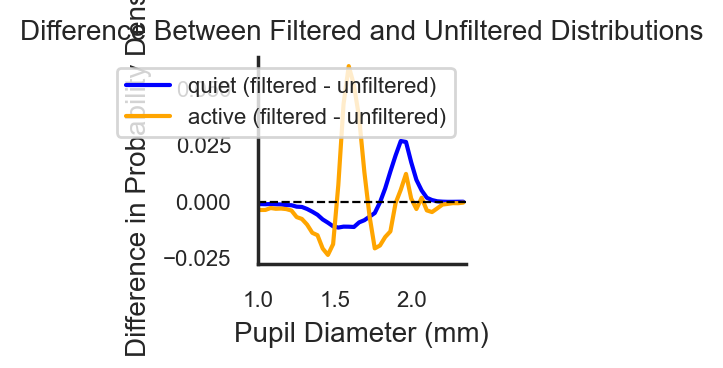

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os


def plot_difference_between_filtered_unfiltered(block_collection, export_path=None, figsize=(2, 1.5),
                                                num_bins=40, x_range=(1.0, 2.35),
                                                outlier_percentiles=(0.001, 99.999), speed_threshold=4):
    """
    Computes and plots the difference between the pupil diameter distributions (filtered minus unfiltered)
    for the 'quiet' and 'active' behavioral states. Optionally exports the figure to a PDF.

    Parameters:
        block_collection (list): List of blocks with attributes 'behavior_state', 'left_eye_data', and 'right_eye_data'.
        export_path (str or None): Directory path to export the plot. If provided, a timestamped folder is created.
        figsize (tuple): Figure size (width, height) for the plot.
        num_bins (int): Number of bins to use for the histogram.
        x_range (tuple): The x-axis range for pupil diameters.
        outlier_percentiles (tuple): Percentile range for outlier removal.
        speed_threshold (float): The threshold for filtering high-speed frames (frames with speed_r >= threshold are removed).
    """
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Initialize dictionaries for aggregated data
    aggregated_all = {'quiet': [], 'active': []}
    aggregated_filtered = {'quiet': [], 'active': []}
    all_data_all = []

    # Aggregate data over blocks (both eyes combined)
    for block in block_collection:
        behavior_df = block.behavior_state.copy()
        # Use times as in your notebook
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Unfiltered eye data
        left_all = block.left_eye_data
        right_all = block.right_eye_data
        # Filtered eye data (speed_r below threshold)
        left_filtered = block.left_eye_data.query('speed_r < @speed_threshold')
        right_filtered = block.right_eye_data.query('speed_r < @speed_threshold')

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['quiet', 'active']:
                continue
            start_ms = row['start_time_ms']
            end_ms = row['end_time_ms']

            # Unfiltered values
            left_vals_all = left_all.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                'pupil_diameter'].dropna().tolist()
            right_vals_all = right_all.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                'pupil_diameter'].dropna().tolist()
            aggregated_all[annotation].extend(left_vals_all)
            aggregated_all[annotation].extend(right_vals_all)
            all_data_all.extend(left_vals_all)
            all_data_all.extend(right_vals_all)

            # Filtered values
            left_vals_filt = left_filtered.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                'pupil_diameter'].dropna().tolist()
            right_vals_filt = right_filtered.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                'pupil_diameter'].dropna().tolist()
            aggregated_filtered[annotation].extend(left_vals_filt)
            aggregated_filtered[annotation].extend(right_vals_filt)

    # Determine shared bin edges based on overall unfiltered data
    outlier_min_all, outlier_max_all = np.percentile(all_data_all, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min_all, x_range[0]), min(outlier_max_all, x_range[1]), num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute histograms (PDFs) for each annotation using the shared bin edges
    difference_data = {}
    for annotation in ['quiet', 'active']:
        data_unfiltered = [val for val in aggregated_all[annotation] if outlier_min_all <= val <= outlier_max_all]
        data_filtered = [val for val in aggregated_filtered[annotation] if outlier_min_all <= val <= outlier_max_all]
        hist_unfiltered, _ = np.histogram(data_unfiltered, bins=bin_edges, density=True)
        hist_filtered, _ = np.histogram(data_filtered, bins=bin_edges, density=True)
        # Compute the difference (filtered minus unfiltered)
        diff = hist_filtered - hist_unfiltered
        difference_data[annotation] = diff

    # Plot the differences on a single plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=figsize, dpi=200)
    for annotation in ['quiet', 'active']:
        ax.plot(bin_midpoints, difference_data[annotation], linestyle='-',
                color=color_map.get(annotation, 'gray'),
                label=f"{annotation} (filtered - unfiltered)")

    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax.set_ylabel('Difference in Probability Density', fontsize=10)
    ax.set_title('Difference Between Filtered and Unfiltered Distributions', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()

    # Export the figure if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        file_path = os.path.join(full_export_path, "pupil_diameter_diff.pdf")
        fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {file_path}")

    plt.show()


plot_difference_between_filtered_unfiltered(block_collection,
                                            export_path=None,
                                            figsize=(2, 2))

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import math


def plot_difference_by_animal(block_collection, export_path=None, figsize=(6, 4), num_bins=40,
                              x_range=(1.0, 2.35), outlier_percentiles=(0.001, 99.999), speed_threshold=4):
    """
    Groups blocks by animal and plots, for each animal in a separate subplot,
    two lines (quiet and active) showing the difference (filtered minus unfiltered)
    in the pupil diameter probability density. Each line is drawn with markers,
    so that only the animal’s own computed datapoints (per bin) are displayed.

    Parameters:
        block_collection (list): List of block objects with attributes:
            - behavior_state: DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data, right_eye_data: DataFrames with 'ms_axis', 'pupil_diameter', and 'speed_r'.
            - animal: A string identifier for the animal.
        export_path (str or None): If provided, the figure is saved as a PDF in a timestamped folder.
        figsize (tuple): Overall figure size (width, height) for the entire figure.
        num_bins (int): Number of bins for histogram computation.
        x_range (tuple): Range of pupil diameters to consider for the x-axis.
        outlier_percentiles (tuple): Percentile range to determine bin edges from unfiltered data.
        speed_threshold (float): Frames with speed_r >= threshold are filtered out.
    """
    # Group blocks by animal.
    animal_blocks = {}
    for block in block_collection:
        animal = block.animal if hasattr(block, 'animal') else "Unknown"
        if animal not in animal_blocks:
            animal_blocks[animal] = []
        animal_blocks[animal].append(block)

    animals = sorted(animal_blocks.keys())

    # Determine subplot layout: Use 2 columns if more than one animal.
    ncols = 2 if len(animals) > 1 else 1
    nrows = math.ceil(len(animals) / ncols)

    color_map = {'quiet': 'blue', 'active': 'orange'}

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=200, squeeze=False)

    # Loop over each animal.
    for i, animal in enumerate(animals):
        # Initialize aggregated data for this animal.
        aggregated_all = {'quiet': [], 'active': []}
        aggregated_filtered = {'quiet': [], 'active': []}
        all_data_all = []

        # Process each block for the current animal.
        for block in animal_blocks[animal]:
            behavior_df = block.behavior_state.copy()
            # Use times as in your notebook
            behavior_df['start_time_ms'] = behavior_df['start_time']
            behavior_df['end_time_ms'] = behavior_df['end_time']
            # Unfiltered data.
            left_all = block.left_eye_data
            right_all = block.right_eye_data
            # Filtered data.
            left_filtered = block.left_eye_data.query('speed_r < @speed_threshold')
            right_filtered = block.right_eye_data.query('speed_r < @speed_threshold')

            for _, row in behavior_df.iterrows():
                annotation = row['annotation']
                if annotation not in ['quiet', 'active']:
                    continue
                start_ms = row['start_time_ms']
                end_ms = row['end_time_ms']
                # Unfiltered values.
                left_vals_all = left_all.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                right_vals_all = right_all.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                aggregated_all[annotation].extend(left_vals_all)
                aggregated_all[annotation].extend(right_vals_all)
                all_data_all.extend(left_vals_all)
                all_data_all.extend(right_vals_all)
                # Filtered values.
                left_vals_filt = left_filtered.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                right_vals_filt = right_filtered.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                    'pupil_diameter'].dropna().tolist()
                aggregated_filtered[annotation].extend(left_vals_filt)
                aggregated_filtered[annotation].extend(right_vals_filt)

        # Skip animal if no data is available.
        if len(all_data_all) == 0:
            continue

        # Determine shared bin edges based on the unfiltered data for this animal.
        outlier_min_all, outlier_max_all = np.percentile(all_data_all, outlier_percentiles)
        bin_edges = np.linspace(max(outlier_min_all, x_range[0]), min(outlier_max_all, x_range[1]), num_bins + 1)
        bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Compute the histogram differences for each annotation.
        difference_data = {}
        for annotation in ['quiet', 'active']:
            data_unfiltered = [val for val in aggregated_all[annotation] if outlier_min_all <= val <= outlier_max_all]
            data_filtered = [val for val in aggregated_filtered[annotation] if
                             outlier_min_all <= val <= outlier_max_all]
            hist_unfiltered, _ = np.histogram(data_unfiltered, bins=bin_edges, density=True)
            hist_filtered, _ = np.histogram(data_filtered, bins=bin_edges, density=True)
            diff = hist_filtered - hist_unfiltered
            difference_data[annotation] = diff

        # Determine subplot index.
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axs[row_idx, col_idx]

        # Plot each annotation's difference with markers so that each bin's datapoint is visible.
        for annotation in ['quiet', 'active']:
            ax.plot(bin_midpoints, difference_data[annotation], linestyle='-', marker='o', markersize=4,
                    color=color_map.get(annotation, 'gray'),
                    label=f"{annotation}")

        ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xlabel('Pupil Diameter (mm)', fontsize=10)
        ax.set_ylabel('Difference in PDF', fontsize=10)
        ax.set_title(f'{animal}', fontsize=10)
        ax.tick_params(axis='both', labelsize=8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim(x_range)
        ax.legend(loc='upper right', fontsize=8)

    # Remove any empty subplots.
    total_subplots = nrows * ncols
    if total_subplots > len(animals):
        for j in range(len(animals), total_subplots):
            row_idx = j // ncols
            col_idx = j % ncols
            fig.delaxes(axs[row_idx, col_idx])

    plt.tight_layout()

    # Export the figure if an export path is provided.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_by_animal_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        file_path = os.path.join(full_export_path, "pupil_diameter_diff_by_animal.pdf")
        fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {file_path}")

    plt.show()


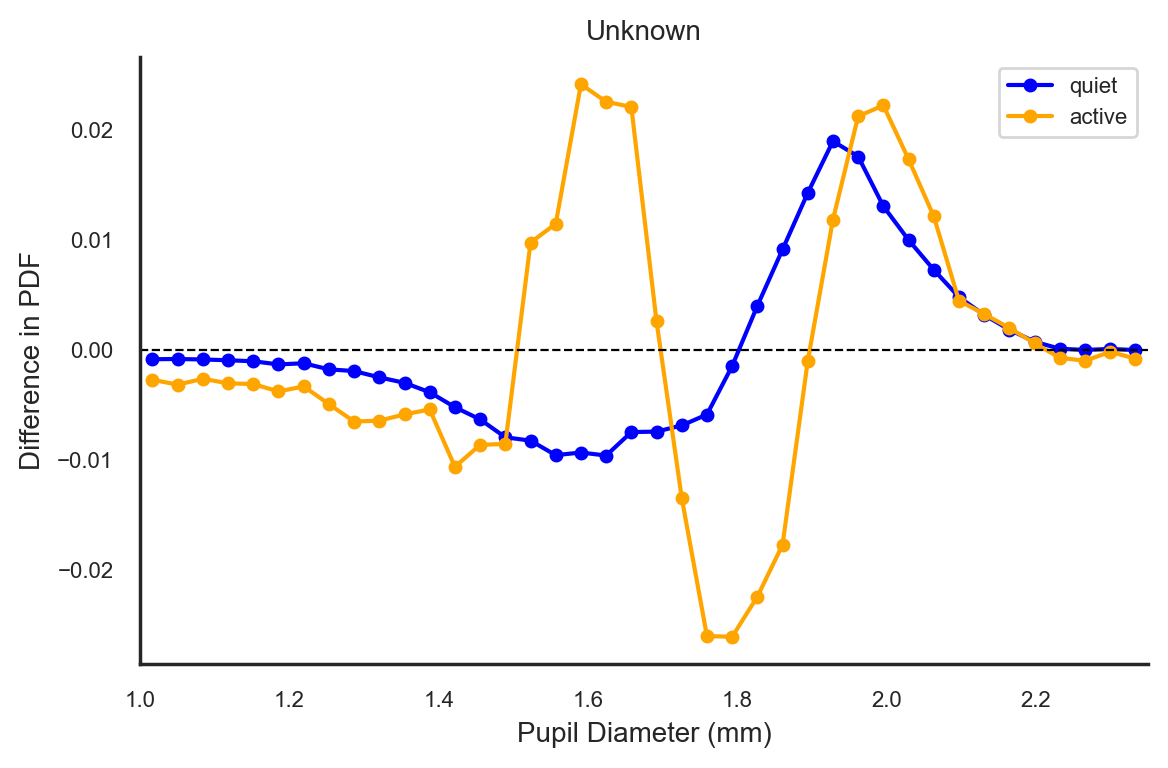

In [11]:
plot_difference_by_animal(block_collection,
                          export_path=None,
                          figsize=(6, 4))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to hold total time per annotation for each animal
animal_annotation_time = {}

# Loop over blocks to accumulate total time per behavioral annotation
for block in block_collection:
    # Assuming each block has an attribute 'animal'
    animal = block.animal if hasattr(block, 'animal') else "Unknown"

    # Ensure the animal key exists
    if animal not in animal_annotation_time:
        animal_annotation_time[animal] = {'quiet': 0, 'active': 0}

    behavior_df = block.behavior_state.copy()
    # Ensure times are in milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Compute duration for each annotation period and accumulate
    for _, row in behavior_df.iterrows():
        annotation = row['annotation']
        if annotation not in ['quiet', 'active']:
            continue
        duration = row['end_time_ms'] - row['start_time_ms']
        animal_annotation_time[animal][annotation] += duration

# Plot a separate pie chart for each animal
for animal, time_dict in animal_annotation_time.items():
    labels = []
    sizes = []
    for state in ['quiet', 'active']:
        labels.append(state)
        sizes.append(time_dict[state])

    # Normalize to percentages
    total = sum(sizes)
    if total > 0:
        sizes = [s / total * 100 for s in sizes]

    fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['blue', 'orange'], startangle=90)
    ax.set_title(f'Behavioral Annotation Distribution for {animal}', fontsize=10)
    plt.tight_layout()
    plt.show()


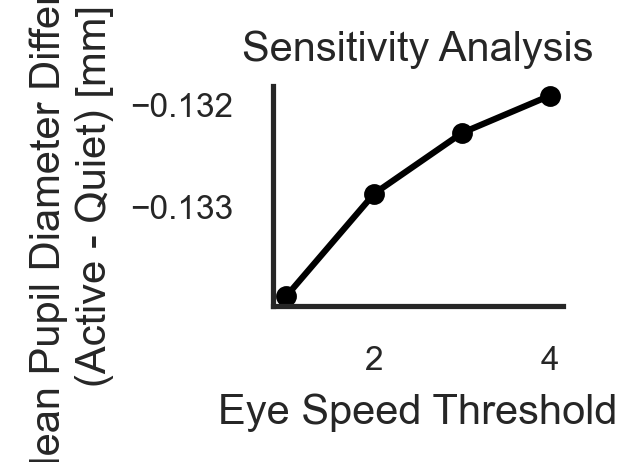

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [1, 2, 3, 4]
difference_means = []

# Loop over each threshold value
for thr in thresholds:
    aggregated = {'quiet': [], 'active': []}

    # Loop over blocks
    for block in block_collection:
        behavior_df = block.behavior_state.copy()
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Filter eye data based on the current threshold
        left_filtered = block.left_eye_data.query('speed_r < @thr')
        right_filtered = block.right_eye_data.query('speed_r < @thr')

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['quiet', 'active']:
                continue
            start_ms = row['start_time_ms']
            end_ms = row['end_time_ms']

            left_vals = left_filtered.query('ms_axis > @start_ms and ms_axis < @end_ms')[
                'pupil_diameter'].dropna().tolist()
            right_vals = right_filtered.query('ms_axis >= @start_ms and ms_axis <= @end_ms')[
                'pupil_diameter'].dropna().tolist()
            aggregated[annotation].extend(left_vals)
            aggregated[annotation].extend(right_vals)

    # Compute mean pupil diameter for active and quiet states if data is available
    active_data = np.array(aggregated['active'])
    quiet_data = np.array(aggregated['quiet'])

    if len(active_data) > 0 and len(quiet_data) > 0:
        diff_mean = np.mean(active_data) - np.mean(quiet_data)
    else:
        diff_mean = np.nan  # In case data is missing
    difference_means.append(diff_mean)

# Plot sensitivity: threshold (x-axis) vs. mean difference (y-axis)
sns.set(style="white")
fig, ax = plt.subplots(figsize=(2.2, 1.7), dpi=300)
ax.plot(thresholds, difference_means, marker='o', linestyle='-', color='black', markersize=4)
ax.set_xlabel('Eye Speed Threshold', fontsize=10)
ax.set_ylabel('Mean Pupil Diameter Difference\n(Active - Quiet) [mm]', fontsize=10)
ax.set_title('Sensitivity Analysis', fontsize=10)
ax.tick_params(axis='both', which='both', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()


In [ ]:
# subtracted graph version 1
import os
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_difference_eye_probability_histogram(block_list, export_path=None, num_bins=40,
                                                x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a Seaborn-based difference histogram representing the probability difference
    between active and quiet pupil diameter distributions (active - quiet). The area between the
    difference curve and 0 is shaded for visual clarity.

    Args:
        block_list: List of BlockSync objects with these attributes:
            - behavior_state (pd.DataFrame): with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Directory to save the output (folder is created automatically if None is provided).
        num_bins (int): Number of bins to use for pupil diameter values.
        x_range (tuple): The x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) for the central 98%).
    """
    # Initialize dictionary for annotation data and a list for overall data (for bin calculation)
    combined_aggregated = {}
    all_data = []

    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Use provided times (assumed already in ms or convert if needed)
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Prepare keys in the aggregation dictionary
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate pupil diameter data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            combined_aggregated[annotation].extend(left_vals)
            combined_aggregated[annotation].extend(right_vals)
            all_data.extend(left_vals)
            all_data.extend(right_vals)

    # Determine shared bin edges using overall data and outlier limits
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Extract and filter data for 'active' and 'quiet' annotations
    active_data = np.array(combined_aggregated.get('active', []))
    quiet_data = np.array(combined_aggregated.get('quiet', []))
    active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
    quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

    # Compute histograms using the shared bin edges
    hist_active, _ = np.histogram(active_data, bins=bin_edges)
    hist_quiet, _ = np.histogram(quiet_data, bins=bin_edges)

    # Normalize to obtain probabilities
    total_active = np.sum(hist_active)
    total_quiet = np.sum(hist_quiet)
    prob_active = hist_active / total_active if total_active > 0 else hist_active
    prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

    # Compute the difference: active minus quiet
    diff = prob_active - prob_quiet

    # Calculate bin midpoints for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Set up the plot using Seaborn styling
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)

    # Plot the difference curve with small dot markers
    ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color='purple', label='Active - Quiet')
    # Shade the area between the curve and 0
    ax.fill_between(bin_midpoints, diff, 0, color='purple', alpha=0.3)
    # Add a dashed horizontal line at 0 for reference
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # Set title and labels with font size 10
    ax.set_title('Difference Histogram: Active - Quiet', fontsize=10)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)

    # Configure tick parameters (font size 8)
    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')

    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Set x-axis limits
    ax.set_xlim(x_range)
    #ax.legend(loc='upper right', fontsize=8)

    # Export the plot and data if an export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_difference_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "pupil_diameter_difference.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "difference_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(diff, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

plot_difference_eye_probability_histogram(block_collection[5:6], export_path=None, num_bins=12, x_range=(1, 2))

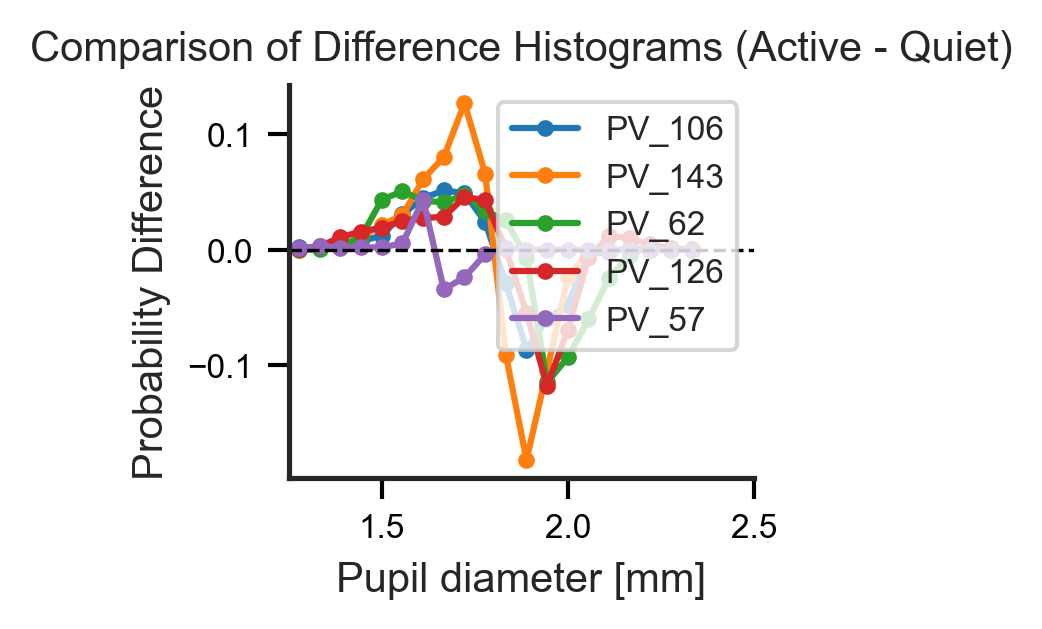

In [35]:

def compare_animals_difference_histogram(block_dict, export_path=None, num_bins=40,
                                           x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals.
    The block_dict keys include an animal identifier (formatted as 'PV_x', where x is one to three digits)
    and a block identifier (e.g., 'PV_62_block_023'). Blocks are grouped by animal, and for each animal,
    pupil diameter data for 'active' and 'quiet' annotations are aggregated across blocks. A normalized
    difference histogram (active - quiet) is computed using shared bin edges and plotted on a single graph.

    Args:
        block_dict (dict): Dictionary where each key is a string containing the animal identifier (e.g., 'PV_62_block_023')
                           and the value is a block object. Each block must have:
                                - behavior_state (pd.DataFrame): with columns 'start_time', 'end_time', and 'annotation'.
                                - left_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
                                - right_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
        export_path (str): Directory to save the output plot and data. A timestamped folder is created if provided.
        num_bins (int): Number of bins for the pupil diameter values.
        x_range (tuple): x-axis range (min, max) for the plot.
        outlier_percentiles (tuple): Percentile range for outlier removal (e.g., (0.001, 99.999)).
    """
    overall_data = []
    animal_data = {}  # Dictionary to store aggregated data per animal

    # Process each block; extract animal name from the key (assumes format 'PV_x_block_YYY')
    for key, block in block_dict.items():
        # Extract animal name (e.g., "PV_62") using a regex or split method
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue  # Skip if the key does not contain the expected animal identifier
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}

        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are already in milliseconds; if not, convert accordingly.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Aggregate pupil diameter data for the 'active' and 'quiet' annotations
        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna()

            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)

            # Also aggregate for overall bin edge determination
            overall_data.extend(left_vals)
            overall_data.extend(right_vals)

    # Compute outlier limits and shared bin edges
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Prepare a color palette (one color per animal)
    colors = sns.color_palette('tab10', n_colors=len(animal_data))

    animal_diffs = {}
    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        # Filter data to remove outliers
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

        # Compute histograms using shared bin edges
        hist_active, _ = np.histogram(active_data, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_data, bins=bin_edges)

        # Normalize to probabilities
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

        # Compute the difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff

    # Create the comparison plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)

    # Plot each animal's difference curve with small markers and shade the area between the curve and 0
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color=colors[idx], label=animal)
        #ax.fill_between(bin_midpoints, diff, 0, color=colors[idx], alpha=0.3)

    # Add a horizontal dashed reference line at 0
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # Set title and axis labels with the specified font sizes
    ax.set_title('Comparison of Difference Histograms (Active - Quiet)', fontsize=10)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)

    # Configure tick parameters
    ax.tick_params(axis='both', which='both', bottom=True, left=True)

    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')

    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Optionally export the plot and data if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_comparison_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "pupil_diameter_diff_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "animal_diff_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals'
compare_animals_difference_histogram(block_dict, export_path=None, num_bins=20,
                                           x_range=(1.25, 2.5), outlier_percentiles=(0.005, 99.995))

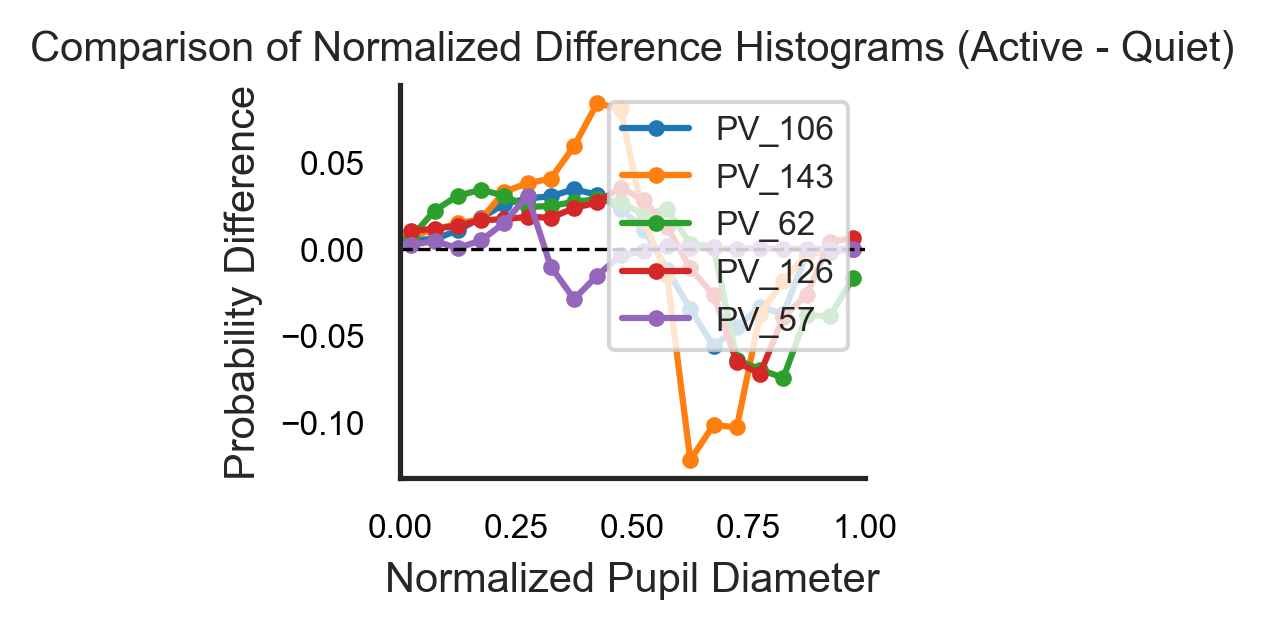

In [36]:
def compare_animals_difference_histogram_normalized(block_dict, export_path=None, num_bins=40,
                                                    x_range=(0, 1), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals,
    with each animal’s pupil diameter values normalized to [0, 1] based on its own distribution
    (after outlier removal). This allows for a fair comparison even when animals have different
    absolute pupil diameter ranges.

    Args:
        block_dict (dict): Dictionary where each key is a string containing the animal identifier (e.g., 'PV_62_block_023')
                           and the value is a block object. Each block must have:
                                - behavior_state (pd.DataFrame): with columns 'start_time', 'end_time', and 'annotation'.
                                - left_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
                                - right_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
        export_path (str): Directory to save the output plot and data.
        num_bins (int): Number of bins for the normalized pupil diameter values.
        x_range (tuple): x-axis range for the plot; default is (0, 1) since data are normalized.
        outlier_percentiles (tuple): Percentile range for outlier removal.
    """
    overall_data = []
    animal_data = {}  # Dictionary to store aggregated raw data per animal

    # Process each block; extract animal name from the key (assumes format 'PV_x_block_YYY')
    for key, block in block_dict.items():
        # Extract animal name (e.g., "PV_62") using regex
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}

        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are already in milliseconds.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Aggregate pupil diameter data for 'active' and 'quiet' annotations
        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna()

            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)

            # Also aggregate for overall bin edge determination (global outlier removal)
            overall_data.extend(left_vals)
            overall_data.extend(right_vals)

    # Compute global outlier limits using overall data (this is done prior to normalization)
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)

    # Prepare a color palette (one color per animal)
    colors = sns.color_palette('tab10', n_colors=len(animal_data))

    animal_diffs = {}
    # Here we now compute shared bin edges for normalized data: they always span 0 to 1.
    bin_edges = np.linspace(x_range[0], x_range[1], num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        # Filter each animal's data to remove outliers (using global limits)
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

        # Combine active and quiet data to get the animal-specific min and max
        combined = np.concatenate((active_data, quiet_data))
        if combined.size == 0:
            continue  # Skip if no data remains after outlier removal

        animal_min = combined.min()
        animal_max = combined.max()
        # Normalize data to the [0, 1] range using animal-specific min and max.
        active_norm = (active_data - animal_min) / (animal_max - animal_min)
        quiet_norm = (quiet_data - animal_min) / (animal_max - animal_min)

        # Compute histograms on the normalized data using the same bin edges for both conditions.
        hist_active, _ = np.histogram(active_norm, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_norm, bins=bin_edges)

        # Normalize the histograms to probabilities
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

        # Compute the difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff

    # Create the comparison plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)

    # Plot each animal's difference curve with markers and a horizontal reference line at 0.
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color=colors[idx], label=animal)
        # Optionally: ax.fill_between(bin_midpoints, diff, 0, color=colors[idx], alpha=0.3)

    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Comparison of Normalized Difference Histograms (Active - Quiet)', fontsize=10)
    ax.set_xlabel('Normalized Pupil Diameter', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)

    ax.tick_params(axis='both', which='both', labelsize=8, direction='out', length=5, width=1, colors='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Optionally export the plot and data if an export path is provided.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"normalized_pupil_diameter_diff_comparison_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "normalized_pupil_diameter_diff_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "animal_diff_data_normalized.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
compare_animals_difference_histogram_normalized(block_dict, export_path=None, num_bins=20,
                                           x_range=(0, 1), outlier_percentiles=(1, 99))

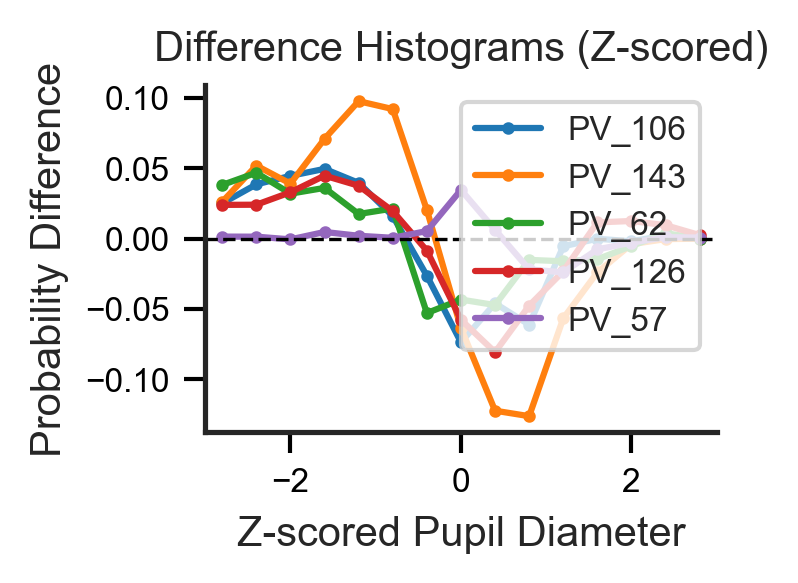

In [37]:
def compare_animals_difference_histogram_zscore(block_dict, export_path=None, num_bins=40,
                                                  x_range=(-3, 3), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals,
    with pupil diameter values normalized by z-scoring (subtracting the mean and dividing by the standard deviation).

    Outlier removal is performed using global percentiles. Then, for each animal the combined active and quiet data
    (after dropping NaNs) are z-scored. Shared histogram bin edges are used on the z-scored data for plotting.

    Args:
        block_dict (dict): Dictionary where keys include an animal identifier (e.g., 'PV_62_block_023') and
                           values are block objects with the necessary dataframes.
        export_path (str): Directory to save the output plot and data.
        num_bins (int): Number of bins for the z-scored pupil diameter values.
        x_range (tuple): Range for the x-axis in the z-scored space (default is (-3, 3)).
        outlier_percentiles (tuple): Percentile range for global outlier removal.
    """
    import re, os, datetime, pickle
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    overall_data = []
    animal_data = {}  # Aggregate raw data per animal

    # Process each block
    for key, block in block_dict.items():
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}

        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are in milliseconds already.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            # Drop NaNs during extraction
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna().values
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna().values

            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)

            overall_data.extend(left_vals)
            overall_data.extend(right_vals)

    overall_data = np.array(overall_data)
    # Compute global outlier limits
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)

    # Prepare plotting
    colors = sns.color_palette('tab10', n_colors=len(animal_data))
    animal_diffs = {}
    bin_edges = np.linspace(x_range[0], x_range[1], num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Process per animal
    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        # Remove outliers based on global limits
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

        # Combine active and quiet data to calculate mean and std (NaNs already dropped)
        combined = np.concatenate((active_data, quiet_data))
        if combined.size == 0:
            continue
        mean_val = np.nanmean(combined)
        std_val = np.nanstd(combined)
        # Avoid division by zero
        if std_val == 0:
            std_val = 1.0

        # Z-score transformation
        active_z = (active_data - mean_val) / std_val
        quiet_z = (quiet_data - mean_val) / std_val

        # Compute histograms on the z-scored data
        hist_active, _ = np.histogram(active_z, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_z, bins=bin_edges)
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

        # Difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff

    # Create the plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2.2, 1.5), dpi=300)
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=2, linestyle='-', color=colors[idx], label=animal)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Difference Histograms (Z-scored)', fontsize=10)
    ax.set_xlabel('Z-scored Pupil Diameter', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    # Configure tick parameters
    ax.tick_params(axis='both', which='both', bottom=True, left=True)

    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')

    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)



    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_comparison_zscore_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "pupil_diameter_diff_comparison_zscore.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "animal_diff_data_zscore.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)
        print(f"Exported plot and data to: {full_export_path}")
    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals'
compare_animals_difference_histogram_zscore(block_dict, export_path=None, num_bins=15,
                                                  x_range=(-3, 3), outlier_percentiles=(0.1, 99.9))

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals\pupil_diameter_diff_comparison_zscore_2025_11_05_19_06_27


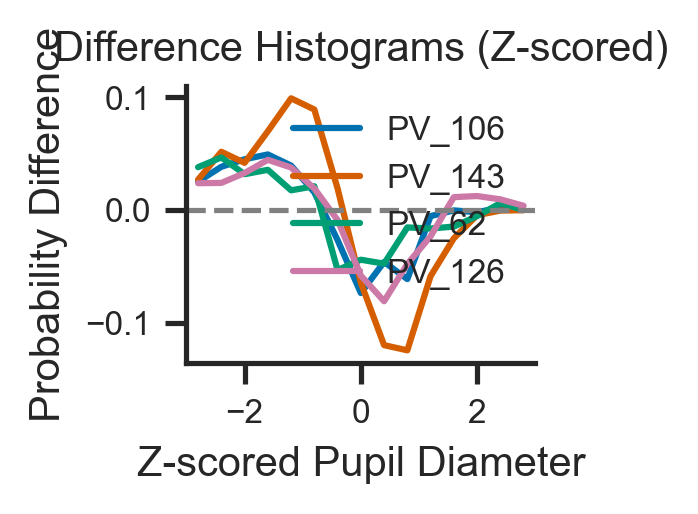

In [42]:
def compare_animals_difference_histogram_zscore(block_dict, export_path=None, num_bins=40,
                                                x_range=(-3, 3), outlier_percentiles=(0.001, 99.999)):
    import re, os, datetime, pickle
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    overall_data = []
    animal_data = {}

    for key, block in block_dict.items():
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}

        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna().values
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna().values

            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)
            overall_data.extend(left_vals)
            overall_data.extend(right_vals)

    overall_data = np.array(overall_data)
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)

    # Okabe–Ito palette
    colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442',
              '#56B4E9', '#E69F00', '#000000']

    animal_diffs = {}
    bin_edges = np.linspace(x_range[0], x_range[1], num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    for animal, data_dict in animal_data.items():
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

        combined = np.concatenate((active_data, quiet_data))
        if combined.size == 0:
            continue
        mean_val = np.nanmean(combined)
        std_val = np.nanstd(combined)
        if std_val == 0:
            std_val = 1.0

        active_z = (active_data - mean_val) / std_val
        quiet_z = (quiet_data - mean_val) / std_val

        hist_active, _ = np.histogram(active_z, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_z, bins=bin_edges)
        prob_active = hist_active / np.sum(hist_active) if np.sum(hist_active) > 0 else hist_active
        prob_quiet = hist_quiet / np.sum(hist_quiet) if np.sum(hist_quiet) > 0 else hist_quiet

        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff

    # --- Plot ---
    mpl.rcParams['font.sans-serif'] = ['Arial']
    mpl.rcParams['font.family'] = 'sans-serif'

    fig, ax = plt.subplots(figsize=(1.5, 1.2), dpi=300)

    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, linewidth=1.5, marker=None,
                color=colors[idx % len(colors)], label=animal)

    ax.axhline(0, color='gray', linewidth=1.25, linestyle='--')

    ax.set_title('Difference Histograms (Z-scored)', fontsize=10)
    ax.set_xlabel('Z-scored Pupil Diameter', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)

    # Restore outward ticks
    #ax.minorticks_on()
    ax.tick_params(axis='both', which='major', direction='out', length=5, width=1.25)
    #ax.tick_params(axis='both', which='minor', direction='out', length=0, width=0.8)
    ax.tick_params(axis='both', labelsize=8)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Spines
    for side in ['left', 'bottom']:
        ax.spines[side].set_linewidth(1.25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8, frameon=False)

    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_comparison_zscore_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "pupil_diameter_diff_comparison_zscore.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "animal_diff_data_zscore.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals'
substring = 'PV_57'
filtered_dict = {k: v for k, v in block_dict.items() if substring not in k}
compare_animals_difference_histogram_zscore(filtered_dict, export_path=export_path, num_bins=15,
                                                  x_range=(-3, 3), outlier_percentiles=(0.1, 99.9))

Exported plot + separate legend to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals\pupil_diff_export_2025_11_05_19_07_38


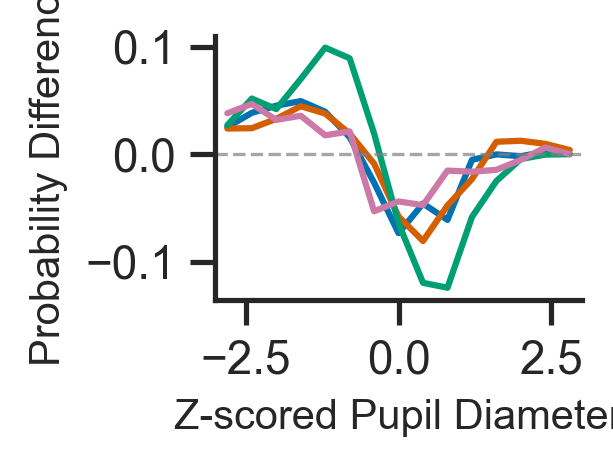

({'PV_106': array([ 2.51886166e-02,  3.83518682e-02,  4.50140489e-02,  4.93066344e-02,
          3.94135236e-02,  1.56995558e-02, -2.66636652e-02, -7.36145602e-02,
         -4.60604957e-02, -6.12534210e-02, -5.38677407e-03, -3.10857811e-04,
         -1.99600823e-03,  2.32244994e-03, -1.09151591e-05]),
  'PV_143': array([ 0.02693723,  0.05166215,  0.04184368,  0.0698568 ,  0.09908375,
          0.08915989,  0.01911349, -0.06447738, -0.11983819, -0.12442736,
         -0.05862102, -0.02506885, -0.00459509, -0.00049076, -0.00013835]),
  'PV_62': array([ 0.03799711,  0.04663987,  0.03178459,  0.0356722 ,  0.01747065,
          0.02109909, -0.05325719, -0.0440654 , -0.04755498, -0.01538895,
         -0.01643469, -0.01465554, -0.00540341,  0.00609664,  0.        ]),
  'PV_126': array([ 0.02377449,  0.02405917,  0.03279235,  0.04454085,  0.03772201,
          0.01910802, -0.00889529, -0.05813613, -0.08089054, -0.0478247 ,
         -0.02333227,  0.01142947,  0.01241537,  0.009475  ,  0.00376221

In [43]:
# =========================
# Universal color utilities
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from pathlib import Path
import datetime as _dt

COLOR_TEMPLATES = {
    # Colorblind-safe (Okabe–Ito)
    "okabeito": ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
                 "#F0E442", "#56B4E9", "#E69F00", "#000000"],
    # Tableau-10 as an alternative
    "tableau10": [plt.get_cmap("tab10")(i) for i in range(10)],
}

def build_color_map(labels, template="okabeito", custom=None, order=None):
    """
    Return dict {label -> color}. If you want stable per-animal colors across figures,
    pass a canonical 'order' (list of all animals) or pass an explicit color_map to the
    plotting functions.
    """
    labs = list(order) if order is not None else list(labels)
    base = list(custom) if custom is not None else list(COLOR_TEMPLATES.get(template, COLOR_TEMPLATES["okabeito"]))
    return {lab: base[i % len(base)] for i, lab in enumerate(labs)}

def set_axes_color_cycle(ax, labels, color_map):
    ax.set_prop_cycle(cycler(color=[color_map[l] for l in labels]))
# =========================
# Pupil diameter difference (z-scored) with shared colors + sep. legend
# =====================================================================
def compare_animals_difference_histogram_zscore_colored(
    block_dict,
    export_path=None,
    num_bins=40,
    x_range=(-3, 3),
    outlier_percentiles=(0.001, 99.999),
    figure_size=(2.2, 1.7),
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,               # <-- optional fixed mapping {'PV_62':'#...'}
    plot_name="pupil_diameter_diff_comparison_zscore.pdf"
):
    """
    Plot (active - quiet) z-scored pupil histograms per animal.
    - No markers, no background grid, separate legend PDF (if export_path).
    - Uses a shared color palette; pass 'color_map' to lock colors per animal globally.
    """
    import re, pickle

    # --- aggregate per animal ---
    overall = []
    animal_data = {}
    for key, block in block_dict.items():
        m = re.match(r'^(PV_\d+)', key)
        if not m:
            continue
        animal = m.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}

        behavior_df = block.behavior_state
        L = block.left_eye_data
        R = block.right_eye_data

        for _, row in behavior_df.iterrows():
            ann = row['annotation']
            if ann not in ['active','quiet']:
                continue
            t0, t1 = row['start_time'], row['end_time']
            lvals = L.query('ms_axis > @t0 and ms_axis < @t1')["pupil_diameter"].dropna().values
            rvals = R.query('ms_axis >= @t0 and ms_axis <= @t1')["pupil_diameter"].dropna().values
            animal_data[animal][ann].extend(lvals); animal_data[animal][ann].extend(rvals)
            overall.extend(lvals); overall.extend(rvals)

    overall = np.asarray(overall, float)
    if overall.size == 0:
        raise ValueError("No pupil diameter data found.")

    # global outlier clip
    o_min, o_max = np.percentile(overall, outlier_percentiles)

    # z-space bins
    bin_edges = np.linspace(x_range[0], x_range[1], num_bins + 1)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

    # diffs per animal
    animal_diffs = {}
    for animal, d in animal_data.items():
        a = np.asarray(d['active'], float); q = np.asarray(d['quiet'], float)
        a = a[(a >= o_min) & (a <= o_max)]; q = q[(q >= o_min) & (q <= o_max)]
        comb = np.concatenate([a,q])
        if comb.size == 0:
            continue
        mu, sd = np.nanmean(comb), np.nanstd(comb);  sd = sd if sd>0 else 1.0
        az = (a - mu)/sd; qz = (q - mu)/sd
        ha,_ = np.histogram(az, bins=bin_edges); hq,_ = np.histogram(qz, bins=bin_edges)
        pa = ha/ha.sum() if ha.sum()>0 else ha;  pq = hq/hq.sum() if hq.sum()>0 else hq
        animal_diffs[animal] = (pa - pq)

    animals = sorted(animal_diffs.keys())
    if not animals:
        raise ValueError("No valid animals after preprocessing.")

    # colors
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # plot
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    for animal in animals:
        h, = ax.plot(bin_centers, animal_diffs[animal], linewidth=1.5,
                     color=cmap[animal], label=animal)
        legend_handles.append(h); legend_labels.append(animal)

    ax.axhline(0, color='gray', lw=0.8, ls='--', alpha=0.7)

    ax.set_xlim(x_range)
    ax.set_xlabel('Z-scored Pupil Diameter', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    # Ensure axes lines (spines) are visible
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Make ticks visible on left + bottom
    ax.tick_params(axis='x', which='both',
                   bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both',
                   left=True, right=False, labelleft=True)
    ax.grid(False)  # <- ensure no grid regardless of style
    plt.tight_layout()

    # export main plot + separate legend
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"pupil_diff_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)

        fig.savefig(outdir / plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir / ('legend_' + plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)

        # save data
        with open(outdir / "animal_diff_data_zscore.pkl", 'wb') as f:
            pickle.dump({k: np.asarray(v) for k, v in animal_diffs.items()}, f)

        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return animal_diffs, cmap
compare_animals_difference_histogram_zscore_colored(filtered_dict, figure_size=(2.2,1.7),export_path=export_path, num_bins=15,
                                                  x_range=(-3, 3), outlier_percentiles=(0.1, 99.9))

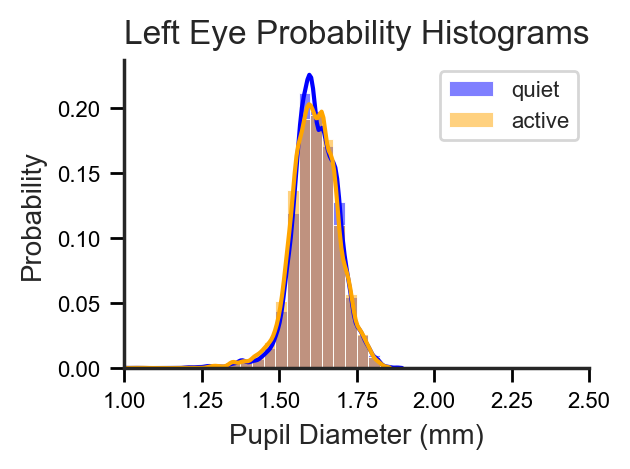

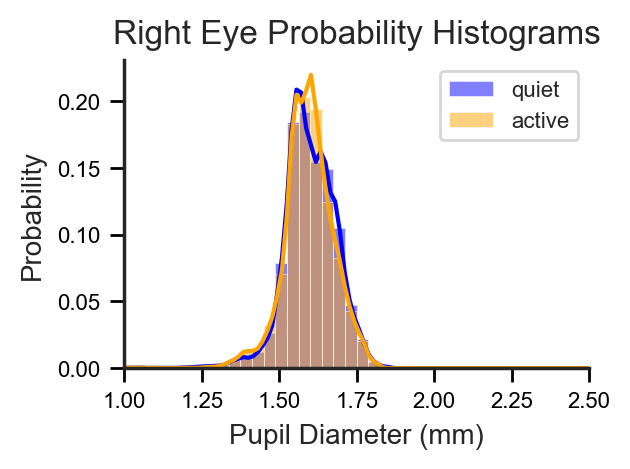

In [62]:
def plot_split_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15),
                                          outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Separates data
    into two plots: one for the left eye and one for the right eye.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')[
                'pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')[
                'pupil_diameter'].dropna()

            # Add data to respective dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot for left eye
    fig_left, ax_left = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_left,
        )
    ax_left.set_title('Left Eye Probability Histograms', fontsize=12)
    ax_left.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_left.set_ylabel('Probability', fontsize=10)
    ax_left.tick_params(axis='both', labelsize=8)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)
    ax_left.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black', bottom=True,
                        left=True)
    ax_left.tick_params(axis='both', direction='out', which='minor', length=5, width=1, colors='black', bottom=True,
                        left=True)
    ax_left.set_xlim(x_range)
    ax_left.legend(loc='upper right', fontsize=8)

    # Plot for right eye
    fig_right, ax_right = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_right,
        )

    ax_right.set_title('Right Eye Probability Histograms', fontsize=12)
    ax_right.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_right.set_ylabel('Probability', fontsize=10)
    ax_right.tick_params(axis='both', labelsize=8)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_right.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black', bottom=True,
                         left=True)
    ax_right.tick_params(axis='both', direction='out', which='minor', length=5, width=1, colors='black', bottom=True,
                         left=True)
    ax_right.set_xlim(x_range)
    ax_right.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"split_eye_pupil_diameter_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save left eye plot
        pdf_file_left = os.path.join(full_export_path, "left_eye_pupil_vs_behavior.pdf")
        fig_left.savefig(pdf_file_left, format='pdf', bbox_inches='tight', dpi=300)

        # Save right eye plot
        pdf_file_right = os.path.join(full_export_path, "right_eye_pupil_vs_behavior.pdf")
        fig_right.savefig(pdf_file_right, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'left_eye': left_eye_aggregated, 'right_eye': right_eye_aggregated}, f)

        print(f"Exported plots and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62'
plot_split_eye_probability_histograms(blocks[-2:], export_path=None, num_bins=40, x_range=(1, 2.5))

In [48]:
path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals\pupil_diameter_diff_comparison_zscore_2025_02_25_19_07_57/animal_diff_data_zscore.pkl'
df = pd.read_pickle(path)

In [55]:
block = block_dict['PV_57_block_012']

In [42]:
blocks = [i for i in block_collection if 'PV_57' in str(i)]

In [56]:
read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\analysis\block_012_behavior_state.csv


,start_time,end_time,annotation
0,53743.4,129743.4,quiet
1,115743.4,135743.4,active
2,121743.4,167743.4,quiet
3,153743.4,183743.4,active
4,169743.4,190743.4,quiet
5,176743.4,225743.4,active
6,211743.4,226743.4,quiet
7,212743.4,241743.4,active
8,227743.4,343743.4,quiet
9,329743.4,363743.4,active


In [12]:
block_dict

{'PV_106_block_008': BlockSync object for animal PV_106 with 
 block_num 008 at date PV106_ET_d3t12025-08-06_11-52-19,
 'PV_106_block_009': BlockSync object for animal PV_106 with 
 block_num 009 at date PV106_ET_d3t2_2025-08-06_12-09-43,
 'PV_106_block_010': BlockSync object for animal PV_106 with 
 block_num 010 at date PV106_ET_d3t3_2025-08-06_12-26-43,
 'PV_106_block_011': BlockSync object for animal PV_106 with 
 block_num 011 at date PV106_ET_d3t4_2025-08-06_12-44-30,
 'PV_106_block_012': BlockSync object for animal PV_106 with 
 block_num 012 at date PV106_ET_d3t5_2025-08-06_13-21-30,
 'PV_143_block_001': BlockSync object for animal PV_143 with 
 block_num 001 at date PV143_ET_d1t1_2025-08-11_13-29-08,
 'PV_143_block_002': BlockSync object for animal PV_143 with 
 block_num 002 at date PV143_ET_d1t2_2025-08-11_13-50-11,
 'PV_143_block_003': BlockSync object for animal PV_143 with 
 block_num 003 at date PV143_ET_d1t3_2025-08-11_14-20-35,
 'PV_143_block_004': BlockSync object for

In [14]:
# --- State-epoch electrophysiology PSD (block_dict) ---
# Self-contained cell (Python 3.8 compatible)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import welch

# --------------------------
# Helper: robust attribute fetch
# --------------------------
def _get_first_attr(obj, names, default=None):
    for n in names:
        if hasattr(obj, n):
            return getattr(obj, n)
    return default

# --------------------------
# Helper: get/clean behavior state df from a block
# Expected columns in ms: start_time, end_time, (annotation OR state)
# --------------------------
def _get_clean_state_df(block, states_keep=None):
    sdf = _get_first_attr(block, ["behavior_state", "behavior_state_df", "state_df", "state_annotations"], default=None)
    if sdf is None or (not isinstance(sdf, pd.DataFrame)) or sdf.empty:
        return None

    sdf = sdf.copy()
    if "annotation" in sdf.columns and "state" not in sdf.columns:
        sdf = sdf.rename(columns={"annotation": "state"})

    need = ["start_time", "end_time", "state"]
    if not all(c in sdf.columns for c in need):
        return None

    sdf = sdf[need].copy()
    sdf["start_time"] = pd.to_numeric(sdf["start_time"], errors="coerce")
    sdf["end_time"]   = pd.to_numeric(sdf["end_time"], errors="coerce")
    sdf["state"]      = sdf["state"].astype(str).str.lower().str.strip()
    sdf = sdf.dropna(subset=["start_time", "end_time", "state"])
    sdf = sdf[sdf["end_time"] >= sdf["start_time"]]

    if states_keep is not None:
        states_keep = [s.lower().strip() for s in states_keep]
        sdf = sdf[sdf["state"].isin(states_keep)]

    if sdf.empty:
        return None
    return sdf

# --------------------------
# Helper: epoch -> window start times (ms)
# --------------------------
def _epoch_to_window_starts(start_ms, end_ms, window_ms, step_ms):
    # start positions such that [t, t+window_ms] stays inside the epoch
    if end_ms - start_ms < window_ms:
        return np.array([], dtype=float)
    n = int(np.floor((end_ms - start_ms - window_ms) / float(step_ms))) + 1
    if n <= 0:
        return np.array([], dtype=float)
    return start_ms + np.arange(n, dtype=float) * float(step_ms)

# --------------------------
# Main function
# --------------------------
def state_ep_psd(
    block_dict,
    states=("quiet", "active"),
    channels=None,                  # list of 1-indexed OE channel numbers (per your oe_rec.get_data API)
    window_ms=2000,                 # Welch window length in ms (also the data window we request)
    step_ms=None,                   # step between successive windows; default = window_ms (non-overlapping)
    fmax=100.0,
    plot_db=True,
    detrend=False,                  # keep simple/ground-level: NO detrending by default
    nperseg=None,                   # welch nperseg in samples; default = full window (best low-freq resolution)
    batch_windows=200,              # get_data calls per batch to keep memory reasonable
    skip_animals=("PV_57",),
    verbose=True,
    make_plots=True
):
    """
    Compute PSDs of electrophysiology during behavior-state epochs across a block_dict.

    Inputs
    ------
    block_dict : dict
        Values are BlockSync blocks.
    states : tuple/list of str
        e.g. ('quiet','active') - will match behavior_state['state'] after lowercasing.
    channels : list[int] or None
        Channels to pull via oe_rec.get_data. If None, tries to infer from block.oe_rec metadata (often not reliable),
        so in practice you should pass an explicit list.
    window_ms : int/float
        Duration of each sampled data window (and Welch window) in ms.
    step_ms : int/float or None
        Step between consecutive windows in ms. None -> equals window_ms (no overlap).
    fmax : float
        Plot/return PSD up to this frequency (Hz).
    plot_db : bool
        True -> 10*log10(PSD) for plotting/output.
    detrend : bool or str
        Passed into scipy.signal.welch (False keeps raw baseline/offset).
    nperseg : int or None
        Welch nperseg in samples. None uses full window -> highest low-freq resolution for this window length.
    batch_windows : int
        How many windows to request per oe_rec.get_data call (controls memory).
    skip_animals : iterable[str]
        Animals to skip (e.g. PV_57).
    make_plots : bool
        If True, returns matplotlib figs per animal (mean across channels).

    Outputs
    -------
    df_psd : pd.DataFrame (tidy)
        Columns: animal, block_num, state, channel, freq_hz, psd_mean, psd_sem, n_windows
    figs : dict (animal -> fig) if make_plots else {}
    """
    if step_ms is None:
        step_ms = window_ms

    states = [s.lower().strip() for s in states]
    skip_set = set([s for s in (skip_animals or [])])

    rows = []
    figs = {}

    for k, block in block_dict.items():
        animal = _get_first_attr(block, ["animal_call", "animal", "animal_id"], default=None)
        block_num = _get_first_attr(block, ["block_num", "block_number"], default=k)

        if animal is None:
            if verbose:
                print(f"[skip] block {block_num}: missing animal id")
            continue
        if animal in skip_set:
            if verbose:
                print(f"[skip] {animal} block {block_num}: in skip list")
            continue

        oe_rec = _get_first_attr(block, ["oe_rec"], default=None)
        if oe_rec is None:
            if verbose:
                print(f"[skip] {animal} block {block_num}: no oe_rec (no electrophysiology)")
            continue

        # sampling rate (Hz)
        fs_hz = _get_first_attr(block, ["sample_rate", "fs", "ep_fs"], default=None)
        if fs_hz is None:
            # last resort: try oe_rec
            fs_hz = _get_first_attr(oe_rec, ["sample_rate", "fs"], default=None)
        if fs_hz is None:
            if verbose:
                print(f"[skip] {animal} block {block_num}: couldn't infer sample rate")
            continue
        fs_hz = float(fs_hz)

        # behavior state df
        sdf = _get_clean_state_df(block, states_keep=states)
        if sdf is None:
            if verbose:
                print(f"[skip] {animal} block {block_num}: missing/invalid behavior_state")
            continue

        if channels is None:
            # You *can* add inference here, but in your pipeline this is often ambiguous.
            # Better to pass channels explicitly.
            raise ValueError(
                "channels=None: please pass an explicit channel list, e.g. channels=list(range(1,65)) or [28]."
            )
        ch_list = list(channels)

        # Build window starts per state
        starts_by_state = {st: [] for st in states}
        for _, r in sdf.iterrows():
            st = r["state"]
            st_starts = _epoch_to_window_starts(r["start_time"], r["end_time"], window_ms, step_ms)
            if st_starts.size:
                starts_by_state[st].append(st_starts)

        for st in states:
            if len(starts_by_state[st]) == 0:
                continue
            start_times_ms = np.concatenate(starts_by_state[st]).astype(float)
            if start_times_ms.size == 0:
                continue

            # Welch config
            # Use full window by default for best low-freq resolution given window_ms.
            n_samples = int(round((window_ms / 1000.0) * fs_hz))
            this_nperseg = int(n_samples) if nperseg is None else int(nperseg)
            this_nperseg = max(8, min(this_nperseg, n_samples))  # safe bounds

            # Online accumulation: sum and sumsq over windows (per channel, per freq)
            freq_ref = None
            sum_psd = None
            sumsq_psd = None
            n_w_total = 0

            # Batch get_data to avoid huge memory
            for b0 in range(0, len(start_times_ms), int(batch_windows)):
                b1 = min(len(start_times_ms), b0 + int(batch_windows))
                st_batch = start_times_ms[b0:b1]

                # NOTE: oe_rec.get_data returns data_matrix shape [n_channels, n_windows, nSamples]
                data, t_rel = oe_rec.get_data(
                    channels=ch_list,
                    start_time_ms=st_batch,
                    window_ms=window_ms,
                    convert_to_mv=True,
                    return_timestamps=True,
                    repress_output=True
                )

                # reshape to (n_channels*n_windows, n_samples) for welch
                # and compute along last axis
                # data expected float mV (per your API); welch returns V^2/Hz units of input squared.
                x = np.asarray(data)
                if x.ndim != 3:
                    raise RuntimeError(f"Unexpected get_data shape {x.shape}; expected [n_channels,n_windows,nSamples].")

                n_ch, n_w, n_s = x.shape
                x2 = x.reshape(n_ch * n_w, n_s)

                f, pxx = welch(
                    x2,
                    fs=fs_hz,
                    window="hann",
                    nperseg=this_nperseg,
                    noverlap=0,
                    detrend=detrend,
                    scaling="density",
                    return_onesided=True,
                    axis=-1
                )  # pxx: (n_ch*n_w, n_freq)

                # keep up to fmax
                keep = f <= float(fmax)
                f = f[keep]
                pxx = pxx[:, keep]

                # reshape back to (n_ch, n_w, n_freq)
                pxx = pxx.reshape(n_ch, n_w, pxx.shape[-1])

                if freq_ref is None:
                    freq_ref = f
                    sum_psd = np.zeros((n_ch, len(freq_ref)), dtype=np.float64)
                    sumsq_psd = np.zeros((n_ch, len(freq_ref)), dtype=np.float64)

                # mean over windows in this batch, but we need total sums across windows
                # accumulate per-window contributions
                # (sum across windows -> add to sum; sum of squares across windows -> add to sumsq)
                sum_psd += np.sum(pxx, axis=1)
                sumsq_psd += np.sum(pxx * pxx, axis=1)
                n_w_total += n_w

            if n_w_total < 2:
                if verbose:
                    print(f"[warn] {animal} block {block_num} state={st}: too few windows ({n_w_total})")
                continue

            mean_psd = sum_psd / float(n_w_total)
            # unbiased variance estimate across windows:
            var_psd = (sumsq_psd - (sum_psd * sum_psd) / float(n_w_total)) / float(max(1, n_w_total - 1))
            sem_psd = np.sqrt(np.maximum(var_psd, 0.0)) / np.sqrt(float(n_w_total))

            # optionally convert to dB (apply to mean; SEM in dB is not strictly linear—keep linear SEM for stats)
            if plot_db:
                mean_out = 10.0 * np.log10(np.maximum(mean_psd, 1e-30))
                # approximate SEM in dB via delta method: d(10log10 x)/dx = 10/(ln10)/x
                sem_out = (10.0 / np.log(10.0)) * (sem_psd / np.maximum(mean_psd, 1e-30))
            else:
                mean_out = mean_psd
                sem_out = sem_psd

            # store tidy rows
            for ci, ch in enumerate(ch_list):
                for fi, fr in enumerate(freq_ref):
                    rows.append({
                        "animal": animal,
                        "block_num": block_num,
                        "state": st,
                        "channel": int(ch),
                        "freq_hz": float(fr),
                        "psd_mean": float(mean_out[ci, fi]),
                        "psd_sem": float(sem_out[ci, fi]),
                        "n_windows": int(n_w_total),
                        "fs_hz": float(fs_hz),
                        "window_ms": float(window_ms),
                        "step_ms": float(step_ms),
                        "plot_db": bool(plot_db)
                    })

            if verbose:
                print(f"[ok] {animal} block {block_num} state={st}: windows={n_w_total}, fs={fs_hz:.1f}Hz, chans={len(ch_list)}")

    df_psd = pd.DataFrame(rows)
    if df_psd.empty:
        raise RuntimeError("No PSD results produced. Check: behavior_state present? oe_rec present? channels provided?")

    # Optional plots: per animal, quiet vs active, mean across channels (with SEM across channels)
    if make_plots:
        for animal in sorted(df_psd["animal"].unique()):
            sub = df_psd[df_psd["animal"] == animal].copy()
            # aggregate across blocks AND channels (mean across channels; SEM across channels not identical to SEM across windows)
            # For visualization only: average psd_mean across channels.
            fig, ax = plt.subplots(figsize=(6.5, 3.5), dpi=150)
            for st in states:
                ss = sub[sub["state"] == st]
                if ss.empty:
                    continue
                # mean across channels and blocks at each freq
                g = ss.groupby("freq_hz")["psd_mean"].mean()
                ax.plot(g.index.values, g.values, linewidth=1.8, label=st)

            ax.set_title(f"{animal}: State PSD (mean across channels/blocks)")
            ax.set_xlabel("Frequency (Hz)")
            ax.set_ylabel("PSD (dB)" if plot_db else "PSD (linear units)")
            ax.set_xlim(0, float(fmax))
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.legend(frameon=False)
            fig.tight_layout()
            figs[animal] = fig

    return df_psd, figs


# --------------------------
# Example usage (edit to your needs)
# --------------------------
# 1) Explicit channels is recommended
df_psd, figs = state_ep_psd(block_dict, states=("quiet","active"), channels=[28], window_ms=2000, step_ms=2000, fmax=100, plot_db=True)

# 2) Multiple electrodes
# df_psd, figs = state_ep_psd(block_dict, states=("quiet","active"), channels=list(range(1,65)), window_ms=2000, step_ms=2000, fmax=100, plot_db=True)

# 3) Export per-animal plots as editable PDFs
out_dir = Path(r"Z:\Nimrod\experiments\multi_animal_analysis\EP_over_animals")
out_dir.mkdir(parents=True, exist_ok=True)
for animal, fig in figs.items():
    fig.savefig(out_dir / f"{animal}_state_psd.pdf")
print("Saved PDFs to:", out_dir)


There was a problem reshaping ... [-347 -374 -494 ... 1029 1543 2303]


RuntimeError: Unexpected get_data shape (); expected [n_channels,n_windows,nSamples].